In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from datetime import datetime


# --- Константы и настройки ---
DATA_DIR = './'  # Ваш путь к директории

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Настройки для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"Не удалось установить шрифт для русского языка: {e}. Графики могут отображаться некорректно.")

print("Блок 1: Импорты и базовые настройки загружены.")

Блок 1: Импорты и базовые настройки загружены.


In [3]:
# Блок 2: Функции загрузки и предобработки данных

def load_data():
    """Загружает данные из CSV и Parquet файлов."""
    data_files = {}
    files = {
        'person': 'Person.csv',
        'goods': 'Goods.csv',
        'purchases': 'List_Purchases.parquet',
        'cheques': 'List_Cheques.parquet'
    }

    for key, filename in files.items():
        filepath = os.path.join(DATA_DIR, filename)
        try:
            if filename.endswith('.csv'):
                data_files[key] = pd.read_csv(filepath, sep=',')
            elif filename.endswith('.parquet'):
                data_files[key] = pd.read_parquet(filepath)
            print(f"{filename} загружен.")
        except FileNotFoundError:
            print(f"Ошибка: {filename} не найден в {DATA_DIR}")
            return None
    return data_files

def preprocess_data(data):
    """Выполняет предобработку данных: преобразование типов, обработка пропусков и выбросов."""

    print("\nНачинаем предобработку данных...")

    # Person data
    if 'person' in data:
        data['person']['First_Purch_date'] = pd.to_datetime(data['person']['First_Purch_date'])
        data['person']['Age'] = data['person']['Age'].fillna(data['person']['Age'].median()).astype(int)
        data['person']['Gend'] = data['person']['Gend'].fillna('U')

        initial_person_count = len(data['person'])
        data['person'] = data['person'][
            (data['person']['Age'] >= 18) & (data['person']['Age'] <= 100)
        ]
        print(f"Удалено {initial_person_count - len(data['person'])} записей клиентов из-за аномального возраста (<18 или >100).")
        print("Предобработка Person.csv завершена.")

    # Goods data
    if 'goods' in data:
        data['goods'].columns = [col.lower() for col in data['goods'].columns]
        for col in ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey',
                    'brand_bkey', 'manufator_bkey']:
            if col in data['goods'].columns:
                data['goods'][col] = data['goods'][col].fillna(-1).astype(int)

        if 'waight' in data['goods'].columns:
            data['goods']['waight'] = data['goods']['waight'].fillna(0.0)

        for col in ['self_brand_flag', 'alco_flag']:
            if col in data['goods'].columns:
                data['goods'][col] = data['goods'][col].fillna(0).astype(int)
        print("Предобработка Goods.csv завершена.")

    # Purchases data
    if 'purchases' in data:
        data['purchases']['Opetation_datetime'] = pd.to_datetime(data['purchases']['Opetation_datetime'])
        numeric_cols_purchases = ['toCard_stand', 'toCard_short', 'fromCard_stand',
                                  'fromCard_short', 'Amount_Cheque', 'Qnt', 'Amount', 'Amount_Original']
        for col in numeric_cols_purchases:
            if col in data['purchases'].columns:
                data['purchases'][col] = data['purchases'][col].fillna(0.0)

        initial_purchases_count = len(data['purchases'])

        data['purchases'] = data['purchases'][
            (data['purchases']['Amount'] > 0) &
            (data['purchases']['Qnt'] > 0)
        ]

        for col in ['Amount', 'Amount_Cheque', 'Qnt']:
            if col in data['purchases'].columns:
                q1 = data['purchases'][col].quantile(0.25)
                q3 = data['purchases'][col].quantile(0.75)
                iqr = q3 - q1
                upper_bound = q3 + 3 * iqr

                data['purchases'] = data['purchases'][data['purchases'][col] <= upper_bound]
                print(f"Удалены выбросы в '{col}' (значения > {upper_bound:.2f}).")

        print(f"Удалено {initial_purchases_count - len(data['purchases'])} записей покупок из-за аномальных значений (отрицательные/нулевые суммы/количество, слишком большие чеки).")
        print("Предобработка List_Purchases.parquet завершена.")

    # Cheques data
    if 'cheques' in data:
        data['cheques']['Opetation_datetime'] = pd.to_datetime(data['cheques']['Opetation_datetime'])
        numeric_cols_cheques = ['Amount_Original', 'Amount', 'toCard_stand', 'toCard_short',
                                'fromCard_stand', 'fromCard_short', 'Amount_Cheque']
        for col in numeric_cols_cheques:
            if col in data['cheques'].columns:
                data['cheques'][col] = data['cheques'][col].fillna(0.0)

        initial_cheques_count = len(data['cheques'])
        data['cheques'] = data['cheques'][data['cheques']['Amount_Cheque'] > 0]

        if 'Amount_Cheque' in data['cheques'].columns:
            q1 = data['cheques']['Amount_Cheque'].quantile(0.25)
            q3 = data['cheques']['Amount_Cheque'].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 3 * iqr
            data['cheques'] = data['cheques'][data['cheques']['Amount_Cheque'] <= upper_bound]
            print(f"Удалены выбросы в 'Amount_Cheque' в Cheques (значения > {upper_bound:.2f}).")

        print(f"Удалено {initial_cheques_count - len(data['cheques'])} записей чеков из-за аномальных значений (отрицательные/нулевые суммы, слишком большие чеки).")
        print("Предобработка List_Cheques.parquet завершена.")

    return data

def merge_data(data):
    """Объединяет данные для создания единой аналитической таблицы."""
    print("\nНачинаем объединение данных...")

    if 'purchases' in data and 'goods' in data:
        data['purchases_merged'] = pd.merge(data['purchases'], data['goods'],
                                           left_on='Goods_BKEY', right_on='goods_bkey', how='left')
        print("Purchases и Goods объединены.")
    else:
        print("Недостаточно данных для объединения Purchases и Goods.")
        return None

    if 'person' in data and 'purchases_merged' in data:
        data['full_transactions'] = pd.merge(data['purchases_merged'], data['person'],
                                             on='Person_BKEY', how='left')
        print("Purchases (с Goods) и Person объединены в 'full_transactions'.")
    else:
        print("Недостаточно данных для объединения Person.")
        return None

    if 'Goods_BKEY_x' in data['full_transactions'].columns and 'Goods_BKEY_y' in data['full_transactions'].columns:
        data['full_transactions'] = data['full_transactions'].drop(columns=['Goods_BKEY_y'])
        data['full_transactions'] = data['full_transactions'].rename(columns={'Goods_BKEY_x': 'Goods_BKEY'})

    if 'goods_bkey' in data['full_transactions'].columns and 'Goods_BKEY' in data['full_transactions'].columns and \
       not data['full_transactions']['goods_bkey'].equals(data['full_transactions']['Goods_BKEY']):
        data['full_transactions'] = data['full_transactions'].drop(columns=['goods_bkey'])
    elif 'goods_bkey' in data['full_transactions'].columns and 'Goods_BKEY' not in data['full_transactions'].columns:
        data['full_transactions'] = data['full_transactions'].rename(columns={'goods_bkey': 'Goods_BKEY'})

    print("Объединение данных завершено.")
    return data['full_transactions']

print("Блок 2: Функции загрузки и предобработки данных загружены.")

Блок 2: Функции загрузки и предобработки данных загружены.


In [4]:
data_storage = load_data()
processed_data = preprocess_data(data_storage)
person_df_original = processed_data['person'].copy()

full_df = merge_data(processed_data)

Person.csv загружен.
Goods.csv загружен.
List_Purchases.parquet загружен.
List_Cheques.parquet загружен.

Начинаем предобработку данных...
Удалено 8164 записей клиентов из-за аномального возраста (<18 или >100).
Предобработка Person.csv завершена.
Предобработка Goods.csv завершена.
Удалены выбросы в 'Amount' (значения > 267.00).
Удалены выбросы в 'Amount_Cheque' (значения > 2989.68).
Удалены выбросы в 'Qnt' (значения > 1.00).
Удалено 16343792 записей покупок из-за аномальных значений (отрицательные/нулевые суммы/количество, слишком большие чеки).
Предобработка List_Purchases.parquet завершена.
Удалены выбросы в 'Amount_Cheque' в Cheques (значения > 1712.00).
Удалено 256896 записей чеков из-за аномальных значений (отрицательные/нулевые суммы, слишком большие чеки).
Предобработка List_Cheques.parquet завершена.

Начинаем объединение данных...
Purchases и Goods объединены.
Purchases (с Goods) и Person объединены в 'full_transactions'.
Объединение данных завершено.


In [4]:
full_df.describe()

Person_BKEY  Purchase_ID          Opetation_datetime  toCard_stand  toCard_short  fromCard_stand  fromCard_short  Amount_Cheque  Merchant_id  Goods_BKEY         Qnt      Amount  Amount_Original  goods_bkey  cat_lev_01_bkey  cat_lev_02_bkey  cat_lev_03_bkey  cat_lev_04_bkey  attribut_01  brand_bkey  manufator_bkey      waight  self_brand_flag   alco_flag               First_Purch_date         Age
count  40805214.00  40805214.00                    40805214   40805214.00   40805214.00     40805214.00     40805214.00    40805214.00  40805214.00 40805214.00 40805214.00 40805214.00      40805214.00 40805214.00      40805214.00      40805214.00      40805214.00      40805214.00  40257907.00 40805214.00     40805214.00 40805214.00      40805214.00 40805214.00                       40254809 40254809.00
mean     249961.92   5032256.01  2019-01-23 21:20:24.000105          6.70          0.06           -4.54           -0.31         666.59      6932.93    20602.33        1.00       60.24             4.10    20602.33             0.64            18.36           100.05           335.12       137.50     2043.07         1683.89        0.48             0.16        0.01  2017-12-04 20:02:56.677417728       46.12
min           0.00         0.00         2018-11-21 21:02:33          0.00          0.00        -2832.00         -300.00           0.99         0.00        0.00        1.00        1.00             0.00        0.00             0.00             0.00             0.00             0.00         1.00        0.00            0.00        0.00             0.00        0.00            2017-04-04 18:24:18       18.00
25%      124936.00   2516283.00         2018-12-25 14:20:20          1.30          0.00            0.00            0.00         269.00      3475.00    10510.00        1.00       29.00             0.00    10510.00             0.00             3.00            46.00           157.00        59.00     1126.00          881.00        0.10             0.00        0.00            2017-07-05 11:51:20       34.00
50%      249971.00   5033484.00         2019-01-26 15:36:35          2.60          0.00            0.00            0.00         497.39      6924.00    19382.00        1.00       48.00             0.00    19382.00             1.00            16.00            86.00           284.00       123.00     2030.00         1430.00        0.33             0.00        0.00            2017-09-23 15:42:52       44.00
75%      374912.00   7546993.00         2019-02-23 05:23:53          9.30          0.00            0.00            0.00         885.13     10417.00    31933.00        1.00       79.00             0.00    31933.00             1.00            30.00           164.00           521.00       212.00     3016.00         2620.00        0.75             0.00        0.00            2018-04-10 17:39:08       58.00
max      499999.00  10065265.00         2019-03-18 23:40:03        305.10        300.00            0.00            0.00        2989.68     13883.00    43037.00        1.00      267.00          3199.00    43037.00             3.00            42.00           201.00           790.00       321.00     4296.00         3193.00      600.00             1.00        1.00            2019-03-15 22:19:58      100.00
std      144261.93   2905388.14                         NaN          9.21          2.30           30.36            3.25         556.27      4006.26    12639.75        0.00       47.01            20.31    12639.75             0.52            13.67            61.42           223.38        93.48     1304.55          898.53        1.84             0.37        0.11                            NaN       15.34

In [5]:
def plot_client_demographics(person_df_for_plot):
    """Визуализация демографии клиентов."""
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(person_df_for_plot['Age'].dropna(), bins=20, kde=True, color='skyblue')
    plt.title('Распределение возраста клиентов')
    plt.xlabel('Возраст')
    plt.ylabel('Количество клиентов')

    plt.subplot(1, 2, 2)
    gender_counts = person_df_for_plot['Gend'].value_counts()
    sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis', hue=gender_counts.index, legend=False)
    plt.title('Распределение клиентов по полу')
    plt.xlabel('Пол')
    plt.ylabel('Количество клиентов')
    plt.tight_layout()
    plt.show()

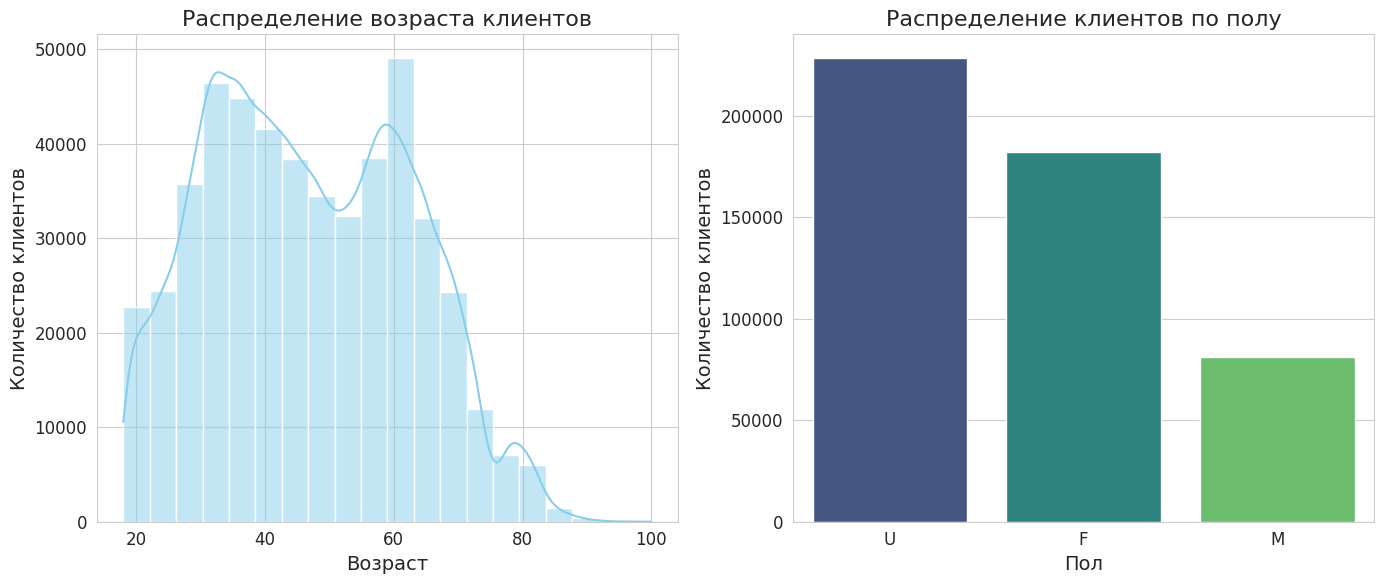

In [6]:
plot_client_demographics(person_df_original.copy())

In [7]:
def plot_rfm_segments(rfm_df):
    """Визуализация распределения RFM-показателей."""
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(rfm_df['Recency'], bins=30, kde=True, color='salmon')
    plt.title('Распределение давности (Recency)')
    plt.xlabel('Дни с последней покупки')
    plt.ylabel('Количество клиентов')

    plt.subplot(1, 3, 2)
    sns.histplot(rfm_df['Frequency'], bins=30, kde=True, color='lightgreen')
    plt.title('Распределение частоты (Frequency)')
    plt.xlabel('Количество уникальных покупок')
    plt.ylabel('Количество клиентов')

    plt.subplot(1, 3, 3)
    sns.histplot(rfm_df['Monetary'], bins=30, kde=True, color='gold')
    plt.title('Распределение денежной ценности (Monetary)')
    plt.xlabel('Сумма трат')
    plt.ylabel('Количество клиентов')
    plt.tight_layout()
    plt.show()


--- RFM-анализ (топ 5 по Monetary) ---
        Person_BKEY  Recency  Frequency  Monetary
258712       259224        1        188 109778.00
115173       115386        9        163  97943.00
261155       261667        1        197  90962.00
257425       257934        3        264  90713.00
391300       392583        1        261  80647.00


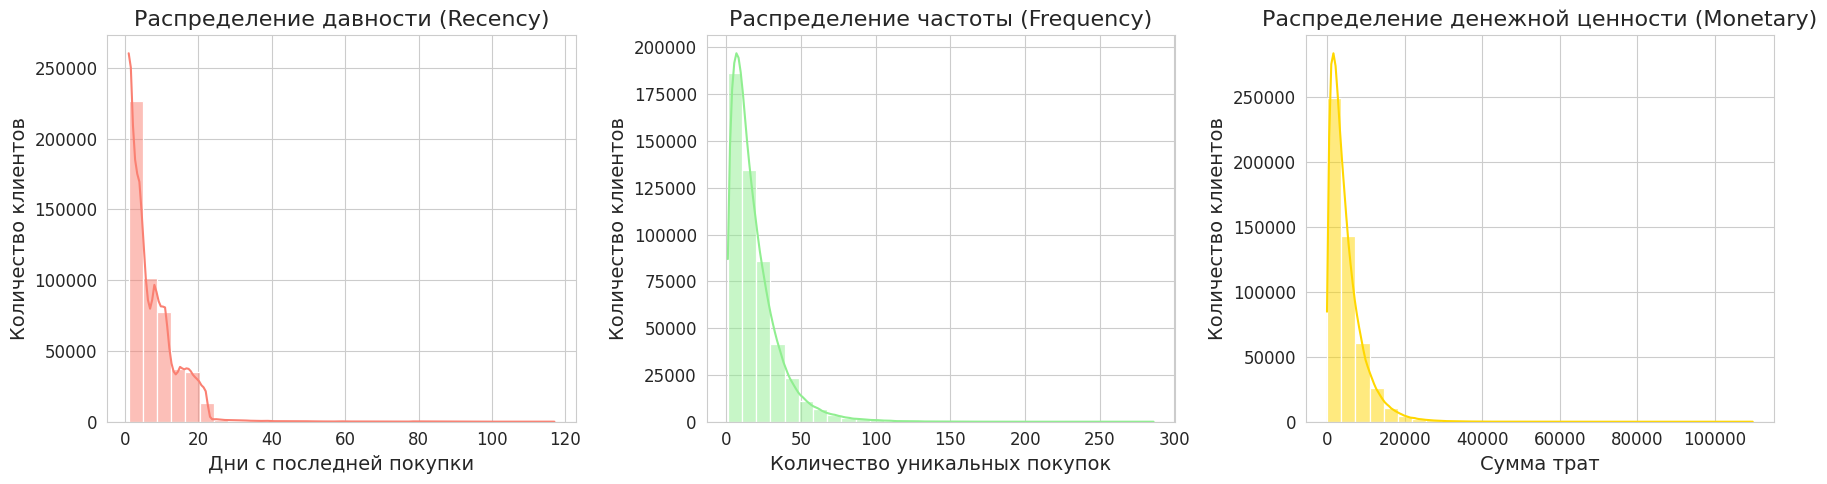

In [8]:
# RFM-анализ
if 'Opetation_datetime' in full_df.columns and 'Purchase_ID' in full_df.columns and 'Amount' in full_df.columns:
    max_date = full_df['Opetation_datetime'].max() + pd.Timedelta(days=1)
    rfm_actual = full_df.groupby('Person_BKEY', observed=True).agg(
        Recency=('Opetation_datetime', lambda date: (max_date - date.max()).days),
        Frequency=('Purchase_ID', 'nunique'),
        Monetary=('Amount', 'sum')
    ).reset_index()

    print("\n--- RFM-анализ (топ 5 по Monetary) ---")
    print(rfm_actual.sort_values(by='Monetary', ascending=False).head())
    plot_rfm_segments(rfm_actual)
else:
    print("Недостаточно колонок для RFM-анализа (нужны 'Opetation_datetime', 'Purchase_ID', 'Amount').")

In [9]:
def plot_top_categories_brands(df):
    """Визуализация топ-категорий и брендов по продажам для уровней 01, 02, 03, 04."""

    # Уровень 1
    if 'cat_lev_01_bkey' in df.columns:
        top_categories_01 = df.groupby('cat_lev_01_bkey', observed=True)['Amount'].sum().nlargest(10).sort_values(ascending=True)
        if not top_categories_01.empty:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_categories_01.values, y=top_categories_01.index.astype(str), palette='coolwarm', hue=top_categories_01.index.astype(str), legend=False)
            plt.title('Топ 10 категорий (уровень 1) по объему продаж')
            plt.xlabel('Общий объем продаж')
            plt.ylabel('ID Категории')
            plt.show()
        else:
            print("Недостаточно данных для построения графика топ-10 категорий (уровень 1).")
    else:
        print("Колонка 'cat_lev_01_bkey' не найдена для построения графика категорий (уровень 1).")

    # Уровень 2
    if 'cat_lev_02_bkey' in df.columns:
        top_categories_02 = df.groupby('cat_lev_02_bkey', observed=True)['Amount'].sum().nlargest(10).sort_values(ascending=True)
        if not top_categories_02.empty:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_categories_02.values, y=top_categories_02.index.astype(str), palette='coolwarm', hue=top_categories_02.index.astype(str), legend=False)
            plt.title('Топ 10 категорий (уровень 2) по объему продаж')
            plt.xlabel('Общий объем продаж')
            plt.ylabel('ID Категории')
            plt.show()
        else:
            print("Недостаточно данных для построения графика топ-10 категорий (уровень 2).")
    else:
        print("Колонка 'cat_lev_02_bkey' не найдена для построения графика категорий (уровень 2).")

    # Можно добавить уровни 3 и 4 аналогично, если это нужно для визуализации
    # Уровень 3
    # if 'cat_lev_03_bkey' in df.columns:
    #     top_categories_03 = df.groupby('cat_lev_03_bkey', observed=True)['Amount'].sum().nlargest(10).sort_values(ascending=True)
    #     if not top_categories_03.empty:
    #         plt.figure(figsize=(12, 7))
    #         sns.barplot(x=top_categories_03.values, y=top_categories_03.index.astype(str), palette='coolwarm', hue=top_categories_03.index.astype(str), legend=False)
    #         plt.title('Топ 10 категорий (уровень 3) по объему продаж')
    #         plt.xlabel('Общий объем продаж')
    #         plt.ylabel('ID Категории')
    #         plt.show()
    #     else:
    #         print("Недостаточно данных для построения графика топ-10 категорий (уровень 3).")
    # else:
    #     print("Колонка 'cat_lev_03_bkey' не найдена для построения графика категорий (уровень 3).")

    # Бренды
    if 'brand_bkey' in df.columns:
        top_brands = df.groupby('brand_bkey', observed=True)['Amount'].sum().nlargest(10).sort_values(ascending=True)
        if not top_brands.empty:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_brands.values, y=top_brands.index.astype(str), palette='crest', hue=top_brands.index.astype(str), legend=False)
            plt.title('Топ 10 брендов по объему продаж')
            plt.xlabel('Общий объем продаж')
            plt.ylabel('ID Бренда')
            plt.show()
        else:
            print("Недостаточно данных для построения графика топ-10 брендов.")
    else:
        print("Колонка 'brand_bkey' не найдена для построения графика брендов.")


Топ 10 категорий (cat_lev_01_bkey) по объему продаж:
                 total_qnt_sold  total_amount_sales
cat_lev_01_bkey                                    
1                   24611894.00       1271260753.00
0                   15413108.00       1139741327.00
2                     773928.00         46646770.00
3                       6284.00           469774.00

Топ 10 категорий (cat_lev_02_bkey) по объему продаж:
                 total_qnt_sold  total_amount_sales
cat_lev_02_bkey                                    
27                   6810280.00        400454639.00
36                   6740676.00        393836294.00
0                    4895733.00        332726456.00
16                   4319589.00        247915517.00
3                    4679391.00        197458833.00
37                   1122721.00        139252295.00
1                    2530353.00        138159777.00
12                   4088217.00        121028716.00
18                    545952.00         91662058.00
33      

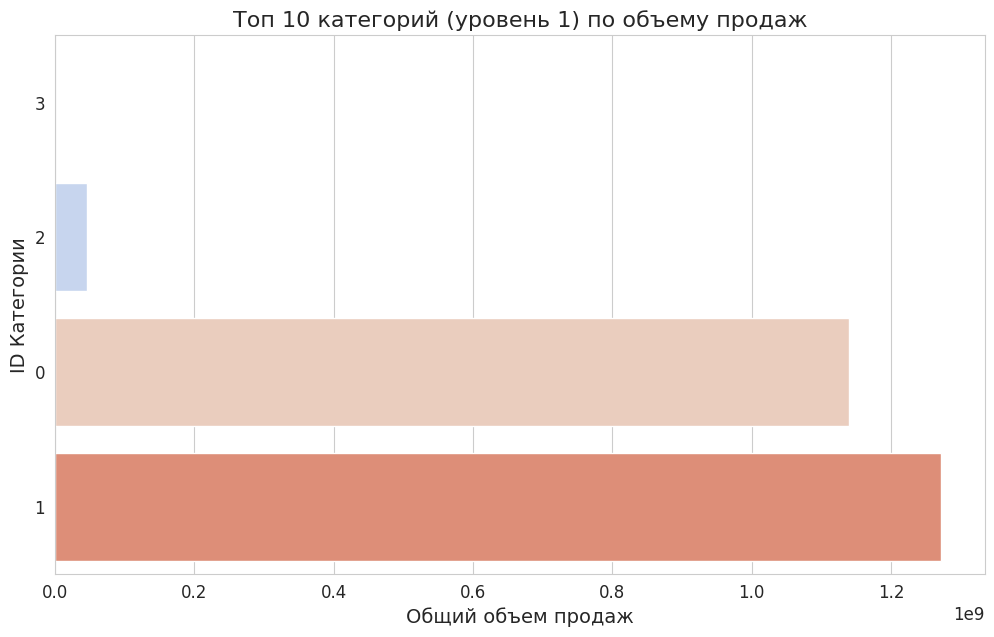

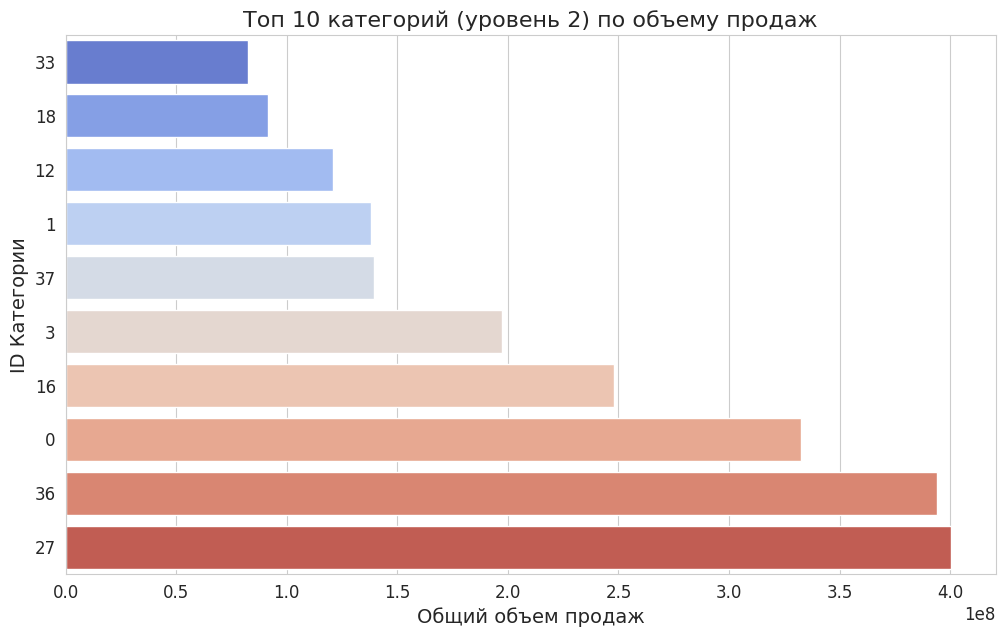

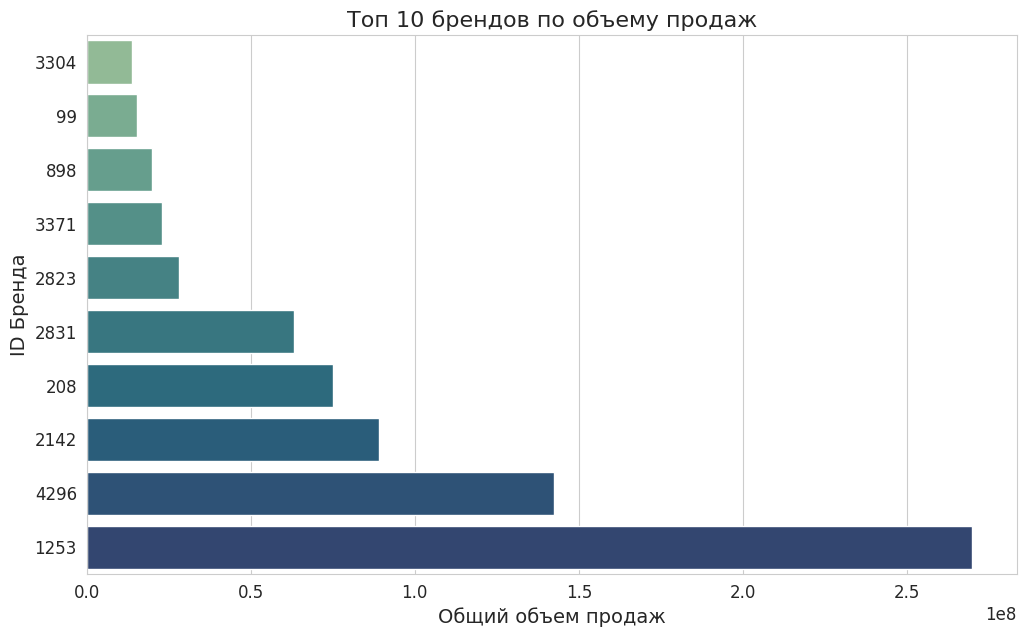

In [10]:
# Текстовый вывод для разных уровней категорий
category_levels = ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey']
for level_col in category_levels:
    if level_col in full_df.columns:
        product_category_summary = full_df.groupby([level_col], observed=True).agg(
            total_qnt_sold=('Qnt', 'sum'),
            total_amount_sales=('Amount', 'sum')
        ).sort_values(by='total_amount_sales', ascending=False).head(10)
        print(f"\nТоп 10 категорий ({level_col}) по объему продаж:")
        print(product_category_summary)
    else:
        print(f"Колонка '{level_col}' не найдена для категорий.")

plot_top_categories_brands(full_df.copy())

In [11]:
def plot_alco_self_brand_flags(df):
    """Визуализация продаж по алкоголю и собственной торговой марке."""

    if 'alco_flag' in df.columns and 'Amount' in df.columns:
        alco_sales = df.groupby('alco_flag', observed=True)['Amount'].sum().reset_index()
        if not alco_sales.empty:
            alco_sales['alco_flag'] = alco_sales['alco_flag'].map({0: 'Неалкоголь', 1: 'Алкоголь'})
            plt.figure(figsize=(8, 6))
            sns.barplot(x='alco_flag', y='Amount', data=alco_sales, palette='Paired', hue='alco_flag', legend=False)
            plt.title('Объем продаж: Алкоголь vs. Неалкоголь')
            plt.xlabel('')
            plt.ylabel('Объем продаж')
            plt.show()
        else:
            print("Недостаточно данных для построения графика по алкоголю.")
    else:
        print("Колонки 'alco_flag' или 'Amount' не найдены.")

    if 'self_brand_flag' in df.columns and 'Amount' in df.columns:
        self_brand_sales = df.groupby('self_brand_flag', observed=True)['Amount'].sum().reset_index()
        if not self_brand_sales.empty:
            self_brand_sales['self_brand_flag'] = self_brand_sales['self_brand_flag'].map({0: 'Другие бренды', 1: 'Собственная ТМ'})
            plt.figure(figsize=(8, 6))
            sns.barplot(x='self_brand_flag', y='Amount', data=self_brand_sales, palette='Paired', hue='self_brand_flag', legend=False)
            plt.title('Объем продаж: Собственная ТМ vs. Другие бренды')
            plt.xlabel('')
            plt.ylabel('Объем продаж')
            plt.show()
        else:
            print("Недостаточно данных для построения графика по собственной ТМ.")
    else:
        print("Колонки 'self_brand_flag' или 'Amount' не найдены.")



Покупки алкоголя (0 - неалкоголь, 1 - алкоголь):
           total_amount_sales  num_transactions  avg_qnt_per_transaction
alco_flag                                                               
0               2366456566.00           9221748                     1.00
1                 91662058.00            499577                     1.00

Покупки собственной торговой марки (0 - нет, 1 - да):
                 total_amount_sales  num_transactions  avg_qnt_per_transaction
self_brand_flag                                                               
0                     2240205242.00           8982935                     1.00
1                      217913382.00           4371495                     1.00


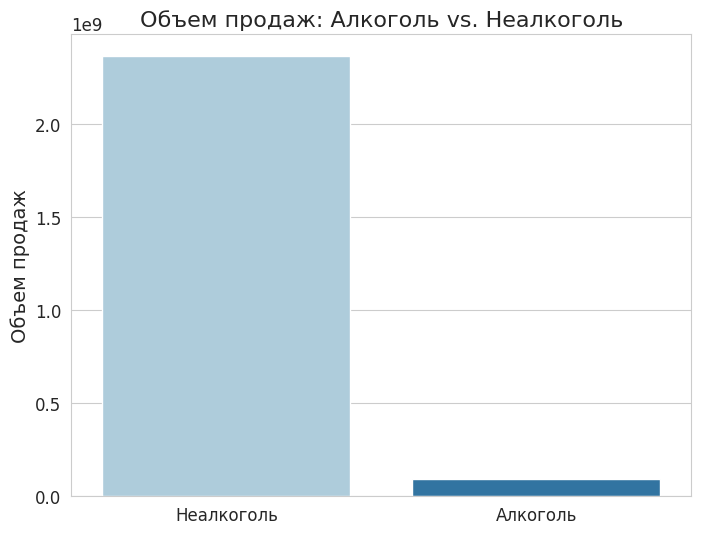

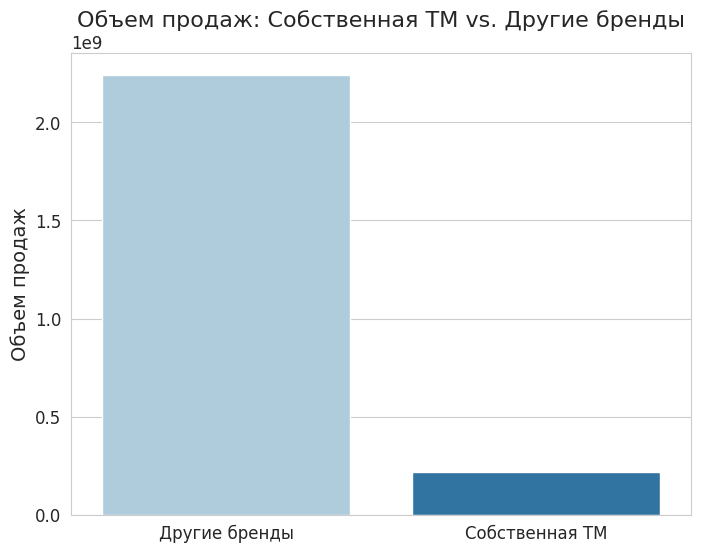

In [12]:
if 'alco_flag' in full_df.columns:
    alco_summary = full_df.groupby('alco_flag', observed=True).agg(
        total_amount_sales=('Amount', 'sum'),
        num_transactions=('Purchase_ID', 'nunique'),
        avg_qnt_per_transaction=('Qnt', 'mean')
    )
    print("\nПокупки алкоголя (0 - неалкоголь, 1 - алкоголь):")
    print(alco_summary)
else:
    print("Колонка 'alco_flag' не найдена для анализа.")

if 'self_brand_flag' in full_df.columns:
    self_brand_summary = full_df.groupby('self_brand_flag', observed=True).agg(
        total_amount_sales=('Amount', 'sum'),
        num_transactions=('Purchase_ID', 'nunique'),
        avg_qnt_per_transaction=('Qnt', 'mean')
    )
    print("\nПокупки собственной торговой марки (0 - нет, 1 - да):")
    print(self_brand_summary)
else:
    print("Колонка 'self_brand_flag' не найдена для анализа.")

plot_alco_self_brand_flags(full_df.copy())


In [13]:
def plot_time_series_analysis(df):
    """Визуализация временных рядов продаж."""

    if 'Opetation_datetime' not in df.columns or 'Amount' not in df.columns:
        print("Колонки 'Opetation_datetime' или 'Amount' не найдены для временного анализа.")
        return

    df_plot = df.copy()

    df_plot['hour_of_day'] = df_plot['Opetation_datetime'].dt.hour
    hourly_sales = df_plot.groupby('hour_of_day', observed=True)['Amount'].sum()
    if not hourly_sales.empty:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o', color='purple')
        plt.title('Объем продаж по часам дня')
        plt.xlabel('Час дня')
        plt.ylabel('Объем продаж')
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("Нет данных для построения почасового графика продаж.")

    df_plot['day_of_week'] = df_plot['Opetation_datetime'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_sales = df_plot.groupby('day_of_week', observed=True)['Amount'].sum().reindex(day_order)
    if not daily_sales.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x=daily_sales.index, y=daily_sales.values, palette='Blues_d', hue=daily_sales.index, legend=False)
        plt.title('Объем продаж по дням недели')
        plt.xlabel('День недели')
        plt.ylabel('Объем продаж')
        plt.show()
    else:
        print("Нет данных для построения графика продаж по дням недели.")

    df_plot['month_year'] = df_plot['Opetation_datetime'].dt.to_period('M').astype(str)
    monthly_sales = df_plot.groupby('month_year', observed=True)['Amount'].sum().sort_index()
    if not monthly_sales.empty:
        plt.figure(figsize=(15, 7))
        sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', color='darkgreen')
        plt.title('Динамика продаж по месяцам')
        plt.xlabel('Месяц и Год')
        plt.ylabel('Объем продаж')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("Нет данных для построения ежемесячного графика продаж")

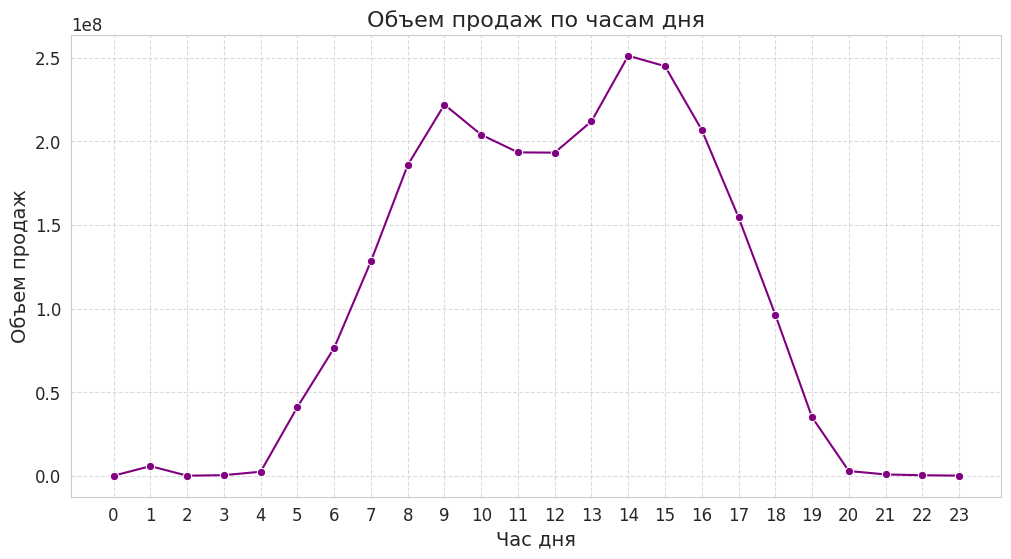

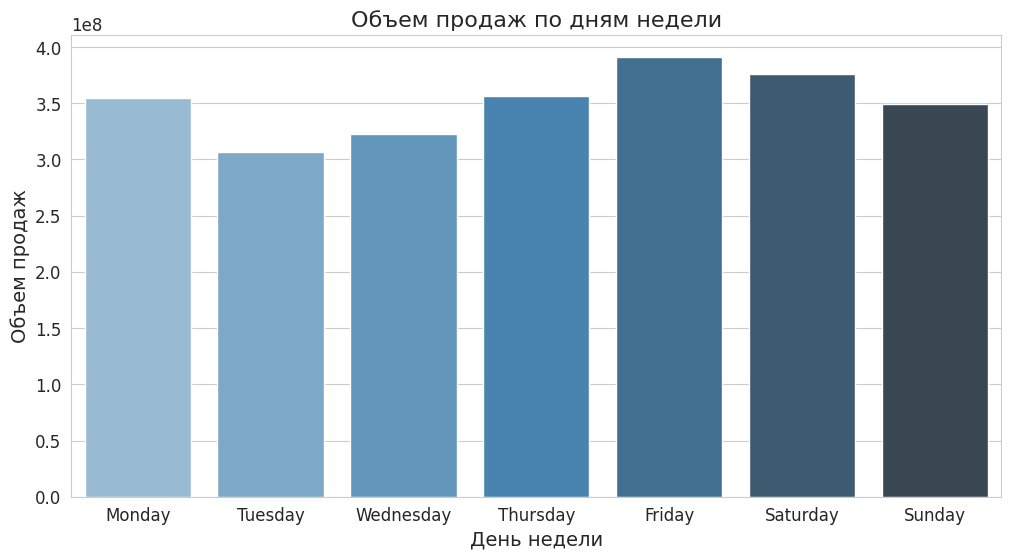

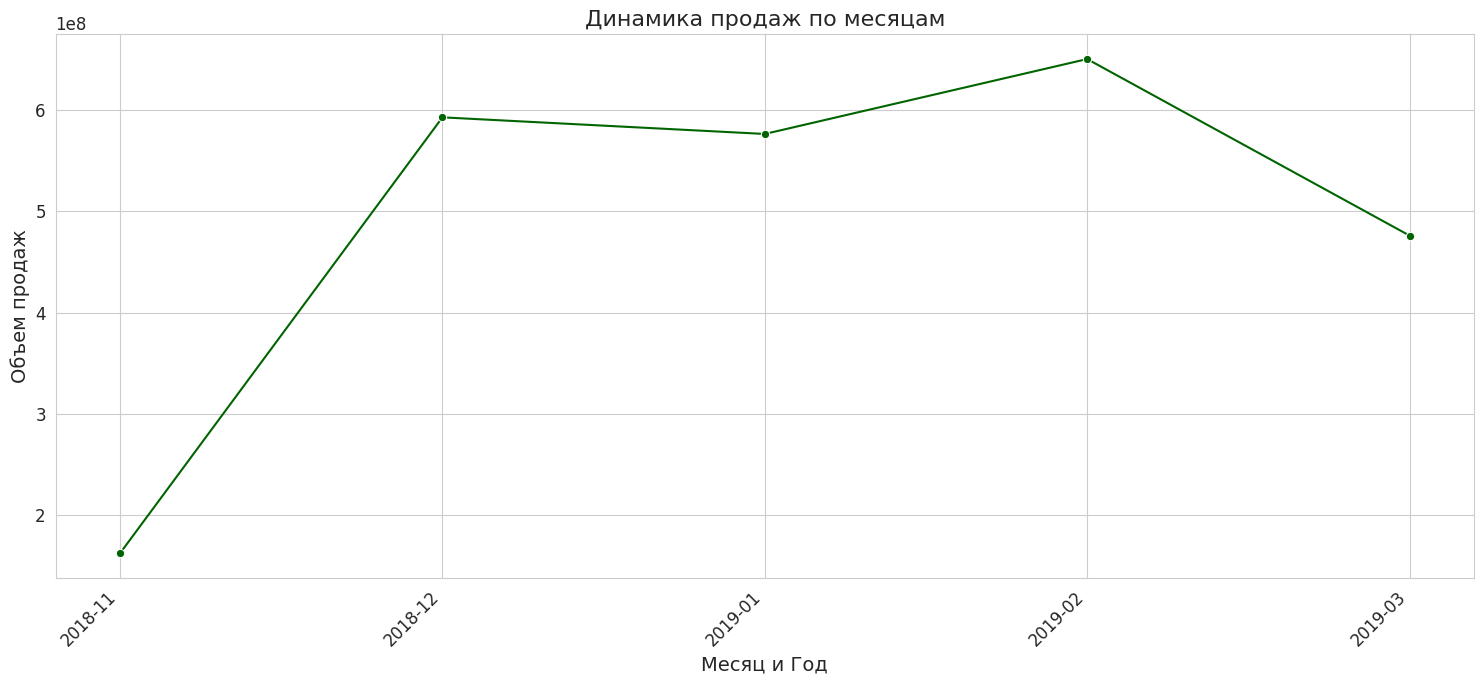

In [14]:
plot_time_series_analysis(full_df.copy())

In [15]:
def plot_loyalty_program_analysis(df):
    """Визуализация использования баллов программы лояльности."""

    required_cols = ['toCard_stand', 'fromCard_stand', 'Amount_Cheque', 'Purchase_ID']
    if not all(col in df.columns for col in required_cols):
        print(f"Недостаточно колонок для анализа программы лояльности. Требуются: {required_cols}")
        return

    cheque_points_summary = df.groupby('Purchase_ID', observed=True).agg(
        total_gained_points=('toCard_stand', 'sum'),
        total_spent_points=('fromCard_stand', 'sum'),
        cheque_amount=('Amount_Cheque', 'first')
    ).reset_index()

    if cheque_points_summary.empty:
        print("Нет данных о баллах для построения графиков лояльности.")
        return

    gained_points_positive = cheque_points_summary['total_gained_points'][cheque_points_summary['total_gained_points'] > 0]
    if not gained_points_positive.empty:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(gained_points_positive, bins=30, kde=True, color='teal')
        plt.title('Распределение начисленных стандартных баллов за чек (>0)')
        plt.xlabel('Начислено баллов')
        plt.ylabel('Количество чеков')
    else:
        print("Нет начисленных баллов (>0) для построения гистограммы.")

    spent_points_abs = cheque_points_summary['total_spent_points'].abs()
    spent_points_positive_abs = spent_points_abs[spent_points_abs > 0]

    if not spent_points_positive_abs.empty:
        if gained_points_positive.empty:
             plt.figure(figsize=(14, 6)) # Отдельный график, если начислений нет
             sns.histplot(spent_points_positive_abs, bins=30, kde=True, color='brown')
             plt.title('Распределение списанных стандартных баллов за чек (величина списания >0)')
             plt.xlabel('Списано баллов (абс. значение)')
             plt.ylabel('Количество чеков')
        else:
            plt.subplot(1, 2, 2) # На том же графике, если начисления есть
            sns.histplot(spent_points_positive_abs, bins=30, kde=True, color='brown')
            plt.title('Распределение списанных стандартных баллов за чек (величина списания >0)')
            plt.xlabel('Списано баллов (абс. значение)')
            plt.ylabel('Количество чеков')
        plt.tight_layout()
        plt.show()
    else:
        print("Нет списанных баллов (абс. значение >0) для построения гистограммы.")


    filtered_cheque_points = cheque_points_summary[
        (cheque_points_summary['cheque_amount'] > 0) &
        (cheque_points_summary['total_gained_points'] > 0)
    ]
    if not filtered_cheque_points.empty:
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x='cheque_amount', y='total_gained_points', data=filtered_cheque_points, alpha=0.5, color='green')
        plt.title('Сумма чека vs. Начисленные баллы (только положительные значения)')
        plt.xlabel('Сумма чека')
        plt.ylabel('Начислено стандартных баллов')
        plt.show()
    else:
        print("Нет подходящих данных для построения точечной диаграммы баллов и суммы чека (возможно, все значения нулевые или отрицательные).")


Общее начисление/списание баллов:
                       toCard_stand  toCard_short  fromCard_stand  fromCard_short
total_to_card_stand    273340215.50           NaN             NaN             NaN
total_to_card_short             NaN    2325300.00             NaN             NaN
total_from_card_stand           NaN           NaN   -185276432.00             NaN
total_from_card_short           NaN           NaN             NaN    -12760189.00


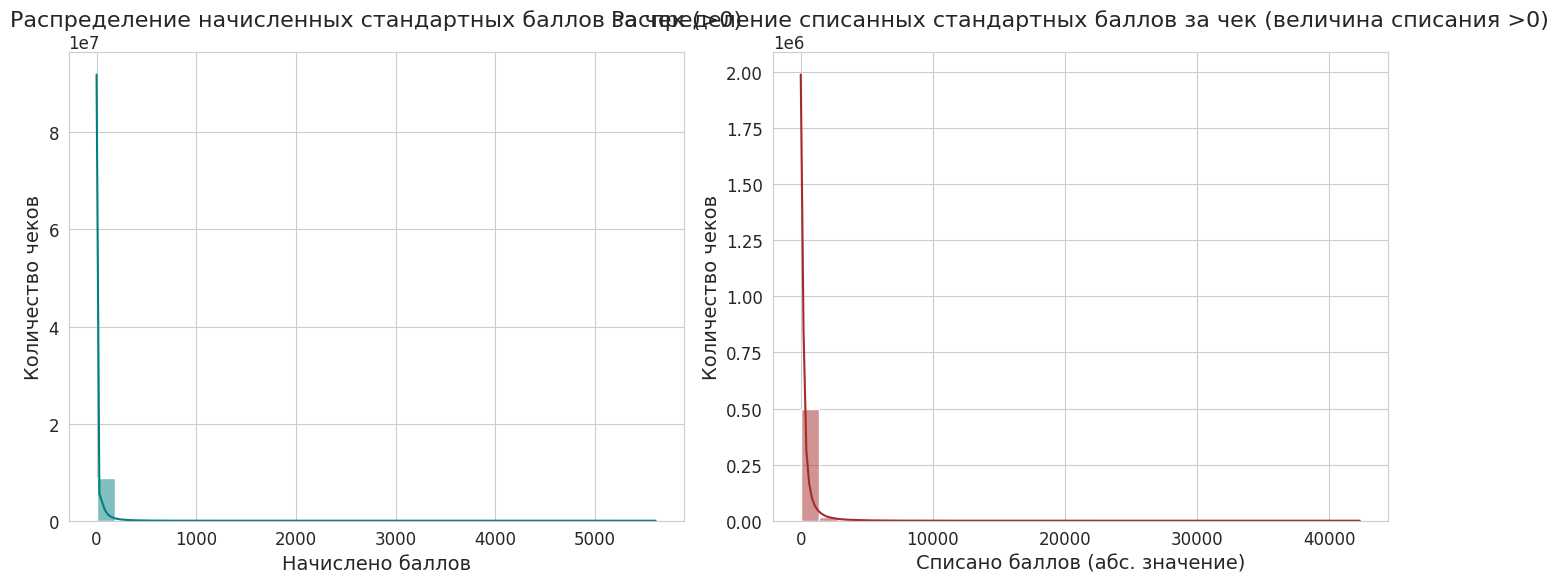

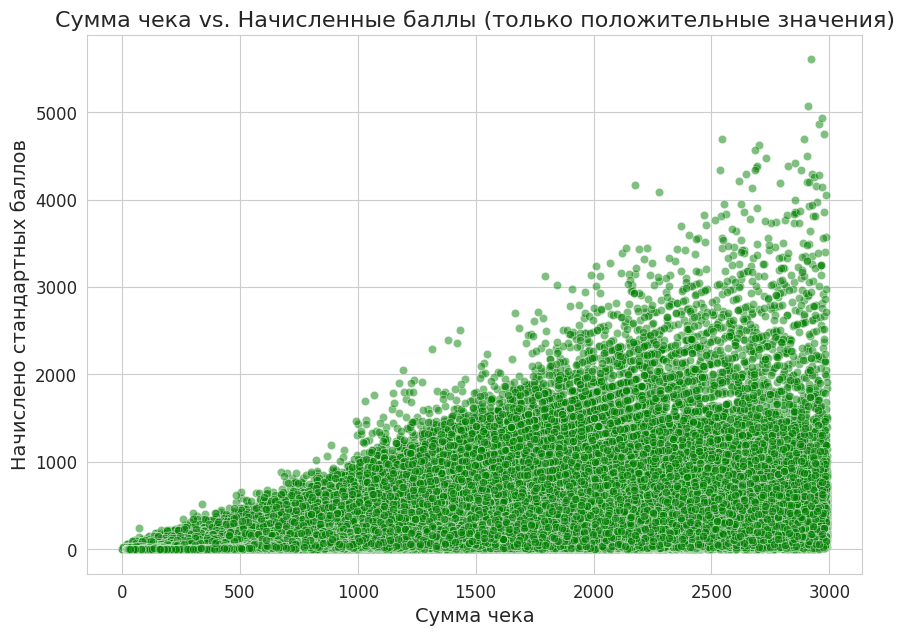

In [16]:
if all(col in full_df.columns for col in ['toCard_stand', 'toCard_short', 'fromCard_stand', 'fromCard_short']):
    points_summary = full_df.agg(
        total_to_card_stand=('toCard_stand', 'sum'),
        total_to_card_short=('toCard_short', 'sum'),
        total_from_card_stand=('fromCard_stand', 'sum'),
        total_from_card_short=('fromCard_short', 'sum')
    )
    print("\nОбщее начисление/списание баллов:")
    print(points_summary)
else:
    print("Недостаточно колонок для общего анализа баллов.")
plot_loyalty_program_analysis(full_df.copy())

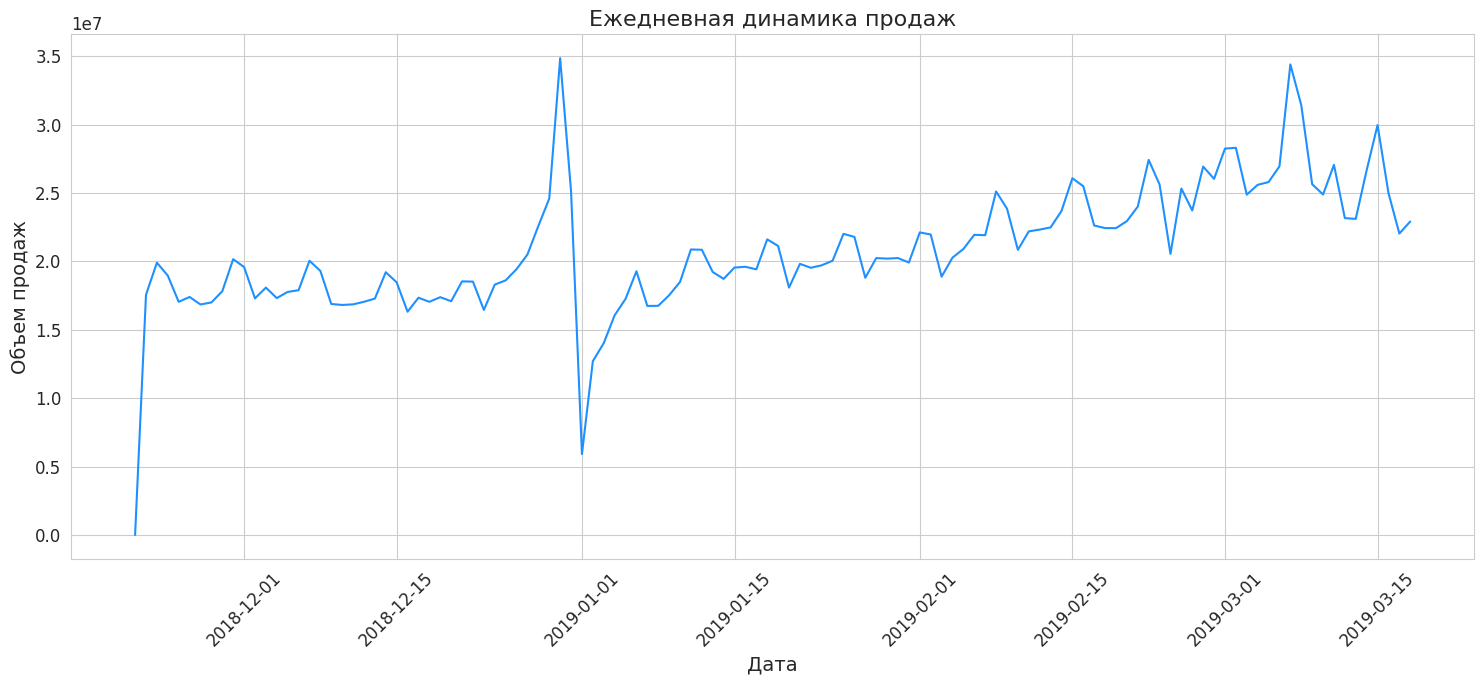

In [17]:
# 1. Динамика общих продаж за все время
if 'Opetation_datetime' in full_df.columns and 'Amount' in full_df.columns:
    df_for_plot = full_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_for_plot['Opetation_datetime']):
        df_for_plot['Opetation_datetime'] = pd.to_datetime(df_for_plot['Opetation_datetime'])

    df_for_plot['purchase_date'] = df_for_plot['Opetation_datetime'].dt.to_period('D')
    daily_sales = df_for_plot.groupby('purchase_date', observed=True)['Amount'].sum().to_timestamp() # Добавил observed=True
    if not daily_sales.empty:
        plt.figure(figsize=(15, 7))
        sns.lineplot(x=daily_sales.index, y=daily_sales.values, color='dodgerblue')
        plt.title('Ежедневная динамика продаж')
        plt.xlabel('Дата')
        plt.ylabel('Объем продаж')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Нет данных для построения ежедневной динамики продаж.")
else:
    print("Недостаточно колонок для динамики продаж (нужны 'Opetation_datetime', 'Amount').")

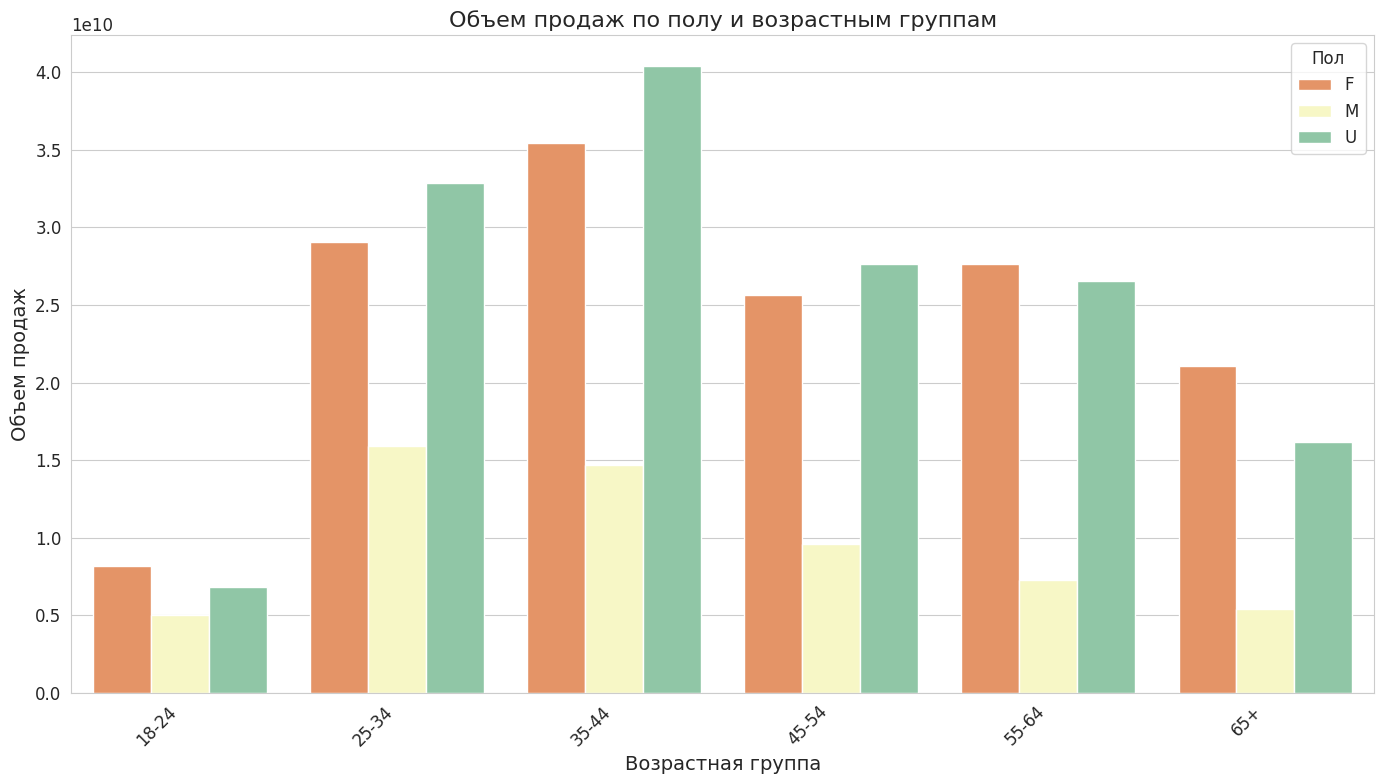

In [18]:
# 2. Продажи по половозрастным группам (пример)
if ('Age' in person_df_original.columns and 'Gend' in person_df_original.columns and
    'Person_BKEY' in full_df.columns and 'Amount' in full_df.columns):

    sales_by_person = full_df.groupby('Person_BKEY', observed=True)['Amount'].sum().reset_index()
    person_demog_sales = pd.merge(full_df.copy(), sales_by_person, on='Person_BKEY', how='left')
    person_demog_sales['Amount_y'] = person_demog_sales['Amount_y'].fillna(0)

    bins = [18, 25, 35, 45, 55, 65, np.inf]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    person_demog_sales['Age_Group'] = pd.cut(person_demog_sales['Age'], bins=bins, labels=labels, right=False)

    gender_age_sales = person_demog_sales.groupby(['Gend', 'Age_Group'], observed=True)['Amount_y'].sum().unstack()

    genders_present = list(gender_age_sales.index.unique())
    ordered_genders = ['F', 'M', 'U']
    genders_for_loc = [g for g in ordered_genders if g in genders_present]

    gender_age_sales = gender_age_sales.reindex(genders_for_loc).fillna(0)

    if not gender_age_sales.empty:
        plt.figure(figsize=(14, 8))
        gender_age_sales_melted = gender_age_sales.stack().reset_index()
        gender_age_sales_melted.columns = ['Gend', 'Age_Group', 'Amount_y']

        sns.barplot(data=gender_age_sales_melted, x='Age_Group', y='Amount_y', hue='Gend', palette='Spectral')
        plt.title('Объем продаж по полу и возрастным группам')
        plt.xlabel('Возрастная группа')
        plt.ylabel('Объем продаж')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Пол')
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для построения графика продаж по половозрастным группам после агрегации.")
else:
    print("Недостаточно колонок для анализа продаж по половозрастным группам (нужны 'Age', 'Gend' в person_original_df и 'Person_BKEY', 'Amount' в df).")

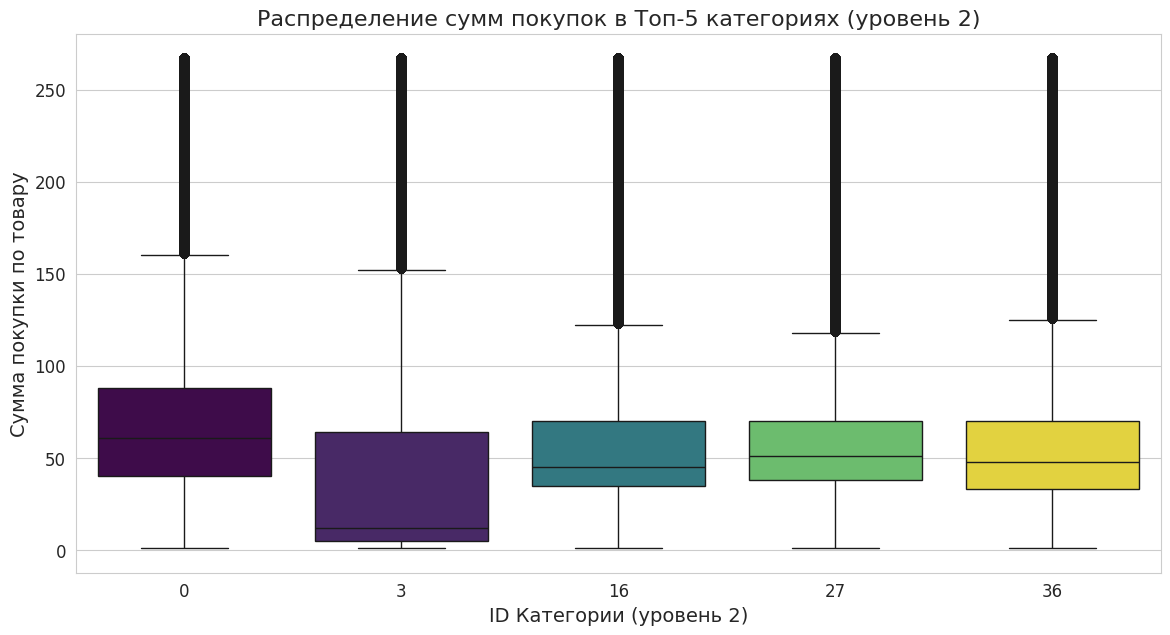

In [19]:
# 3. Топ 5 категорий по продажам (уровень 2, для большей детализации)
if 'cat_lev_02_bkey' in full_df.columns and 'Amount' in full_df.columns:
    top_5_cat_lev_02 = full_df.groupby('cat_lev_02_bkey', observed=True)['Amount'].sum().nlargest(5).index
    df_top_cat_lev_02 = full_df[full_df['cat_lev_02_bkey'].isin(top_5_cat_lev_02)].copy()

    if not df_top_cat_lev_02.empty:
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='cat_lev_02_bkey', y='Amount', data=df_top_cat_lev_02, palette='viridis', hue='cat_lev_02_bkey', legend=False)
        plt.title('Распределение сумм покупок в Топ-5 категориях (уровень 2)')
        plt.xlabel('ID Категории (уровень 2)')
        plt.ylabel('Сумма покупки по товару')
        plt.show()
    else:
        print("Нет данных для построения boxplot для топ-5 категорий.")
else:
    print("Недостаточно колонок для анализа топ-5 категорий (нужны 'cat_lev_02_bkey', 'Amount').")

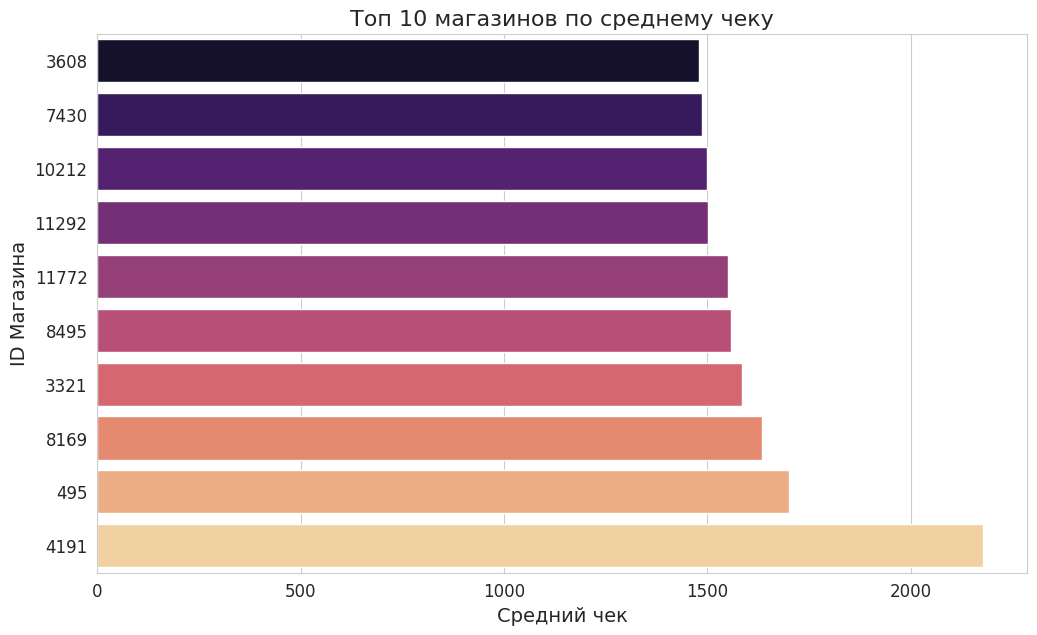

In [20]:
# 4. Распределение среднего чека по магазинам
if 'Merchant_id' in full_df.columns and 'Amount_Cheque' in full_df.columns:
    merchant_avg_cheque = full_df.groupby('Merchant_id', observed=True)['Amount_Cheque'].mean().nlargest(10).sort_values(ascending=True)
    if not merchant_avg_cheque.empty:
        plt.figure(figsize=(12, 7))
        sns.barplot(x=merchant_avg_cheque.values, y=merchant_avg_cheque.index.astype(str), palette='magma', hue=merchant_avg_cheque.index.astype(str), legend=False)
        plt.title('Топ 10 магазинов по среднему чеку')
        plt.xlabel('Средний чек')
        plt.ylabel('ID Магазина')
        plt.show()
    else:
        print("Нет данных для построения графика среднего чека по магазинам.")
else:
    print("Недостаточно колонок для анализа среднего чека по магазинам (нужны 'Merchant_id', 'Amount_Cheque').")

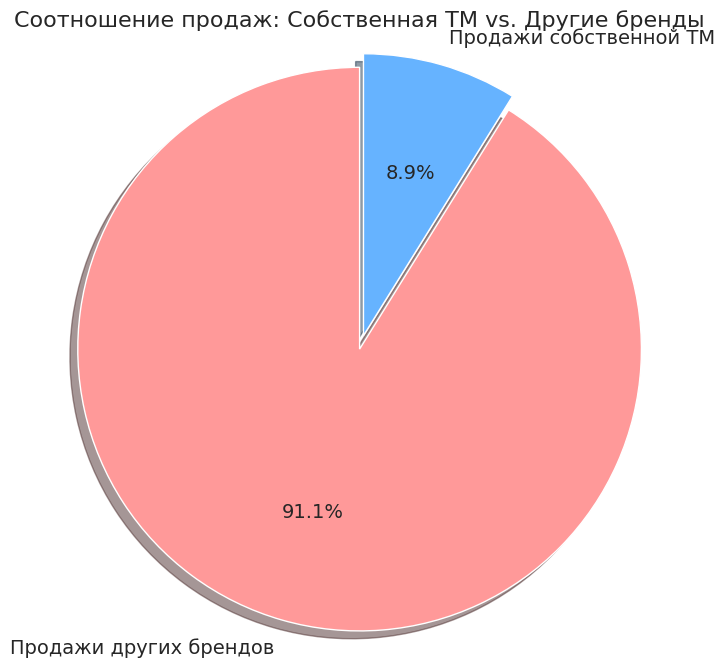

In [21]:
# 5. Соотношение продаж собственных ТМ к другим брендам
if 'self_brand_flag' in full_df.columns and 'Amount' in full_df.columns:
    self_brand_ratio = full_df.groupby('self_brand_flag', observed=True)['Amount'].sum()
    if 0 in self_brand_ratio.index and 1 in self_brand_ratio.index and not self_brand_ratio.empty:
        labels = ['Продажи других брендов', 'Продажи собственной ТМ']
        sizes = [self_brand_ratio[0], self_brand_ratio[1]]
        colors = ['#ff9999','#66b3ff']
        explode = (0.05, 0)

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=90, textprops={'fontsize': 14})
        plt.axis('equal')
        plt.title('Соотношение продаж: Собственная ТМ vs. Другие бренды', fontsize=16)
        plt.show()
    else:
        print("Недостаточно данных для построения круговой диаграммы по собственной ТМ (отсутствуют обе категории или данные пусты).")
else:
    print("Недостаточно колонок для анализа соотношения продаж собственной ТМ (нужны 'self_brand_flag', 'Amount').")

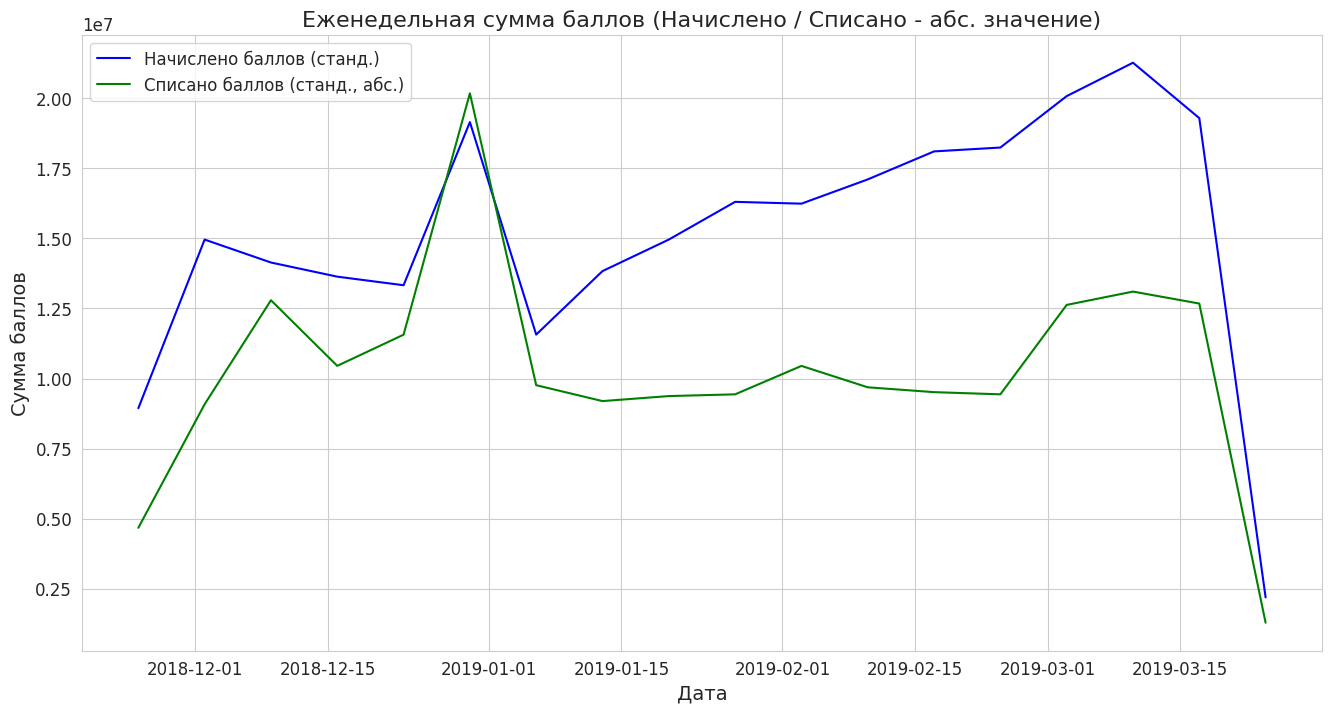

In [5]:
# Агрегируем toCard_stand_sum, и ABS(fromCard_stand_sum)
df_weekly = full_df.set_index('Opetation_datetime').resample('W').agg(
    toCard_stand_sum=('toCard_stand', 'sum'),
    fromCard_stand_sum_abs=('fromCard_stand', lambda x: x.abs().sum()), # ИЗМЕНЕНО: Сумма абсолютных значений для fromCard_stand
    total_amount_sum=('Amount', 'sum'),
    num_transactions=('Purchase_ID', 'nunique'),
    num_customers=('Person_BKEY', 'nunique')
).reset_index()

# --- ВИЗУАЛИЗАЦИЯ ДЛЯ ОТЛАДКИ Z-SCORE ---
plt.figure(figsize=(16, 8))
plt.plot(df_weekly['Opetation_datetime'], df_weekly['toCard_stand_sum'], label='Начислено баллов (станд.)', color='blue')
plt.plot(df_weekly['Opetation_datetime'], df_weekly['fromCard_stand_sum_abs'], label='Списано баллов (станд., абс.)', color='green')
plt.title('Еженедельная сумма баллов (Начислено / Списано - абс. значение)')
plt.xlabel('Дата')
plt.ylabel('Сумма баллов')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Ищем всплески
window_size = 3
threshold = 1.0

# Список метрик для анализа на всплески
metrics_for_spike_detection = ['toCard_stand_sum', 'fromCard_stand_sum_abs']

# Вычисляем Z-счет для каждой метрики
for metric in metrics_for_spike_detection:
    df_weekly[f'{metric}_zscore'] = zscore(df_weekly[metric])

detected_spikes_info = []
all_spikes_detected_by_metric = []

for col_to_analyze in metrics_for_spike_detection:
    spikes = df_weekly[df_weekly[f'{col_to_analyze}_zscore'].abs() > threshold].copy()

    spikes['spike_zscore'] = spikes[f'{col_to_analyze}_zscore']

    if not spikes.empty:
        print(f"Обнаружены всплески по метрике '{col_to_analyze}':")
        print(spikes[['Opetation_datetime', col_to_analyze, f'{col_to_analyze}_zscore']])
        all_spikes_detected_by_metric.append((col_to_analyze, spikes))
    else:
        print(f"Всплески по метрике '{col_to_analyze}' не обнаружены с порогом Z-счета > {threshold}.")

Обнаружены всплески по метрике 'toCard_stand_sum':
   Opetation_datetime  toCard_stand_sum  toCard_stand_sum_zscore
0          2018-11-25        8939452.00                    -1.42
14         2019-03-03       20077712.40                     1.11
15         2019-03-10       21269929.30                     1.39
17         2019-03-24        2189078.80                    -2.96
Обнаружены всплески по метрике 'fromCard_stand_sum_abs':
   Opetation_datetime  fromCard_stand_sum_abs  fromCard_stand_sum_abs_zscore
0          2018-11-25              4671742.00                          -1.53
5          2018-12-30             20178220.00                           2.69
17         2019-03-24              1284497.00                          -2.45


In [7]:
# --- Формирование detected_info_list ---
for col_to_analyze, spikes_df in all_spikes_detected_by_metric:
    for _, spike_row in spikes_df.iterrows():
        spike_date = spike_row['Opetation_datetime']
        current_spike_info = {
            'spike_date': spike_date,
            'metric_name': col_to_analyze,
            'periods': {}
        }
        print(f"\n--- Анализ вокруг всплеска {col_to_analyze} на неделе {spike_date.strftime('%Y-%m-%d')} ---")

        before_end = spike_date - pd.Timedelta(seconds=1)
        before_start = before_end - pd.Timedelta(weeks=2) + pd.Timedelta(seconds=1)

        during_start = spike_date
        during_end = spike_date + pd.Timedelta(weeks=1) - pd.Timedelta(seconds=1)

        after_start = spike_date + pd.Timedelta(weeks=1)
        after_end = spike_date + pd.Timedelta(weeks=3) - pd.Timedelta(seconds=1)

        periods_config = {
            "До всплеска (2 недели)": (before_start, before_end),
            "Во время всплеска (1 неделя)": (during_start, during_end),
            "После всплеска (2 недели)": (after_start, after_end)
        }

        for period_name, (start_date_p, end_date_p) in periods_config.items():
            period_df = full_df[
                (full_df['Opetation_datetime'] >= start_date_p) &
                (full_df['Opetation_datetime'] <= end_date_p)
            ].copy()

            period_data = {'_period_start_date': start_date_p,
                           '_period_end_date': end_date_p}

            if period_df.empty:
                print(f"  {period_name}: Нет данных.")
                # Если данных нет, метрики будут 0 или NaN, но даты периода все равно сохраняем
                period_data['Общий объем продаж'] = 0
                period_data['Средний чек'] = np.nan
                period_data['Количество уникальных клиентов'] = 0
                period_data['Количество уникальных покупок'] = 0
                period_data['Среднее количество товаров в чеке'] = np.nan
                period_data['Начислено стандартных баллов'] = 0
                period_data['Списано стандартных баллов'] = 0
                current_spike_info['periods'][period_name] = period_data
                continue

            print(f"\n  {period_name}:")

            period_data['Общий объем продаж'] = period_df['Amount'].sum()
            period_data['Средний чек'] = period_df['Amount_Cheque'].mean() if 'Amount_Cheque' in period_df.columns else np.nan
            period_data['Количество уникальных клиентов'] = period_df['Person_BKEY'].nunique()
            period_data['Количество уникальных покупок'] = period_df['Purchase_ID'].nunique()
            period_data['Среднее количество товаров в чеке'] = period_df.groupby('Purchase_ID', observed=True)['Qnt'].sum().mean() if 'Qnt' in period_df.columns else np.nan

            period_data['Начислено стандартных баллов'] = period_df['toCard_stand'].sum()
            period_data['Списано стандартных баллов'] = period_df['fromCard_stand'].sum()

            print(f"    Общий объем продаж: {period_data['Общий объем продаж']:.2f}")
            print(f"    Средний чек: {period_data['Средний чек']:.2f}")
            print(f"    Количество уникальных клиентов: {period_data['Количество уникальных клиентов']}")
            print(f"    Количество уникальных покупок: {period_data['Количество уникальных покупок']}")
            print(f"    Среднее количество товаров в чеке: {period_data['Среднее количество товаров в чеке']:.2f}")
            print(f"    Начислено стандартных баллов: {period_data['Начислено стандартных баллов']:.2f}")
            print(f"    Списано стандартных баллов: {period_data['Списано стандартных баллов']:.2f}\n")

            # Текстовый вывод и сохранение топ-категорий для всех уровней
            category_levels_for_spike_analysis = ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey']
            for cat_level in category_levels_for_spike_analysis:
                if cat_level in period_df.columns:
                    top_categories = period_df.groupby(cat_level, observed=True)['Amount'].sum().nlargest(3)
                    if not top_categories.empty:
                        period_data[f'Топ-3 категории ({cat_level}) по продажам'] = top_categories
                        print(f"    Топ-3 категории ({cat_level}) по продажам: \n{top_categories.to_string()}\n")
                    else:
                        period_data[f'Топ-3 категории ({cat_level}) по продажам'] = pd.Series() # Пустая серия
                else:
                    period_data[f'Топ-3 категории ({cat_level}) по продажам'] = pd.Series() # Пустая серия, если колонка не существует

            if 'brand_bkey' in period_df.columns:
                top_brands = period_df.groupby('brand_bkey', observed=True)['Amount'].sum().nlargest(3)
                if not top_brands.empty:
                    period_data['Топ-3 бренда по продажам'] = top_brands
                    print(f"    Топ-3 бренда по продажам: \n{top_brands.to_string()}\n")
                else:
                    period_data['Топ-3 бренда по продажам'] = pd.Series() # Пустая серия
            else:
                period_data['Топ-3 бренда по продажам'] = pd.Series() # Пустая серия, если колонка не существует


            active_person_bkeys = period_df['Person_BKEY'].unique()
            if len(active_person_bkeys) > 0 and 'person' in data_storage and not data_storage['person'].empty:
                active_customers_demog = data_storage['person'][data_storage['person']['Person_BKEY'].isin(active_person_bkeys)].copy()
                if not active_customers_demog.empty:
                    avg_age = active_customers_demog['Age'].mean()
                    gender_dist = active_customers_demog['Gend'].value_counts(normalize=True) * 100
                    period_data['Средний возраст активных клиентов'] = avg_age
                    period_data['Распределение по полу активных клиентов'] = gender_dist.to_dict() # Сохраняем как словарь
                    print(f"    Средний возраст активных клиентов: {avg_age:.1f}")
                    print(f"    Распределение по полу активных клиентов:\n{gender_dist.to_string()}")
                else:
                    period_data['Средний возраст активных клиентов'] = np.nan
                    period_data['Распределение по полу активных клиентов'] = {}
            else:
                period_data['Средний возраст активных клиентов'] = np.nan
                period_data['Распределение по полу активных клиентов'] = {}


            current_spike_info['periods'][period_name] = period_data

        detected_spikes_info.append(current_spike_info)


--- Анализ вокруг всплеска toCard_stand_sum на неделе 2018-11-25 ---

  До всплеска (2 недели):
    Общий объем продаж: 56452131.00
    Средний чек: 640.91
    Количество уникальных клиентов: 153984
    Количество уникальных покупок: 216499
    Среднее количество товаров в чеке: 4.49
    Начислено стандартных баллов: 6918966.80
    Списано стандартных баллов: -3668736.00

    Топ-3 категории (cat_lev_01_bkey) по продажам: 
cat_lev_01_bkey
1   29376691.00
0   25956455.00
2    1116984.00

    Топ-3 категории (cat_lev_02_bkey) по продажам: 
cat_lev_02_bkey
27   9286012.00
36   8959973.00
0    6678616.00

    Топ-3 категории (cat_lev_03_bkey) по продажам: 
cat_lev_03_bkey
164   2964136.00
53    2872867.00
76    2523468.00

    Топ-3 категории (cat_lev_04_bkey) по продажам: 
cat_lev_04_bkey
248   1481356.00
206   1445473.00
413   1237788.00

    Топ-3 бренда по продажам: 
brand_bkey
1253   5707672.00
4296   2857718.00
2142   1953131.00

    Средний возраст активных клиентов: 47.9
    Распр

In [8]:
detected_spikes_info = [item for item in detected_spikes_info if item['spike_date'] != pd.Timestamp('2019-03-24 00:00:00')]

In [9]:
# Функция для построения графика категорий/брендов
def plot_category_brand_dynamics(data_before, data_during, data_after, title, xlabel):
    all_keys = pd.concat([data_before, data_during, data_after]).index.unique().tolist()

    df_plot = pd.DataFrame(index=all_keys)
    df_plot['До всплеска'] = df_plot.index.map(data_before).fillna(0)
    df_plot['Во время всплеска'] = df_plot.index.map(data_during).fillna(0)
    df_plot['После всплеска'] = df_plot.index.map(data_after).fillna(0)

    df_plot = df_plot.sort_values(by='Во время всплеска', ascending=False)

    ox = df_plot.plot(kind='bar', figsize=(14, 7), width=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Объем продаж')
    plt.xticks(rotation=45, ha='right')
    ox.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()


--- Анализ всплеска по 'toCard_stand_sum' на неделе 2018-11-25 ---


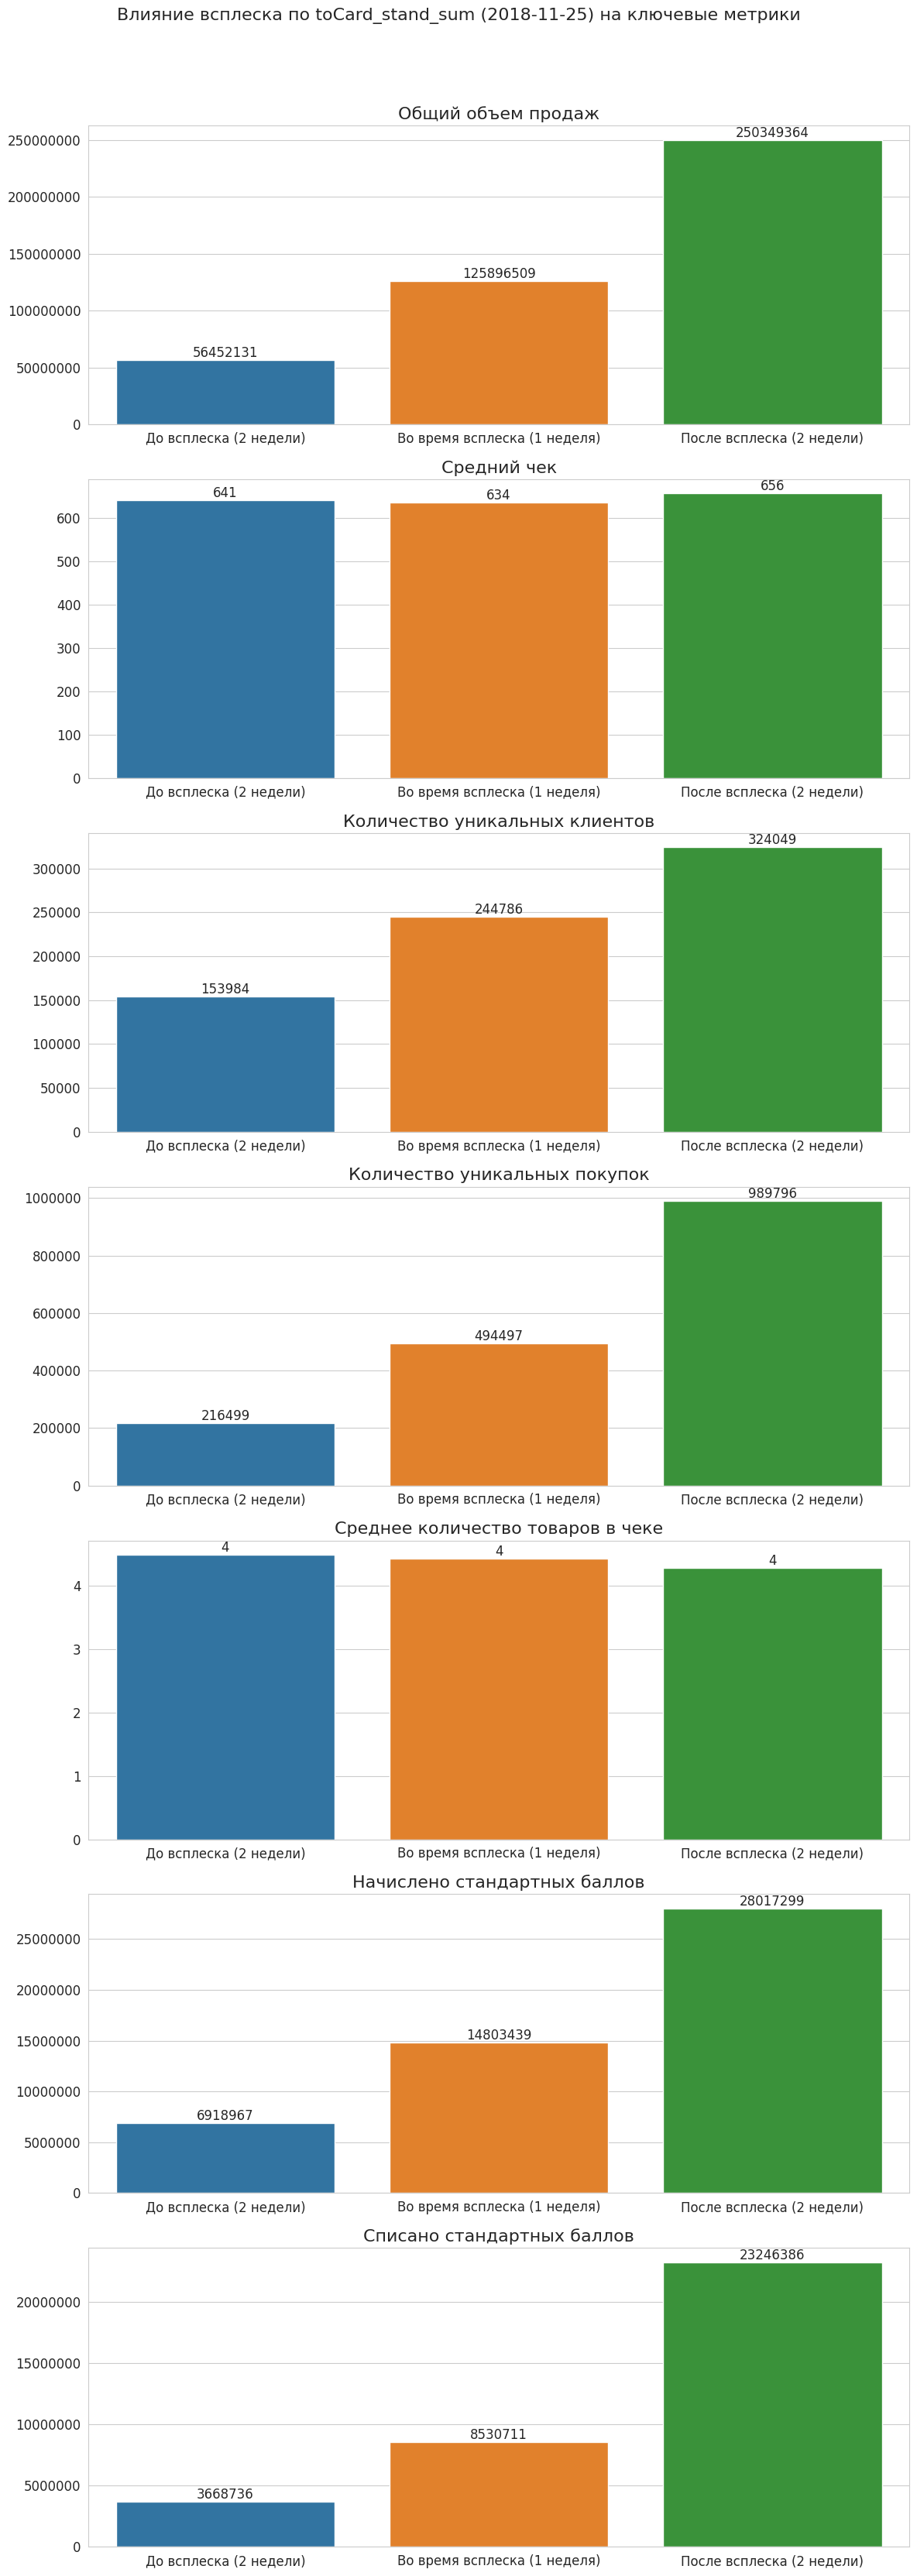


Изменения в Топ-категориях и Брендах для всплеска 2018-11-25:


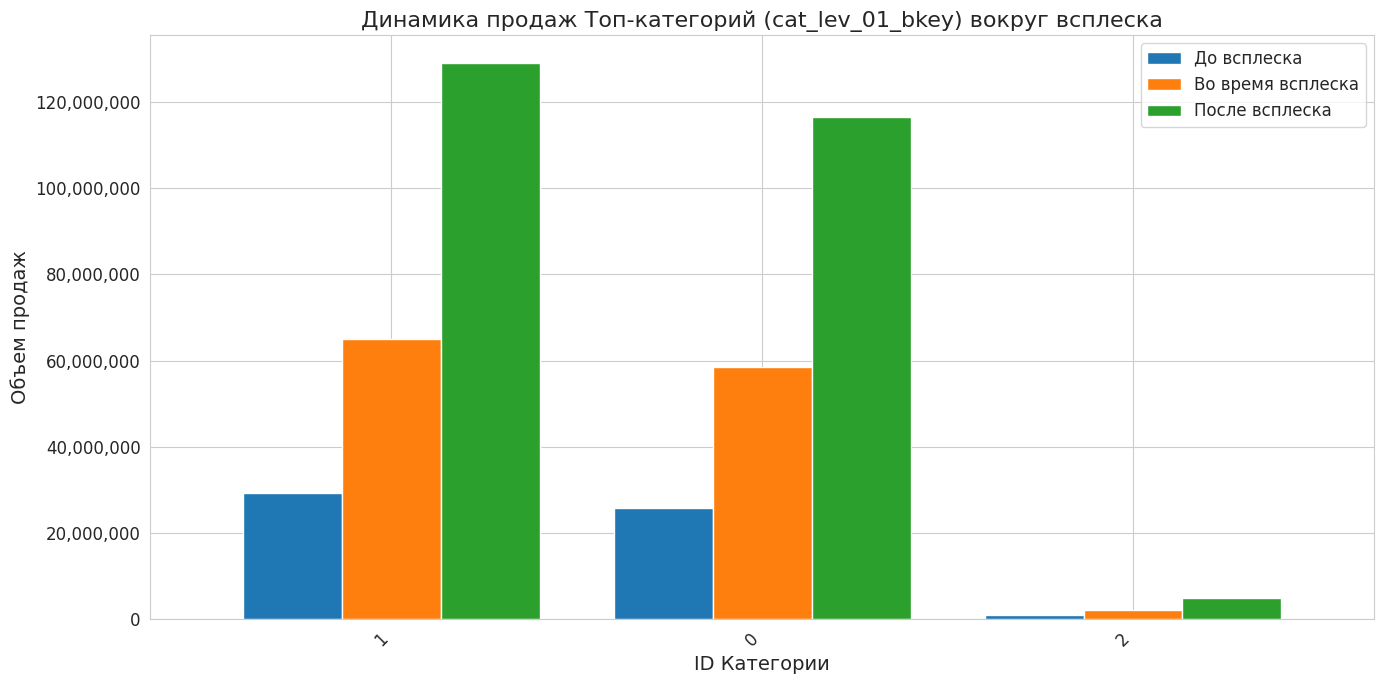

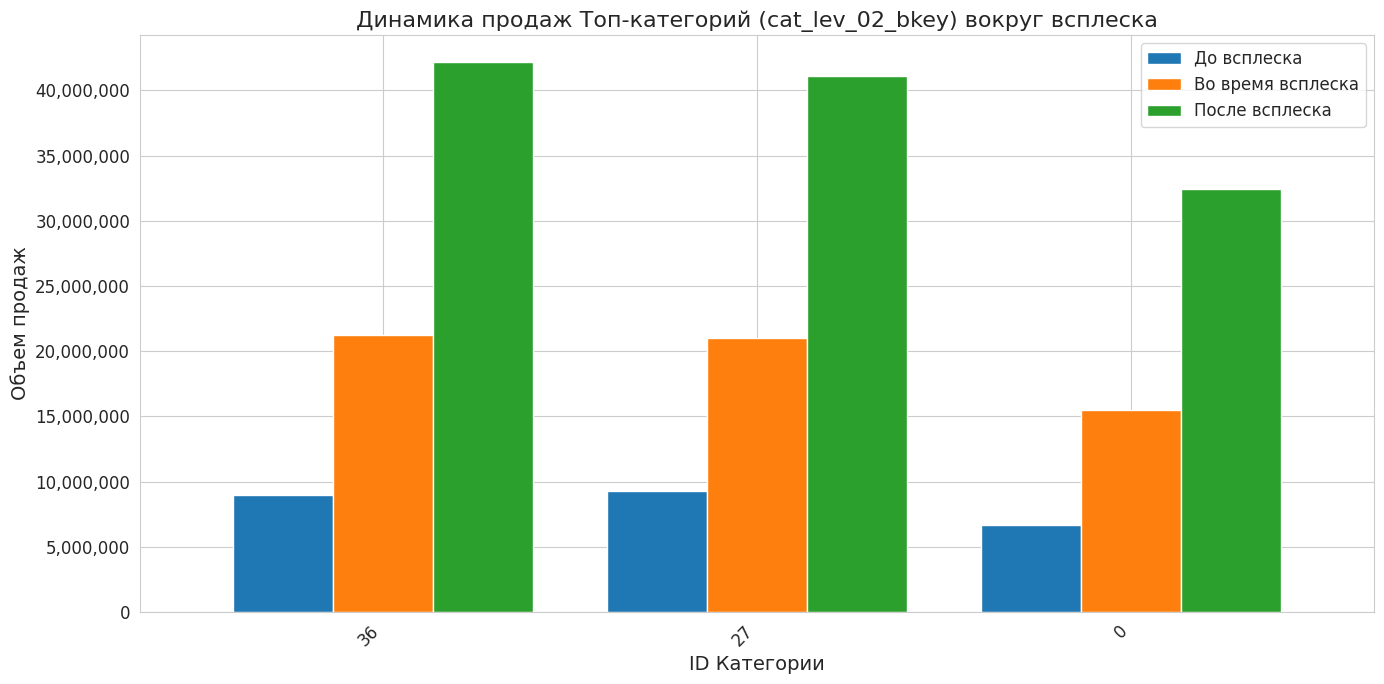

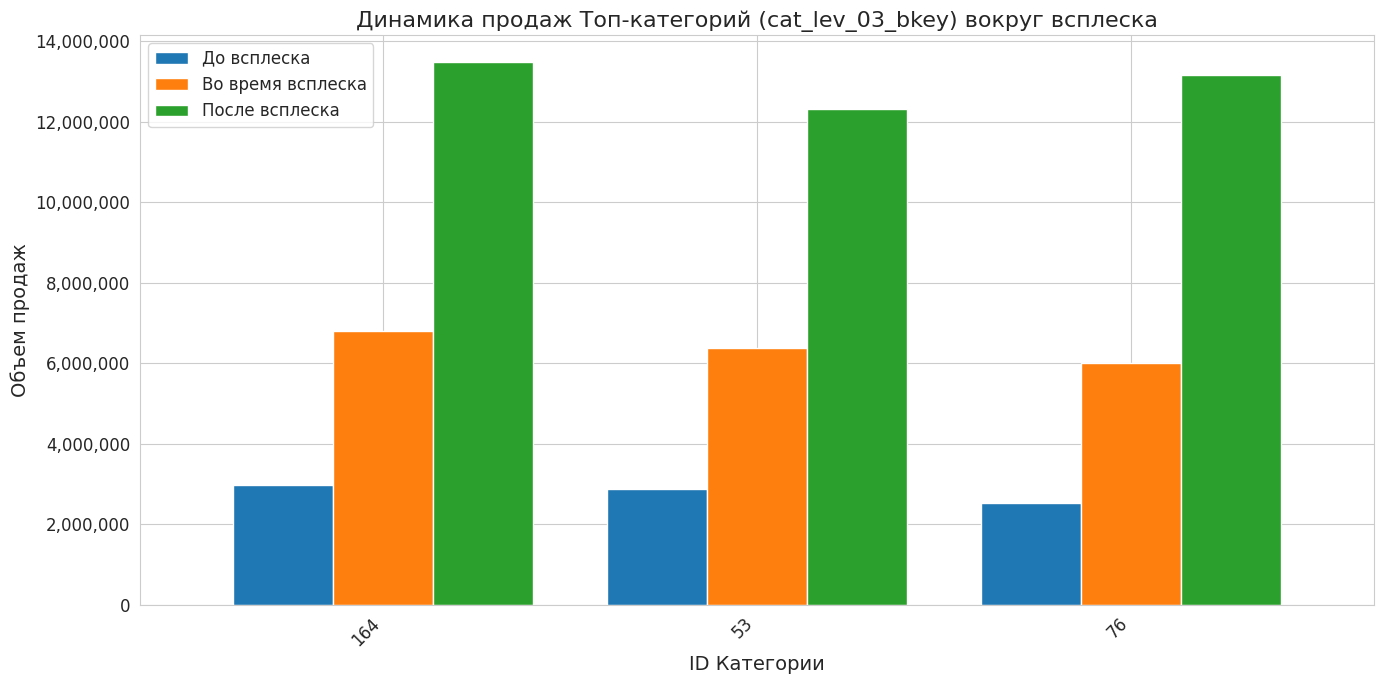

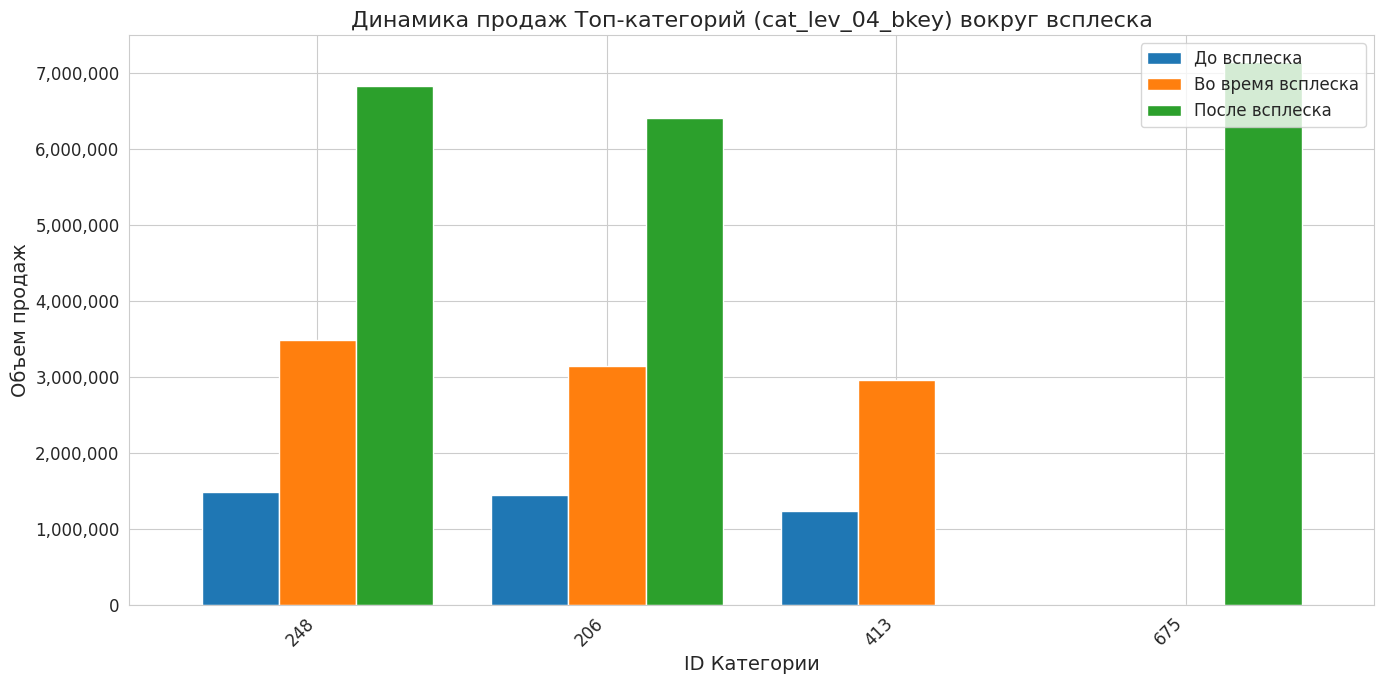

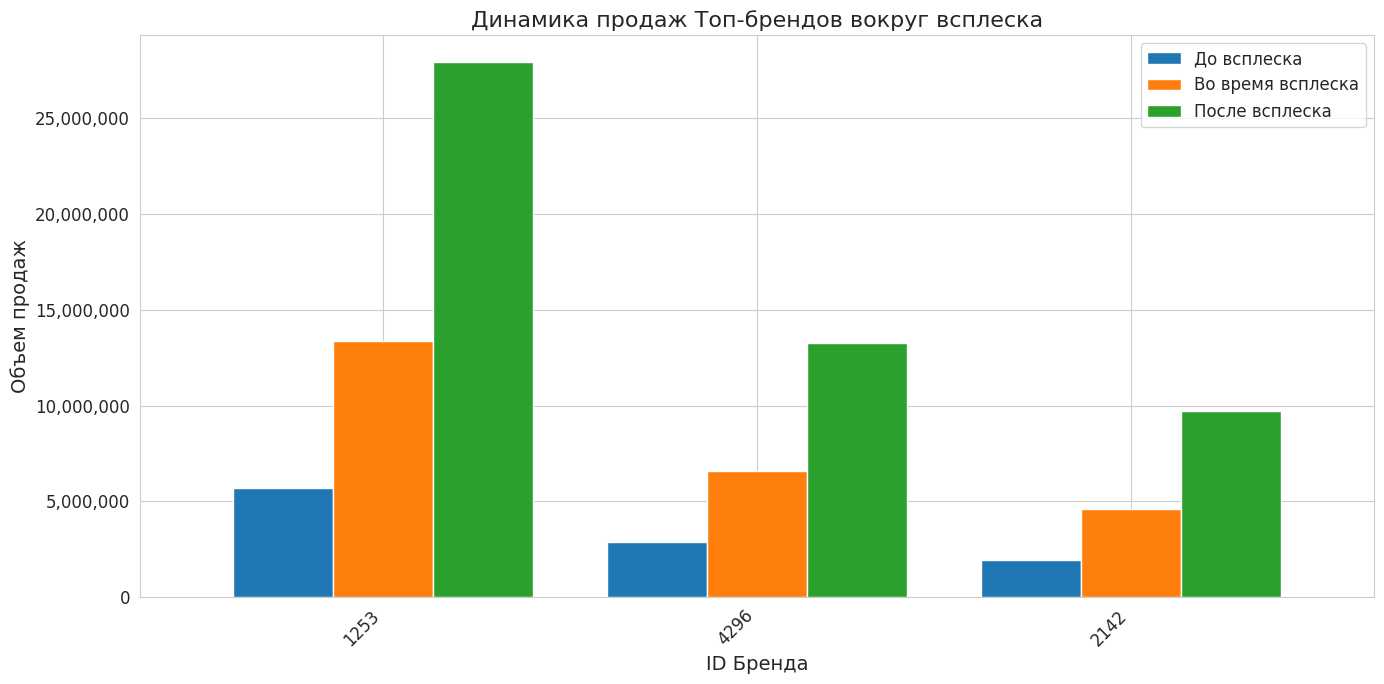


--- Анализ вернувшихся клиентов для всплеска 2018-11-25 ---
  Период для определения 'неактивных': 2018-08-12 - 2018-11-10
  Количество уникальных клиентов, которые были активны в период 'До всплеска': 153984
  Количество уникальных клиентов, которые были активны во время всплеска: 244786
  Количество уникальных клиентов, которые были активны после всплеска: 324049
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: 244786
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: 324049
  Из вернувшихся во время всплеска, сколько продолжили покупать и после: 209996

--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---
  Средний чек: До: 640.91, Во время: 634.41, После: 655.79
  Среднее количество товаров в чеке: До: 4.49, Во время: 4.43, После: 4.29

--- Анализ популярности товаров (Топ-10) для вспле

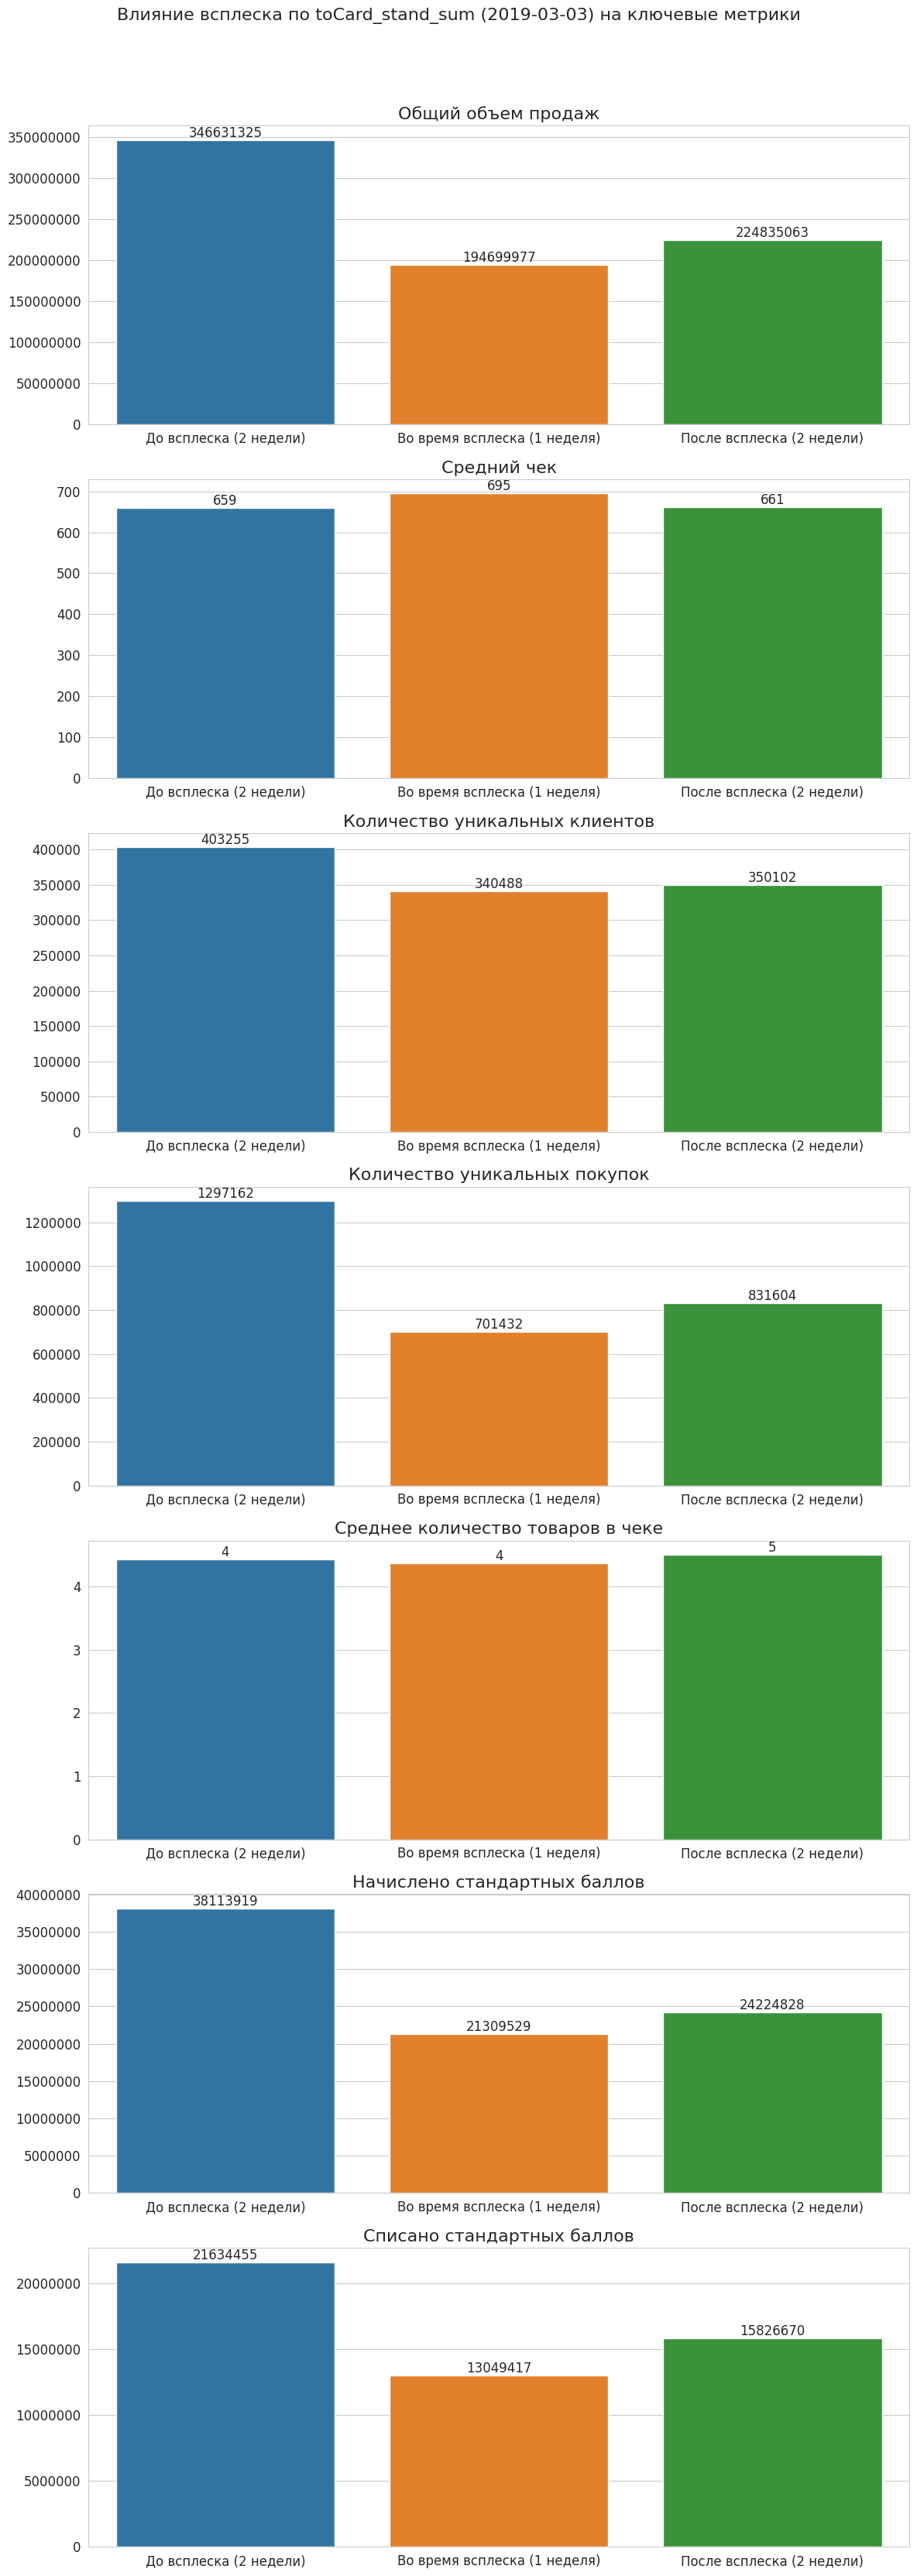


Изменения в Топ-категориях и Брендах для всплеска 2019-03-03:


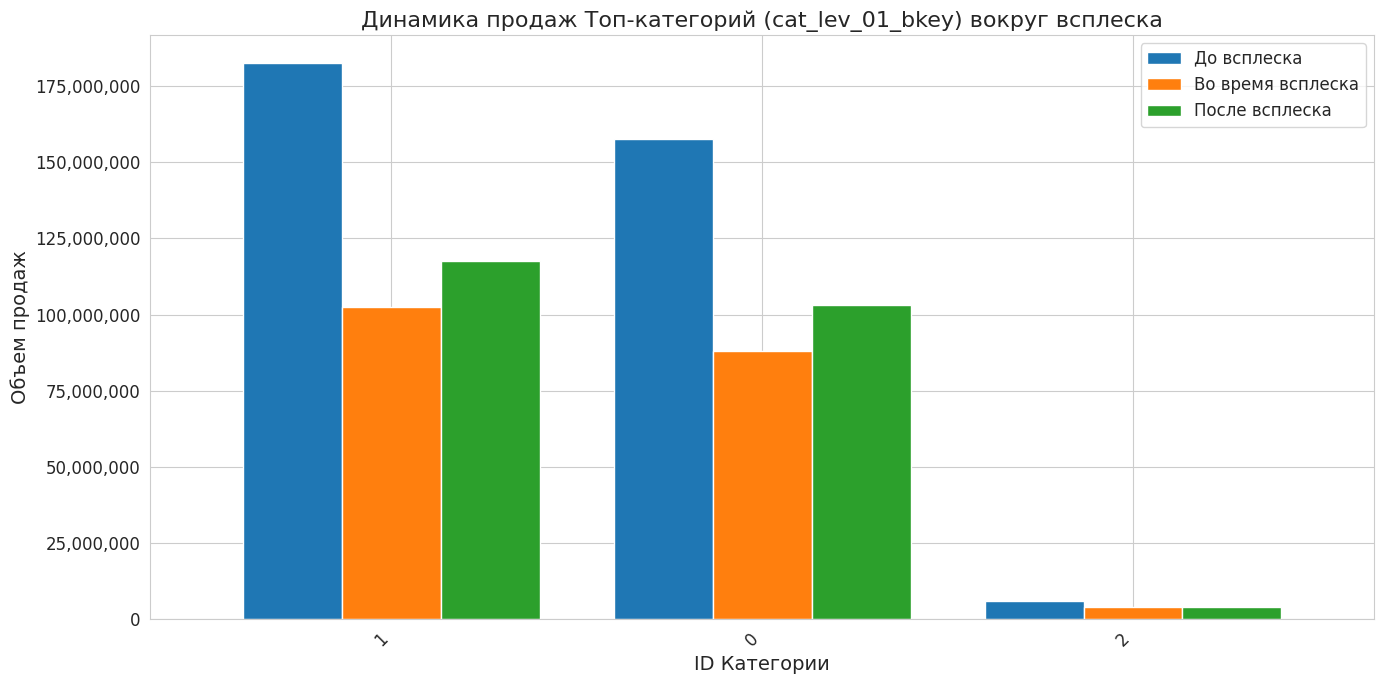

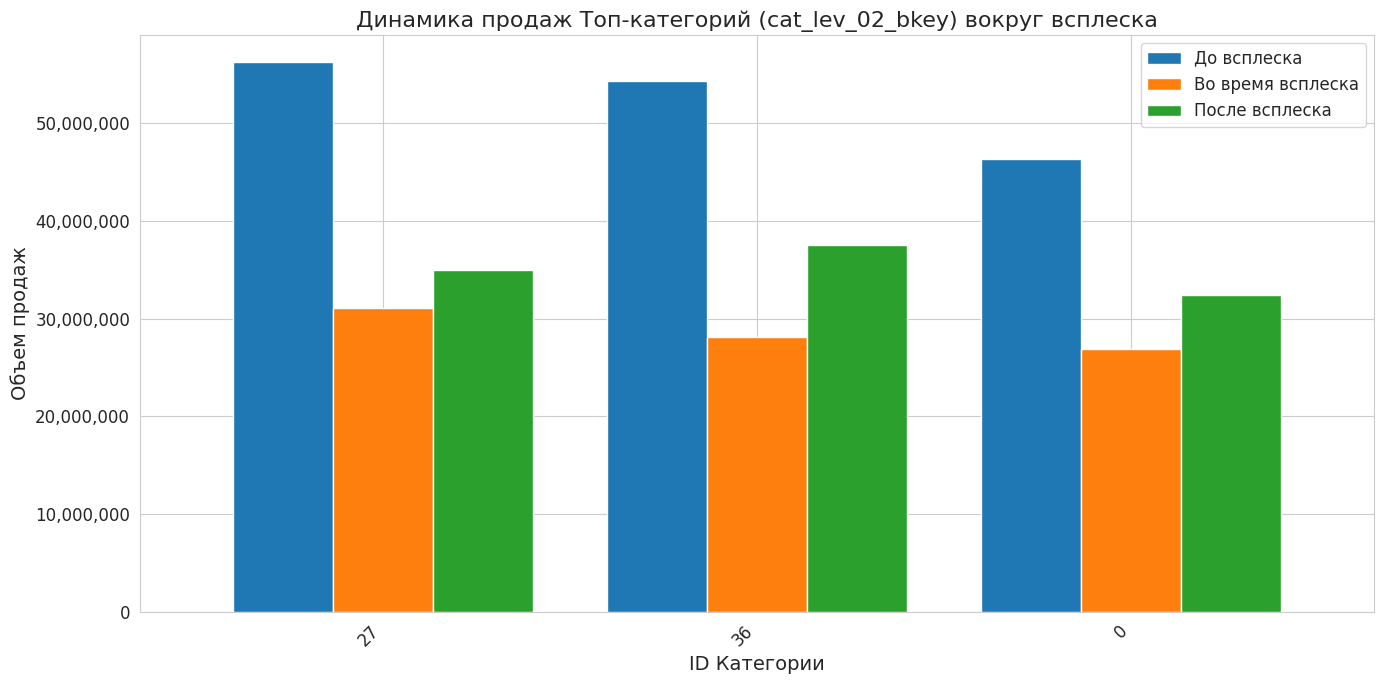

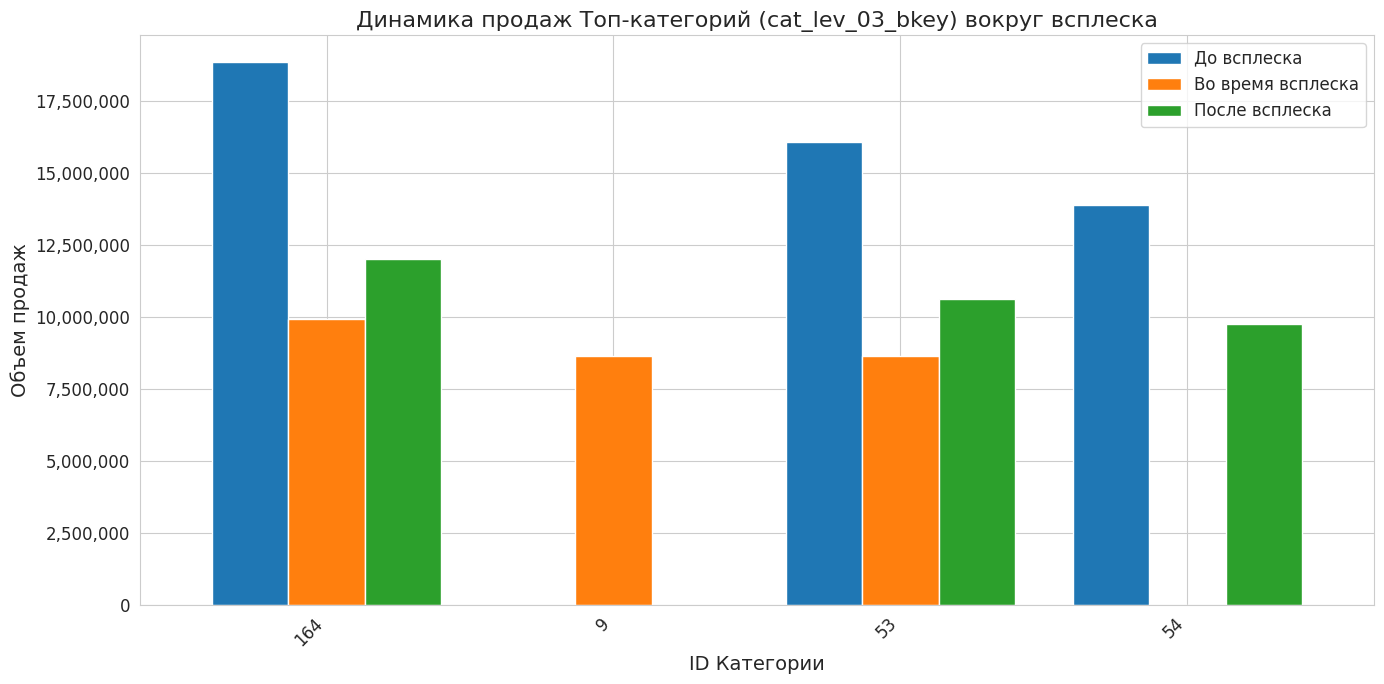

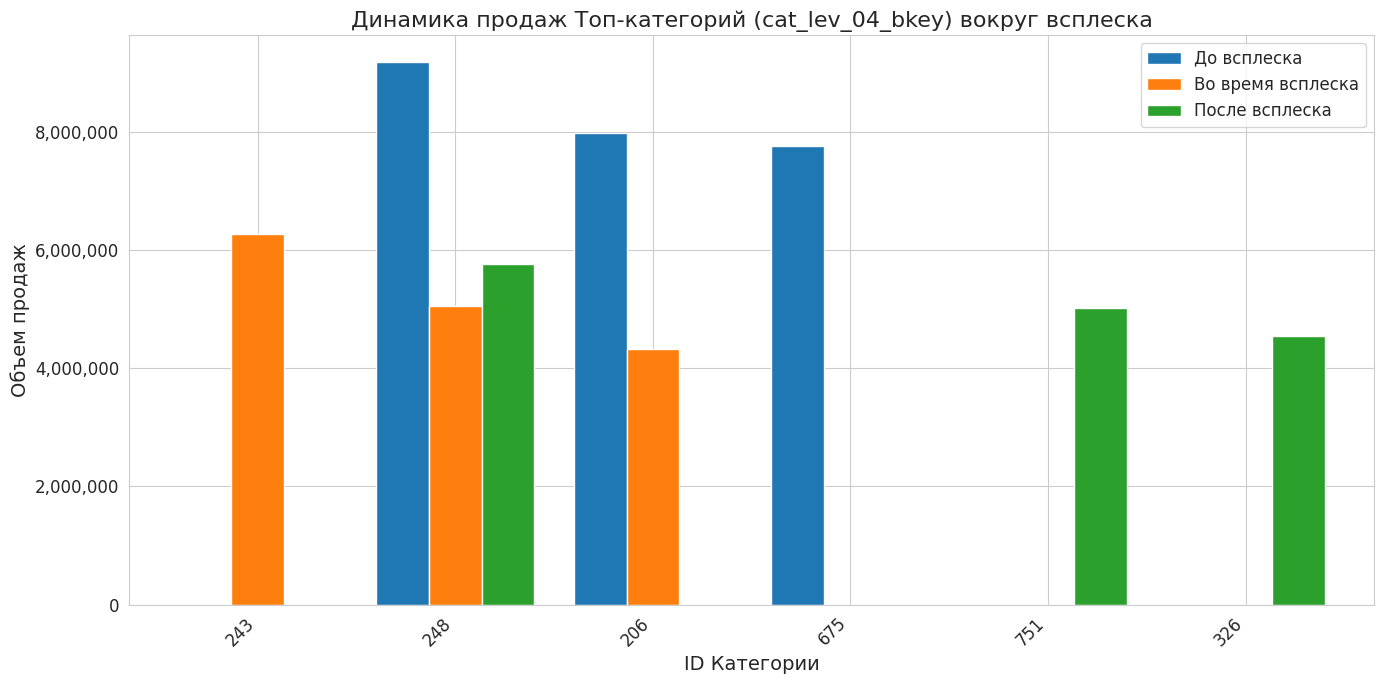

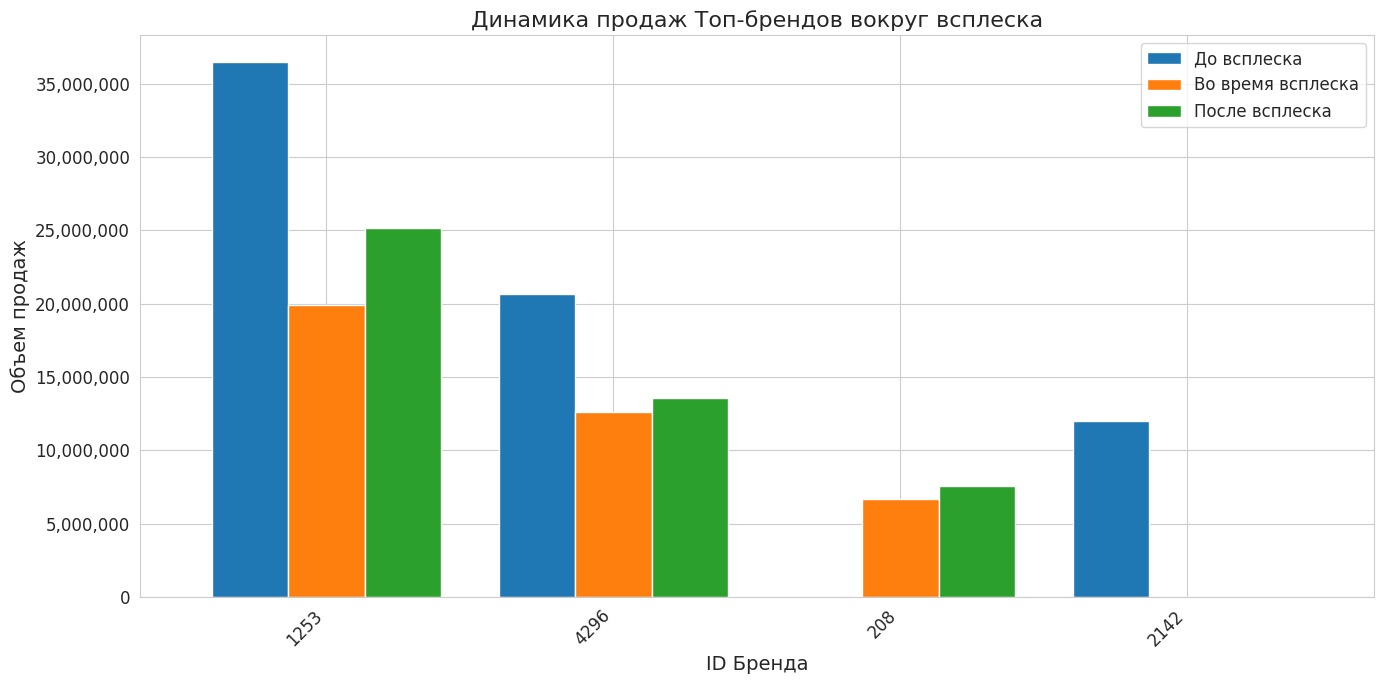


--- Анализ вернувшихся клиентов для всплеска 2019-03-03 ---
  Период для определения 'неактивных': 2018-11-18 - 2019-02-16
  Количество уникальных клиентов, которые были активны в период 'До всплеска': 403255
  Количество уникальных клиентов, которые были активны во время всплеска: 340488
  Количество уникальных клиентов, которые были активны после всплеска: 350102
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: 16083
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: 16271
  Из вернувшихся во время всплеска, сколько продолжили покупать и после: 8661

--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---
  Средний чек: До: 659.34, Во время: 694.70, После: 660.92
  Среднее количество товаров в чеке: До: 4.43, Во время: 4.38, После: 4.51

--- Анализ популярности товаров (Топ-10) для всплеска 

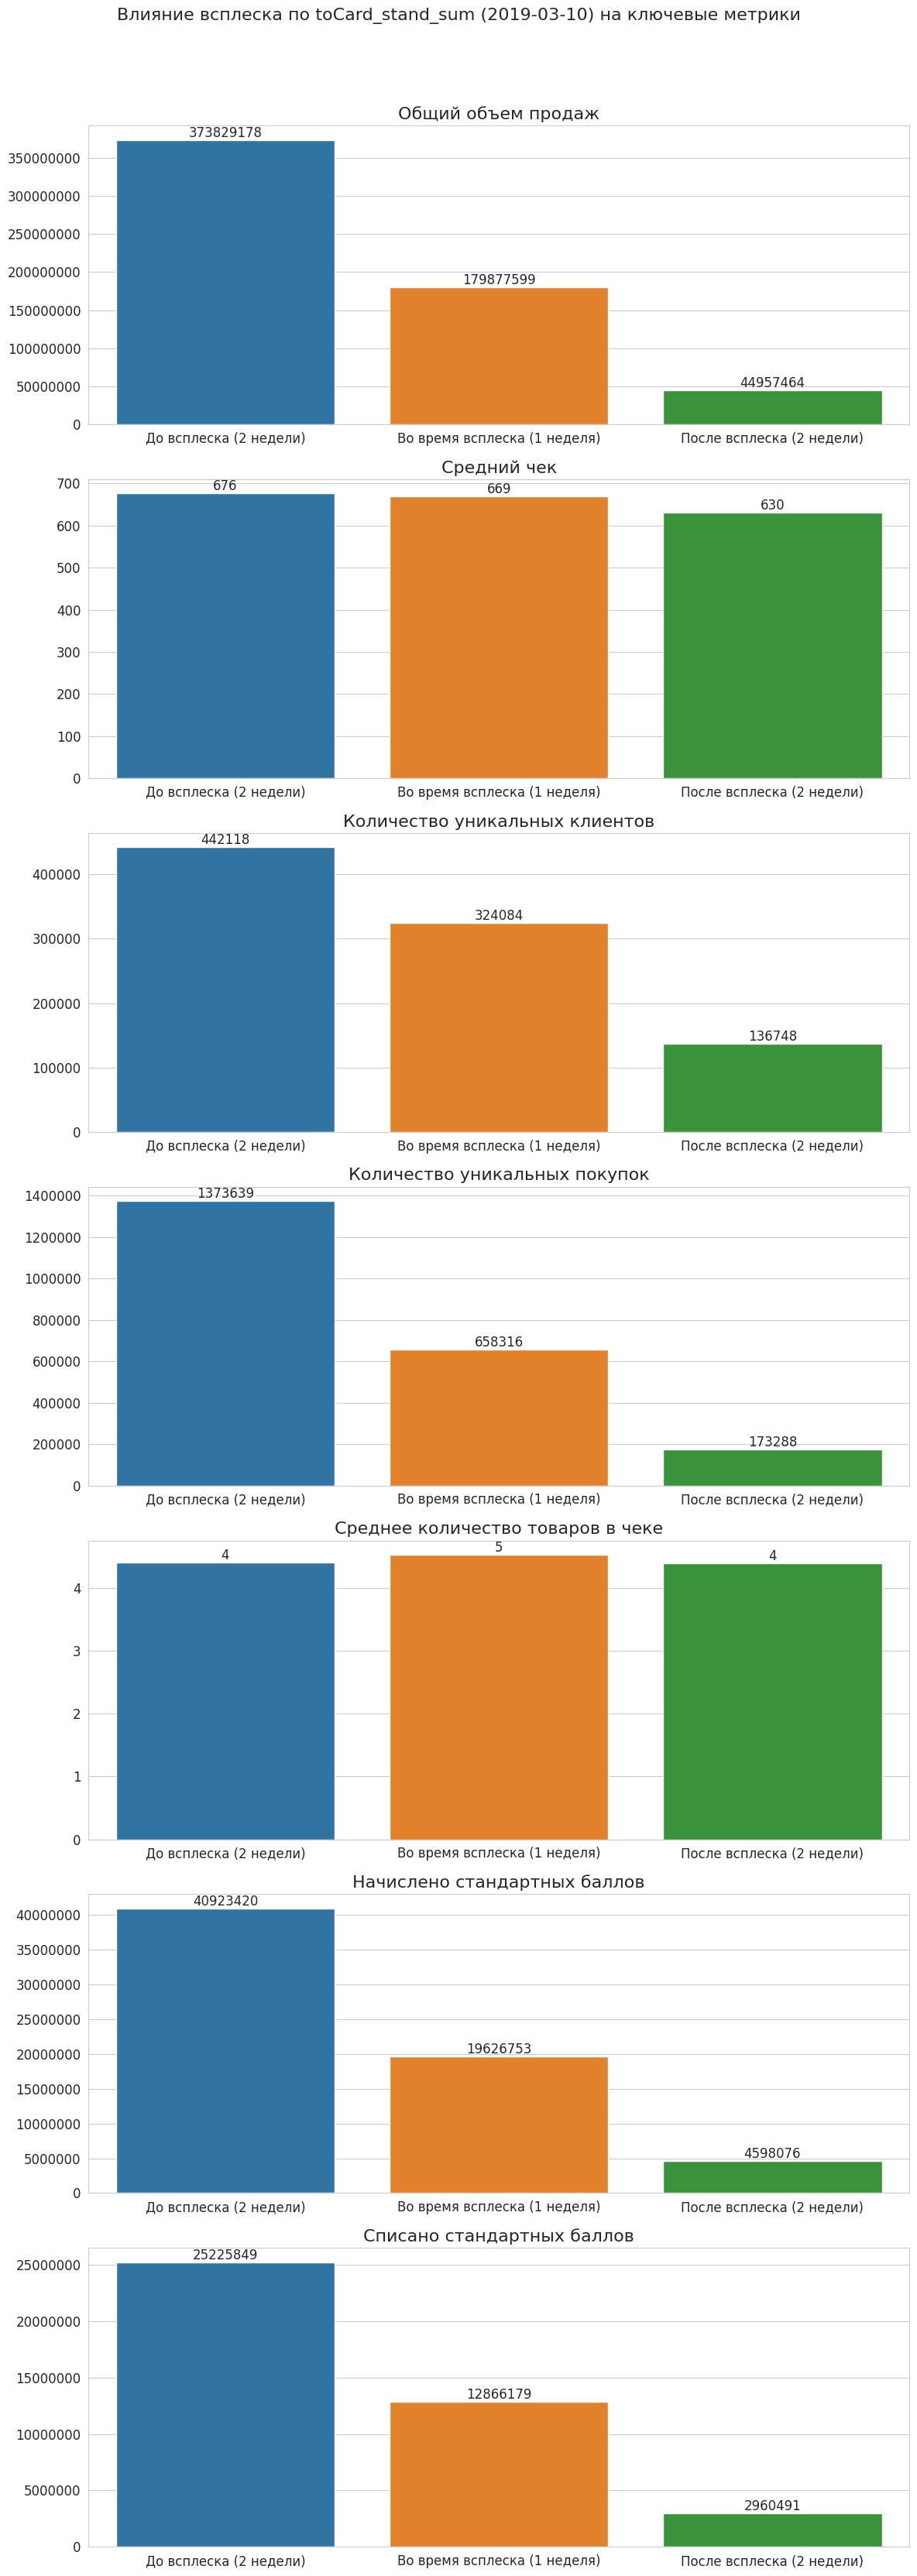


Изменения в Топ-категориях и Брендах для всплеска 2019-03-10:


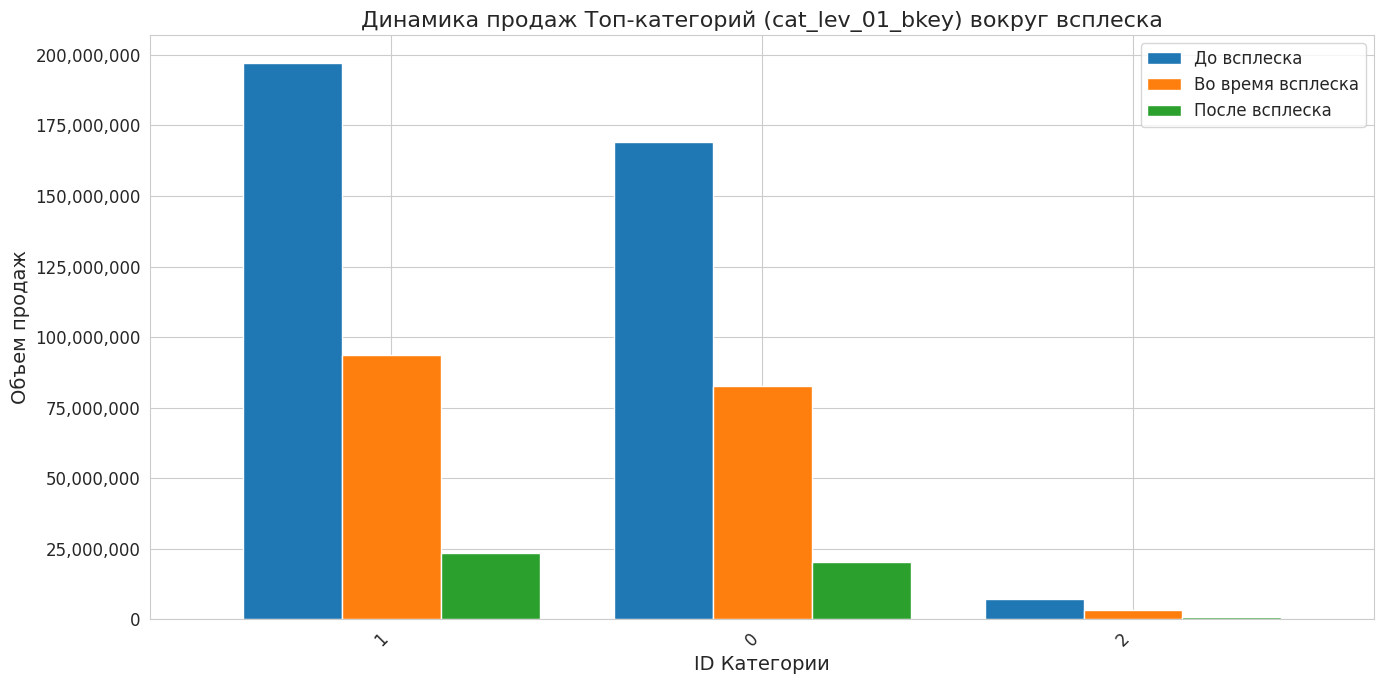

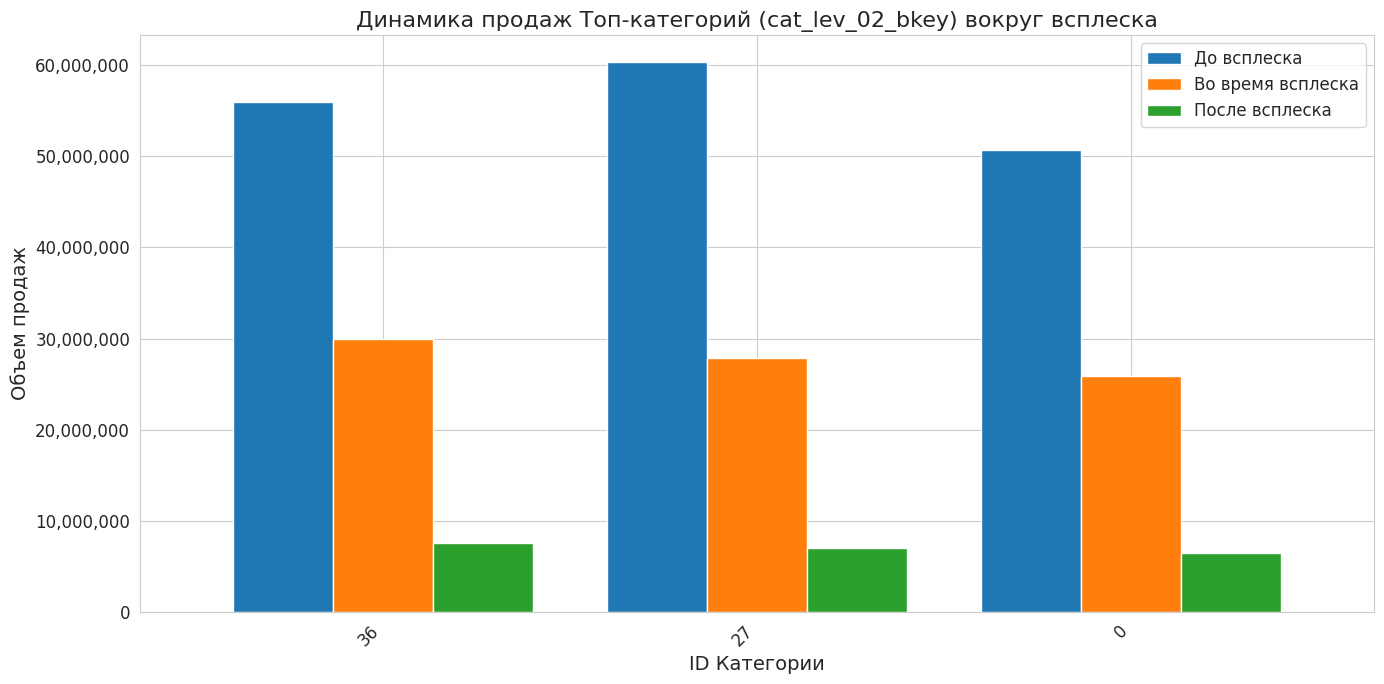

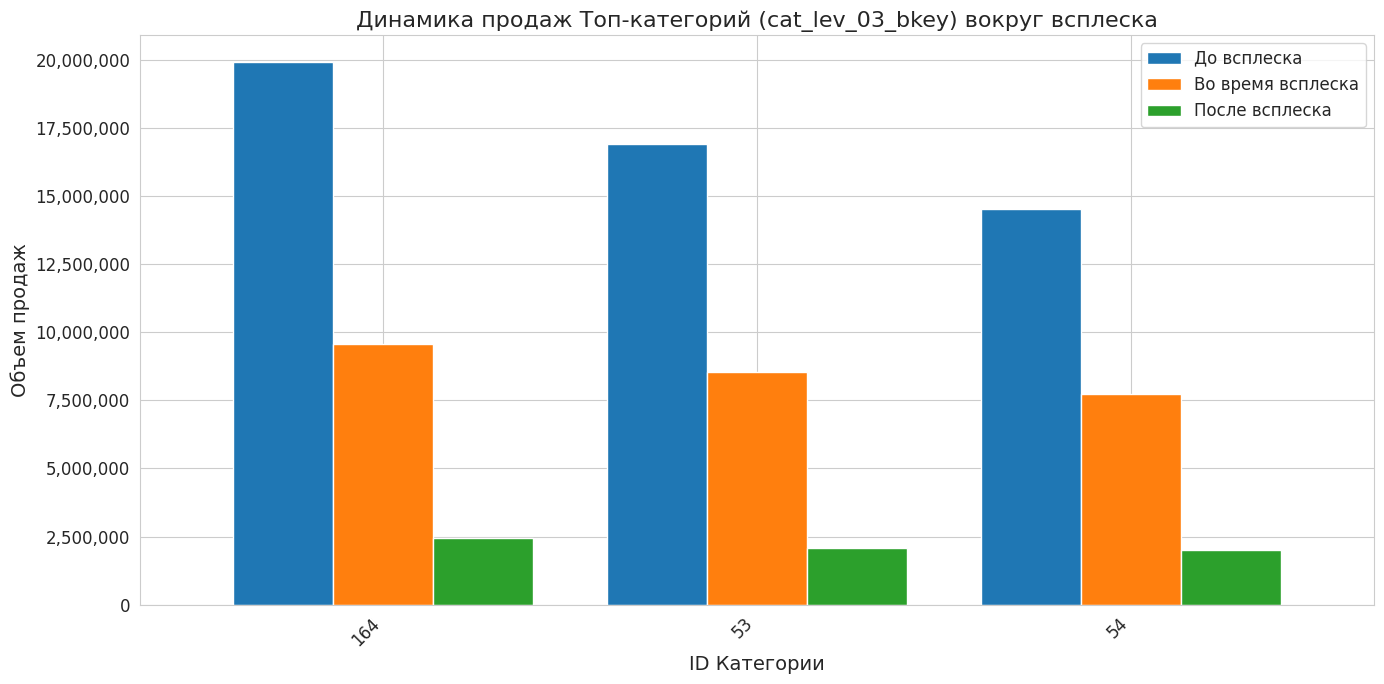

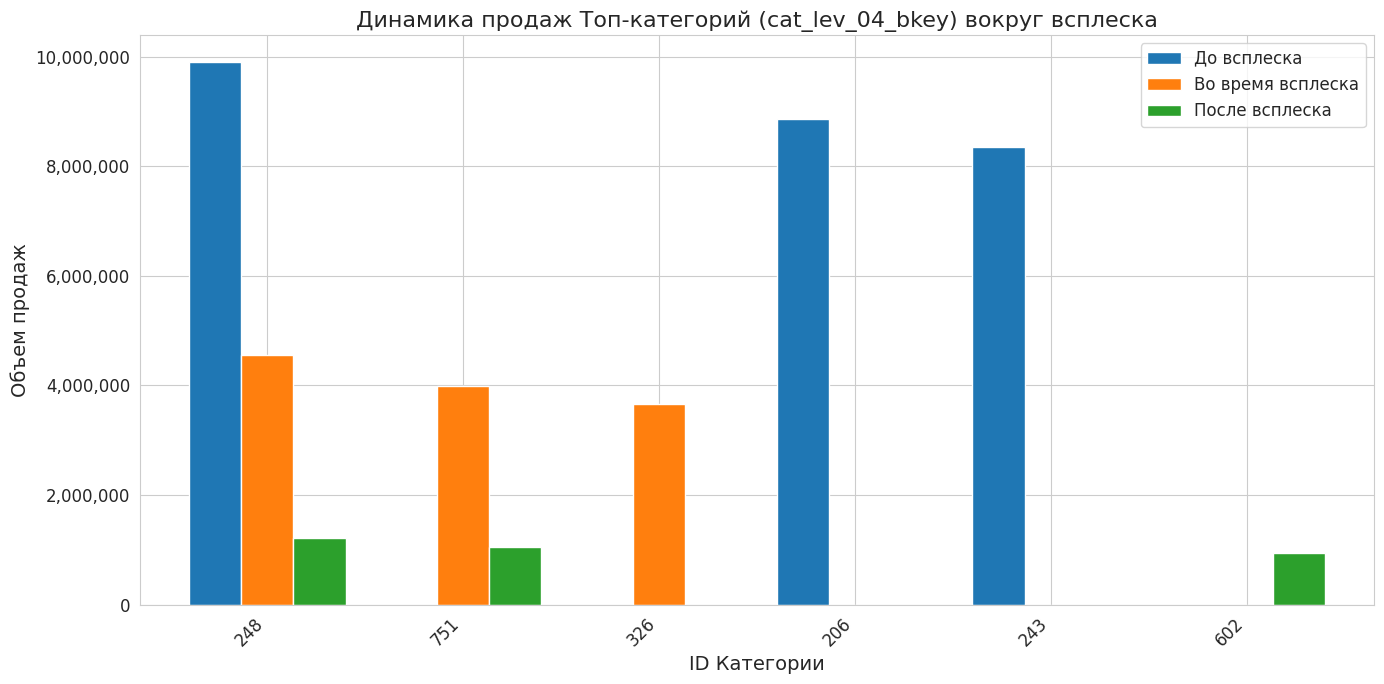

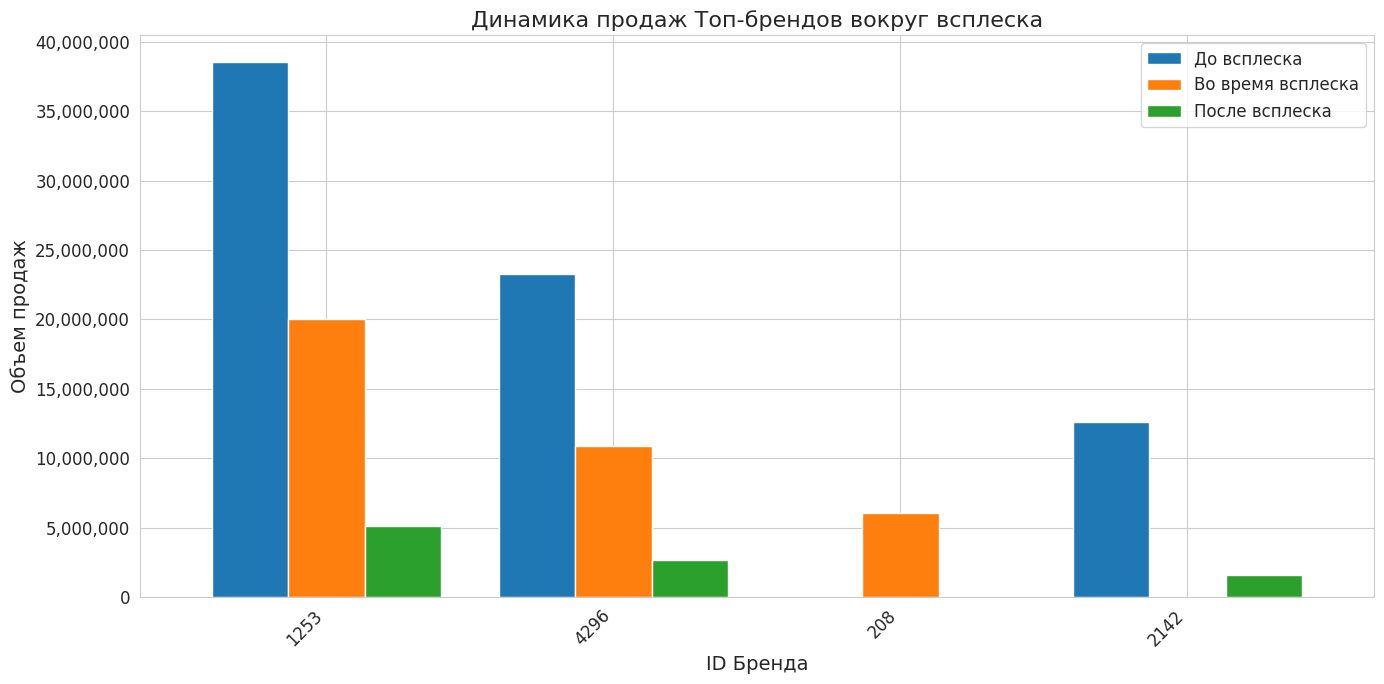


--- Анализ вернувшихся клиентов для всплеска 2019-03-10 ---
  Период для определения 'неактивных': 2018-11-25 - 2019-02-23
  Количество уникальных клиентов, которые были активны в период 'До всплеска': 442118
  Количество уникальных клиентов, которые были активны во время всплеска: 324084
  Количество уникальных клиентов, которые были активны после всплеска: 136748
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: 11717
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: 3558
  Из вернувшихся во время всплеска, сколько продолжили покупать и после: 2635

--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---
  Средний чек: До: 676.18, Во время: 668.72, После: 630.40
  Среднее количество товаров в чеке: До: 4.41, Во время: 4.53, После: 4.40

--- Анализ популярности товаров (Топ-10) для всплеска 2

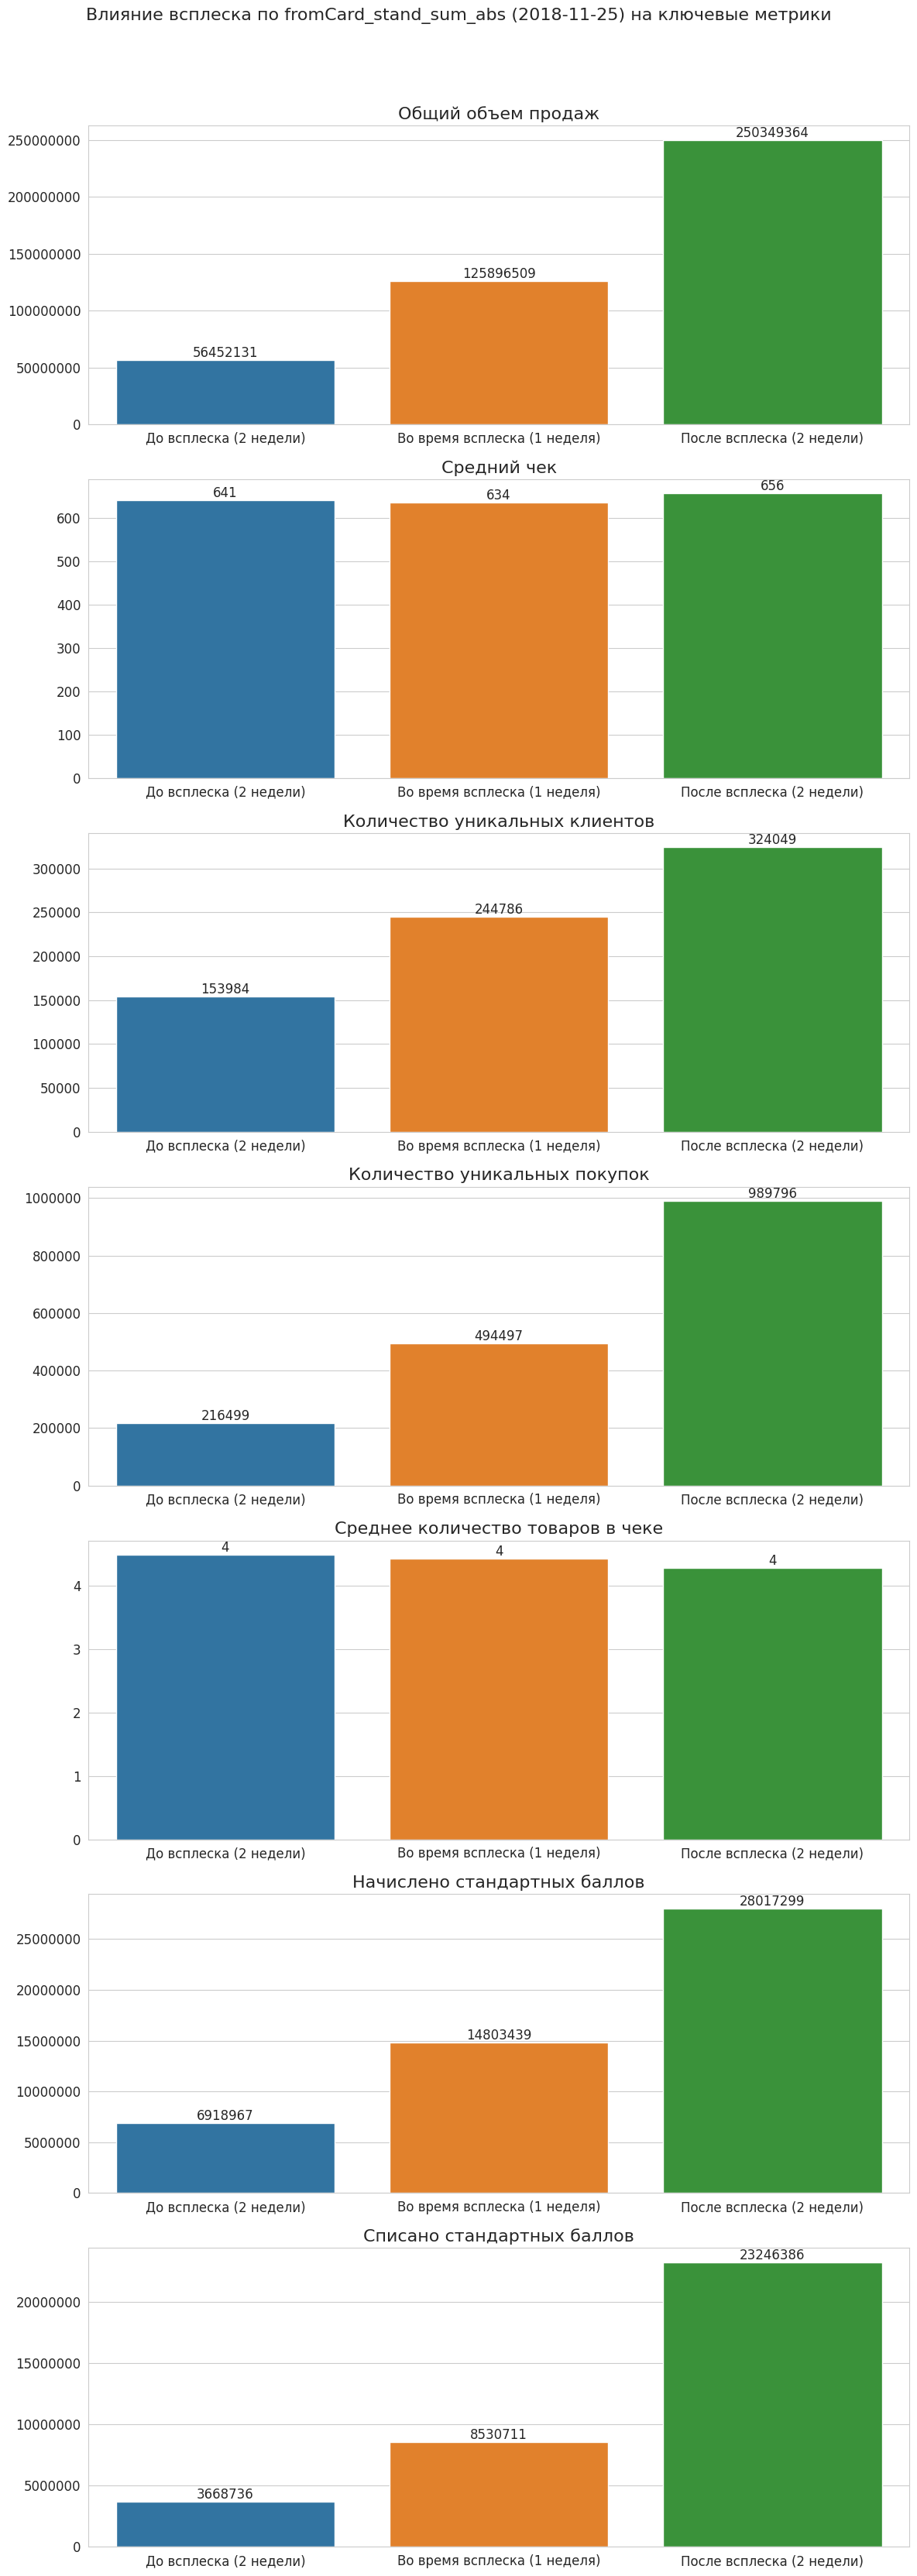


Изменения в Топ-категориях и Брендах для всплеска 2018-11-25:


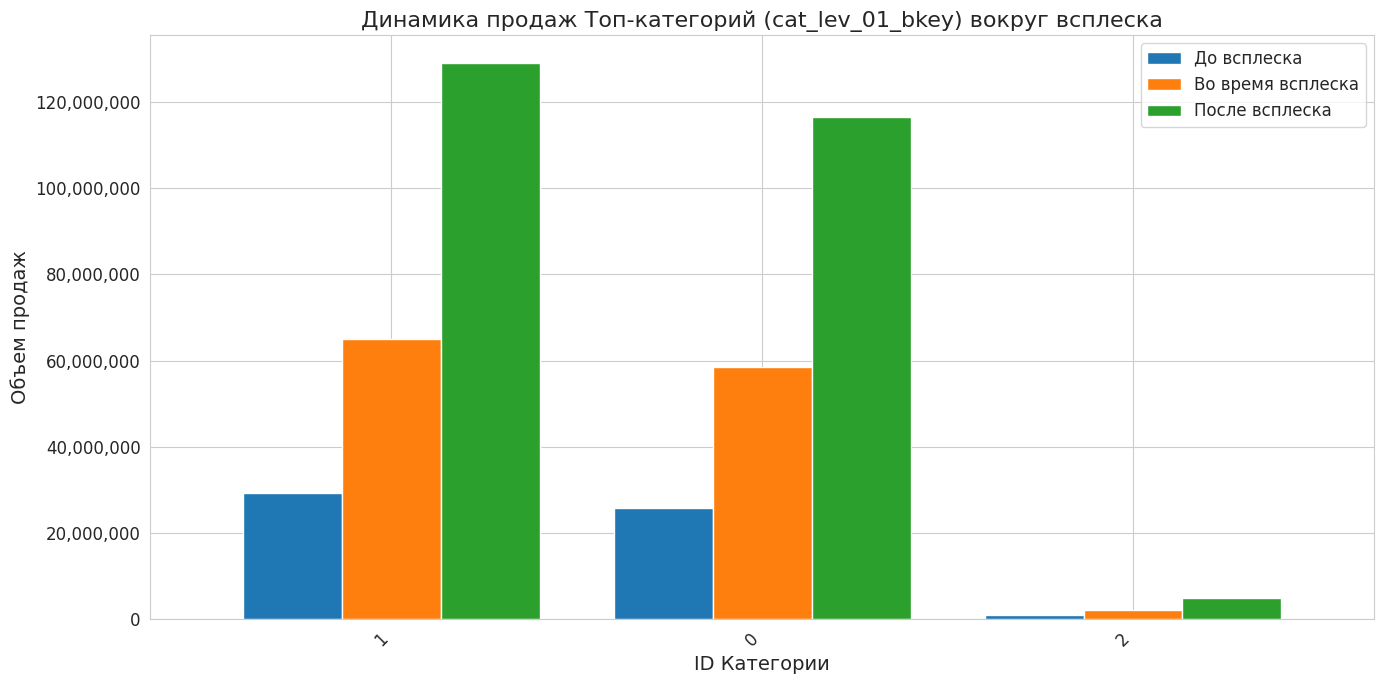

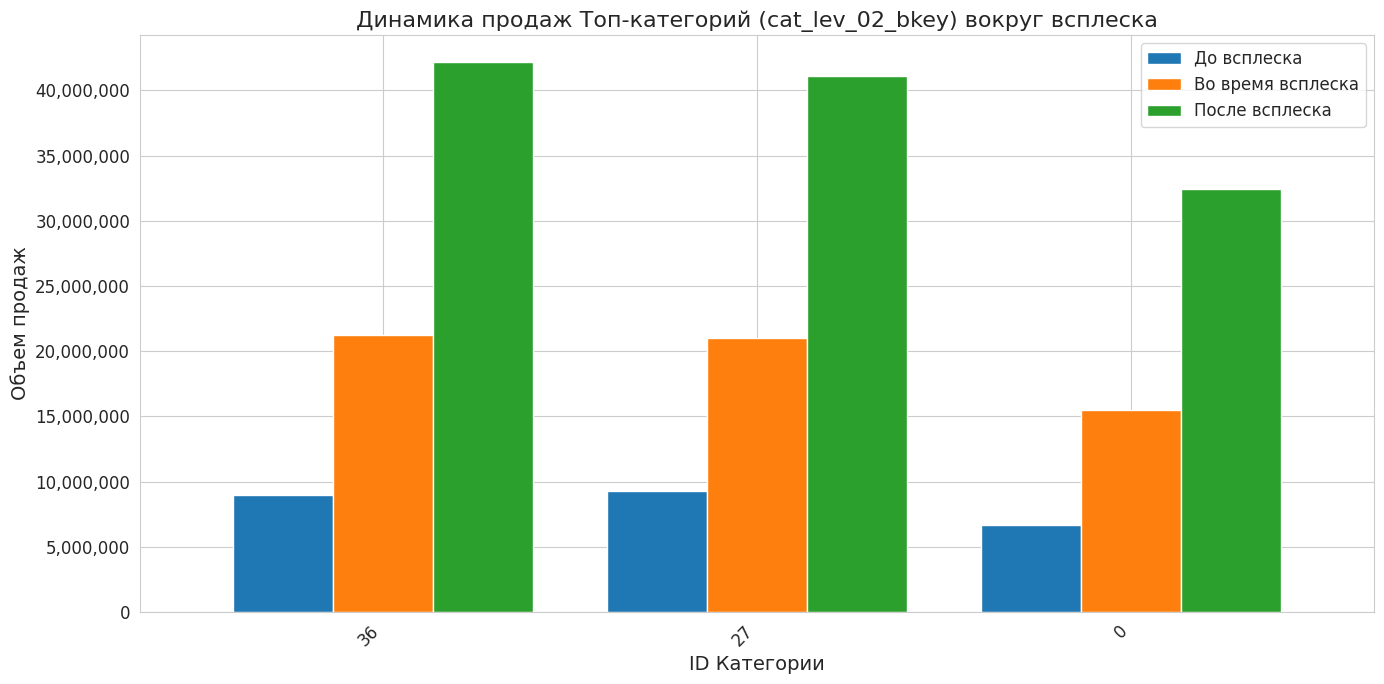

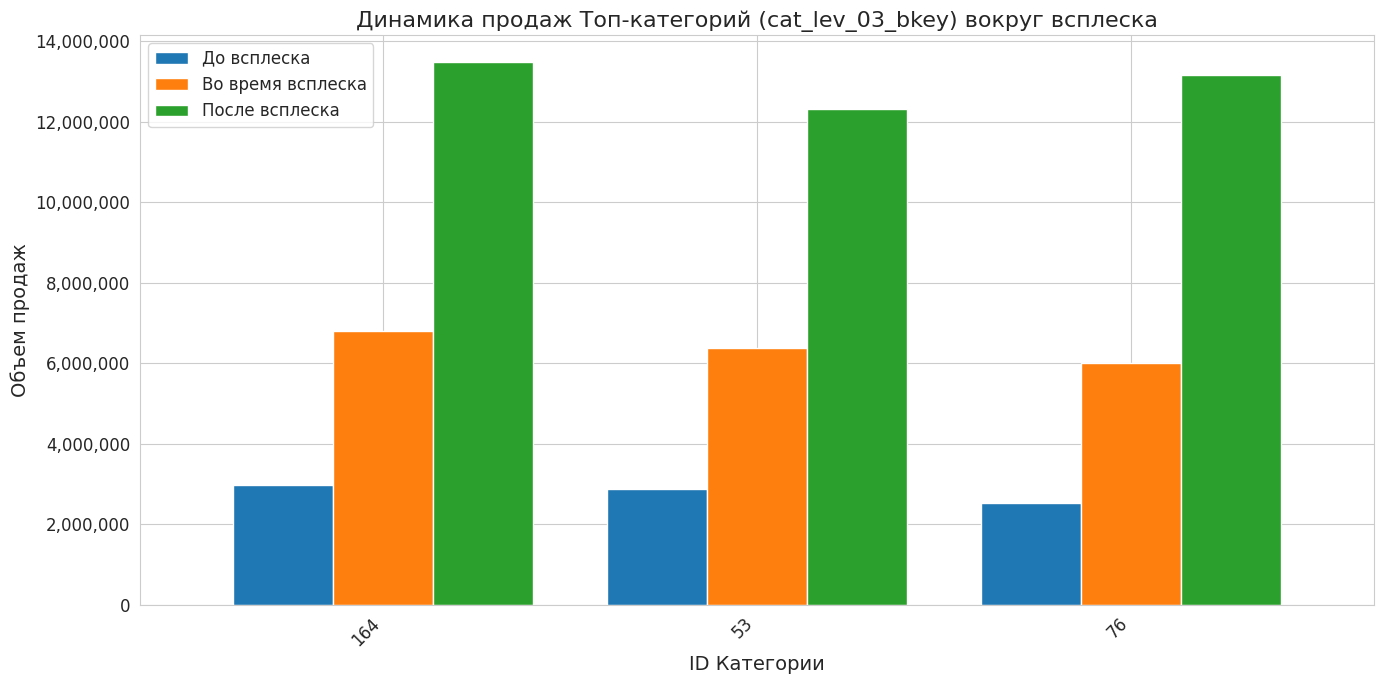

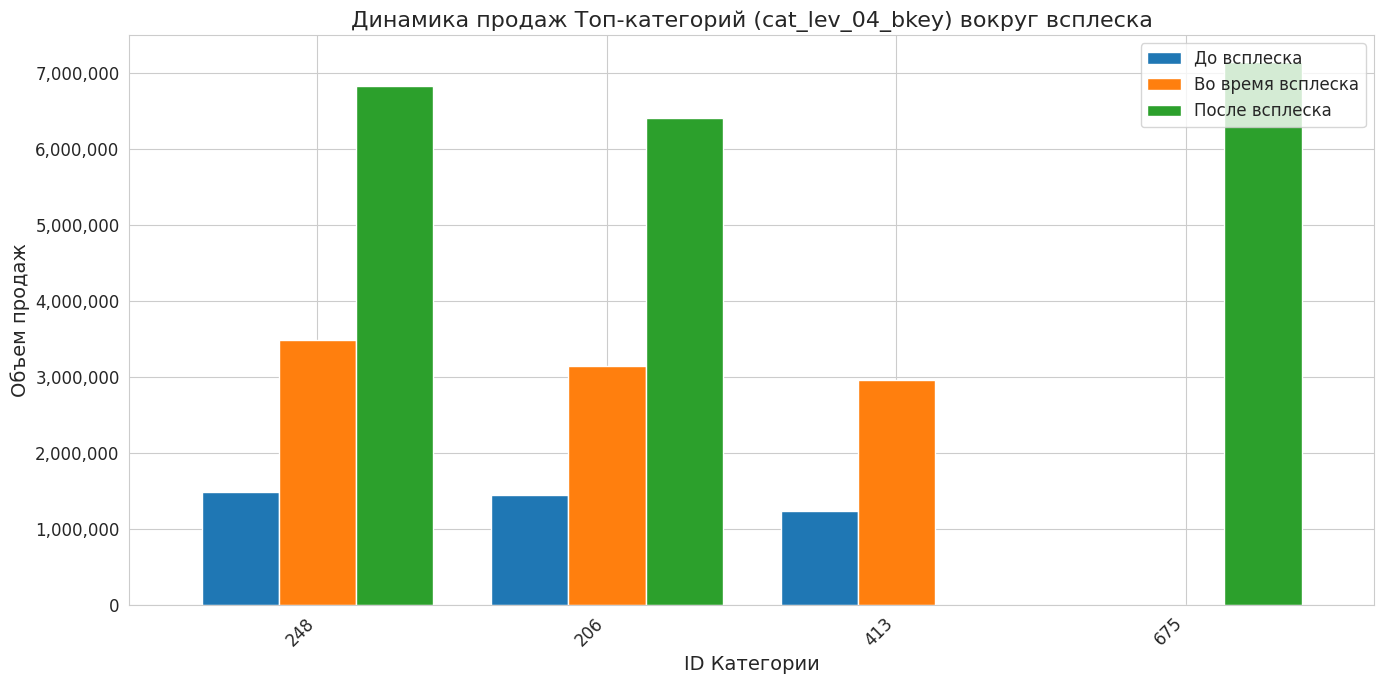

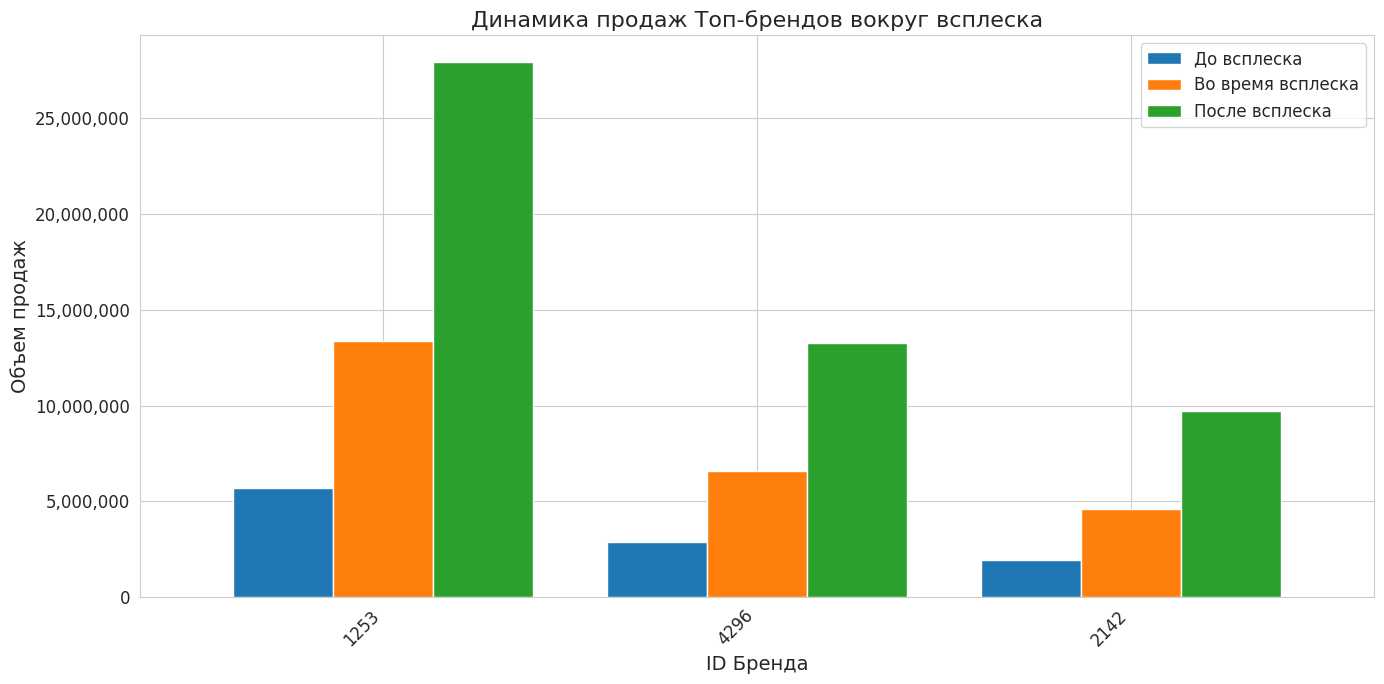


--- Анализ вернувшихся клиентов для всплеска 2018-11-25 ---
  Период для определения 'неактивных': 2018-08-12 - 2018-11-10
  Количество уникальных клиентов, которые были активны в период 'До всплеска': 153984
  Количество уникальных клиентов, которые были активны во время всплеска: 244786
  Количество уникальных клиентов, которые были активны после всплеска: 324049
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: 244786
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: 324049
  Из вернувшихся во время всплеска, сколько продолжили покупать и после: 209996

--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---
  Средний чек: До: 640.91, Во время: 634.41, После: 655.79
  Среднее количество товаров в чеке: До: 4.49, Во время: 4.43, После: 4.29

--- Анализ популярности товаров (Топ-10) для вспле

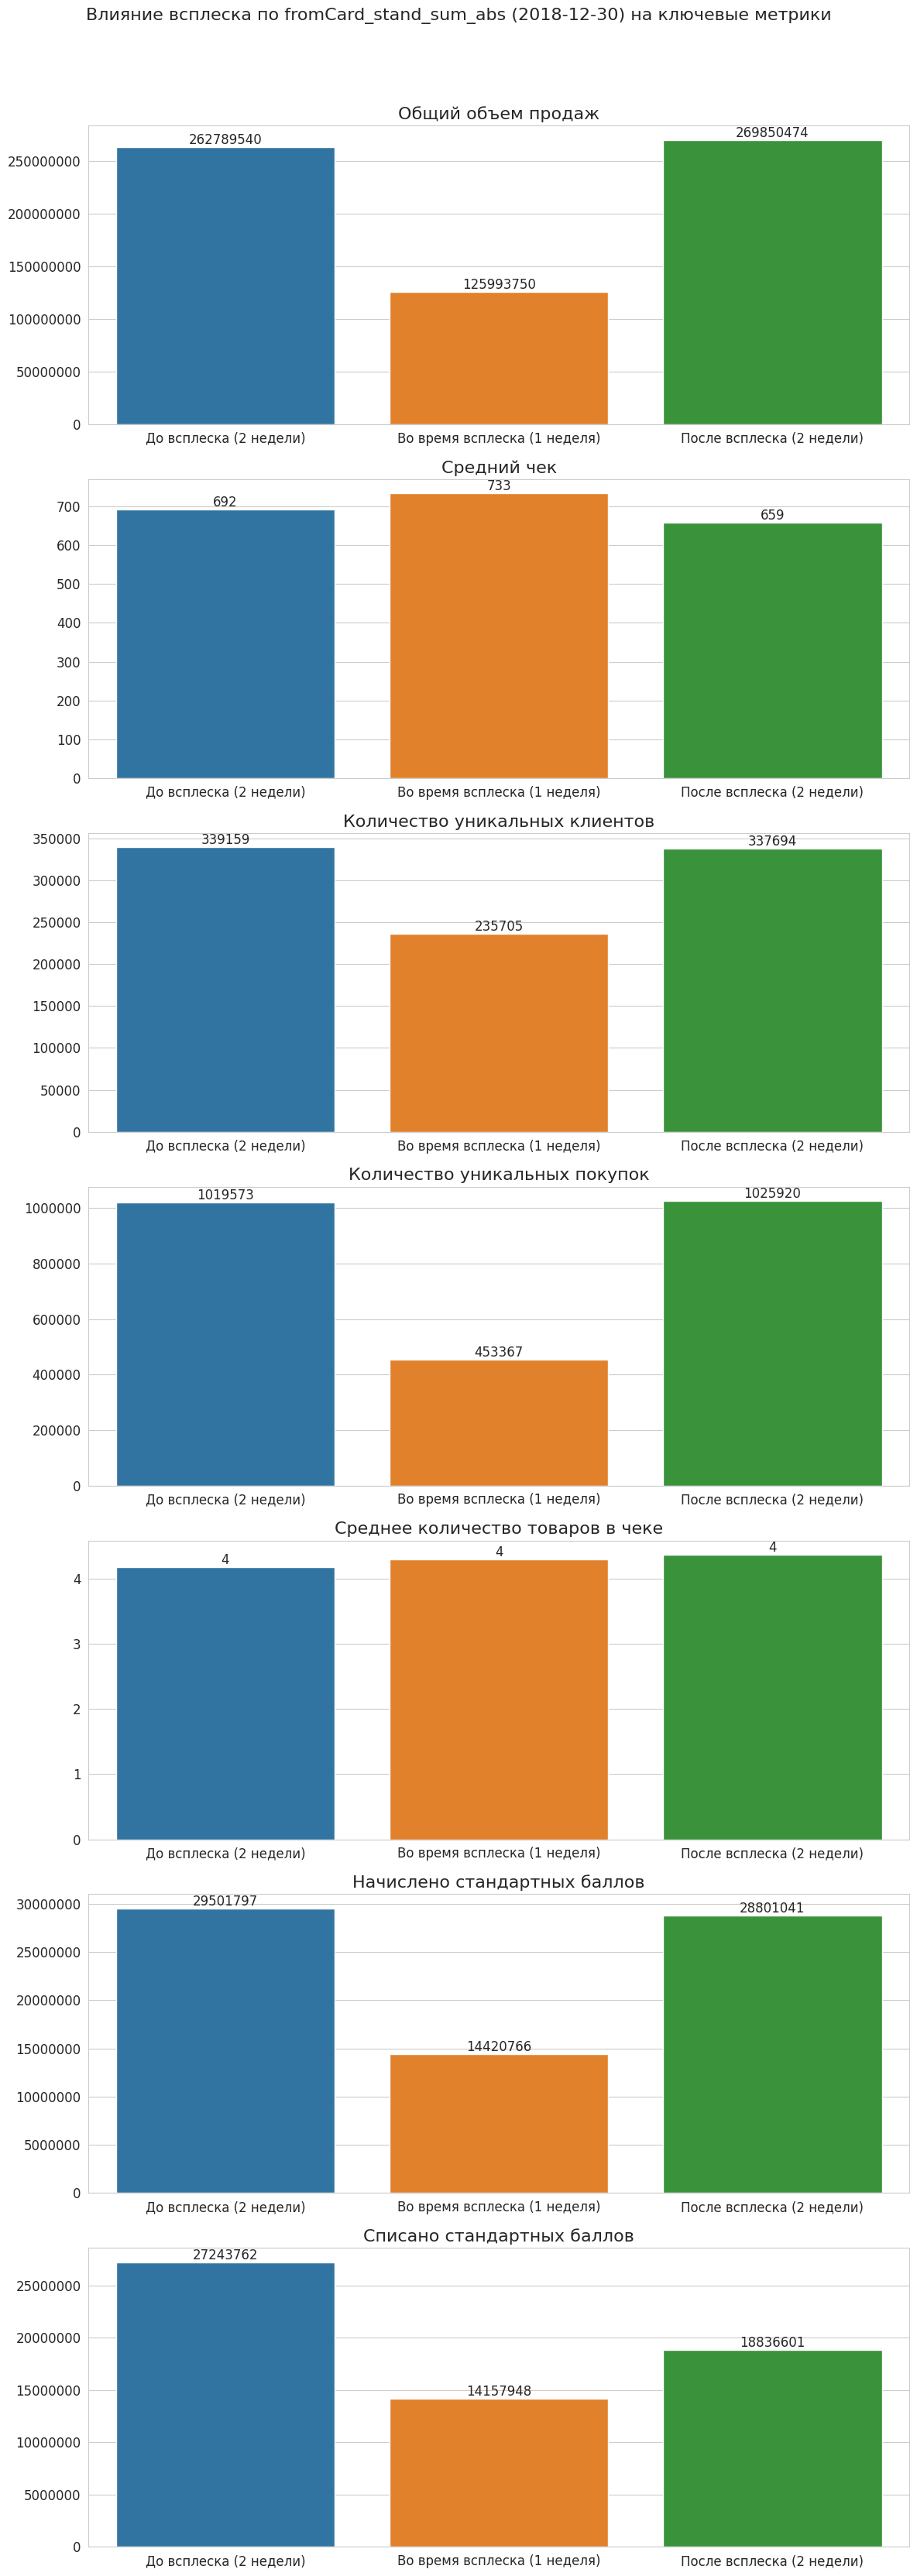


Изменения в Топ-категориях и Брендах для всплеска 2018-12-30:


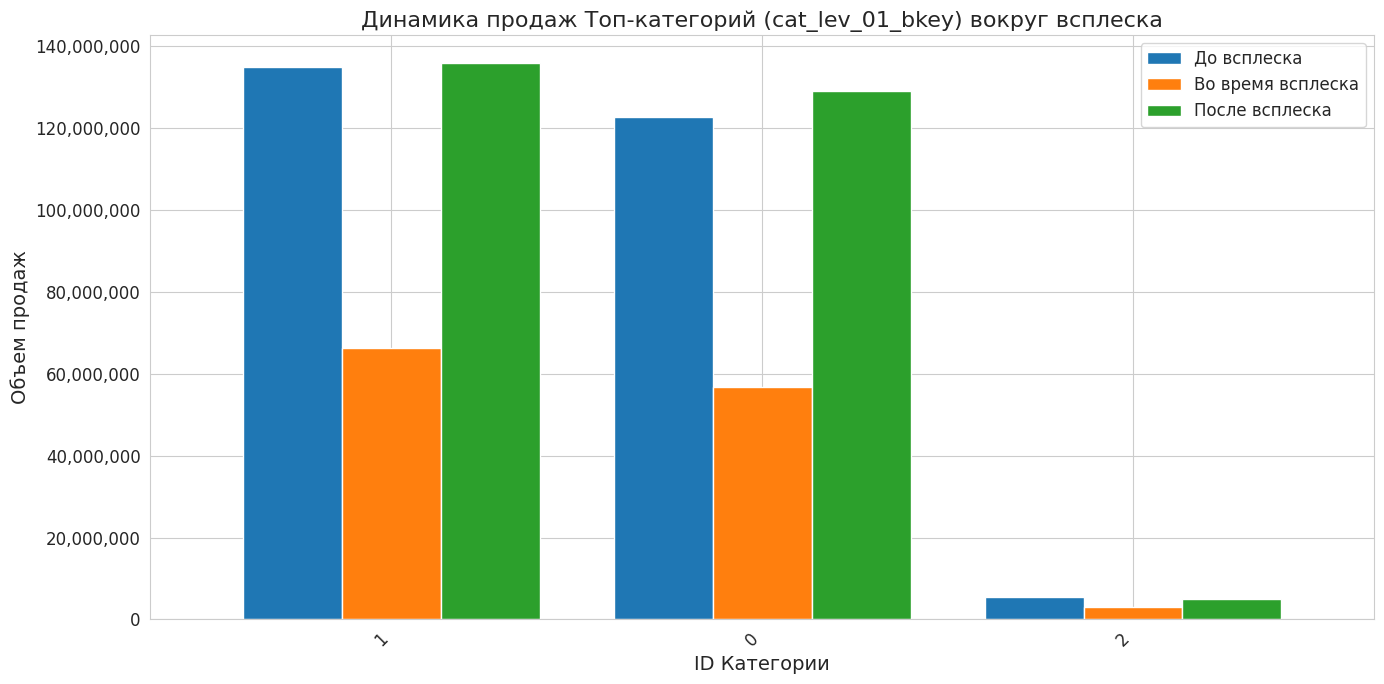

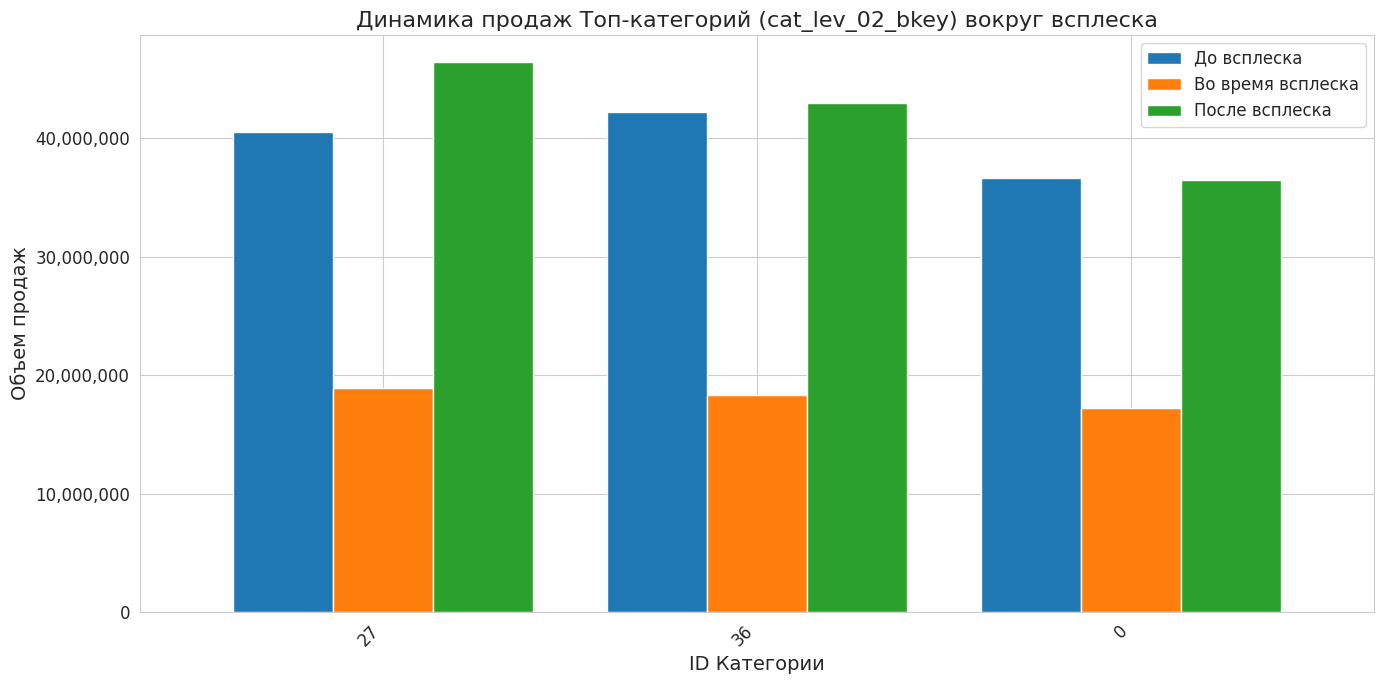

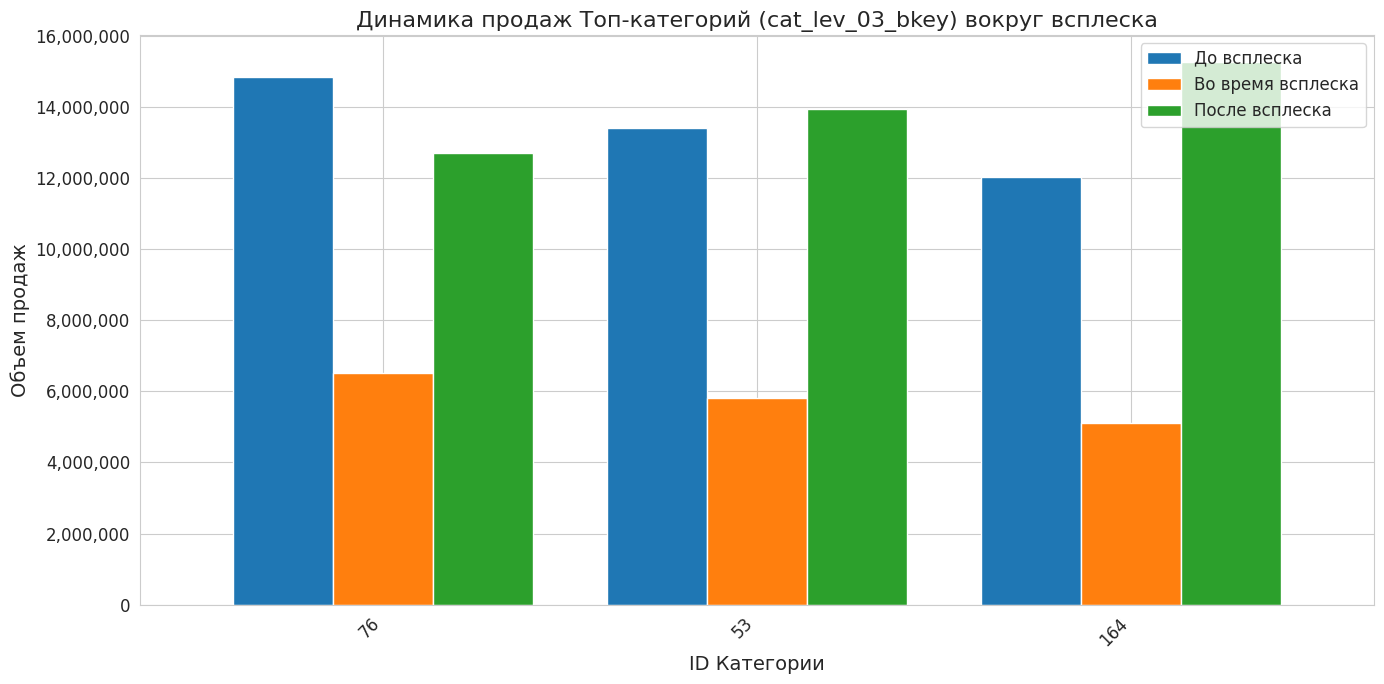

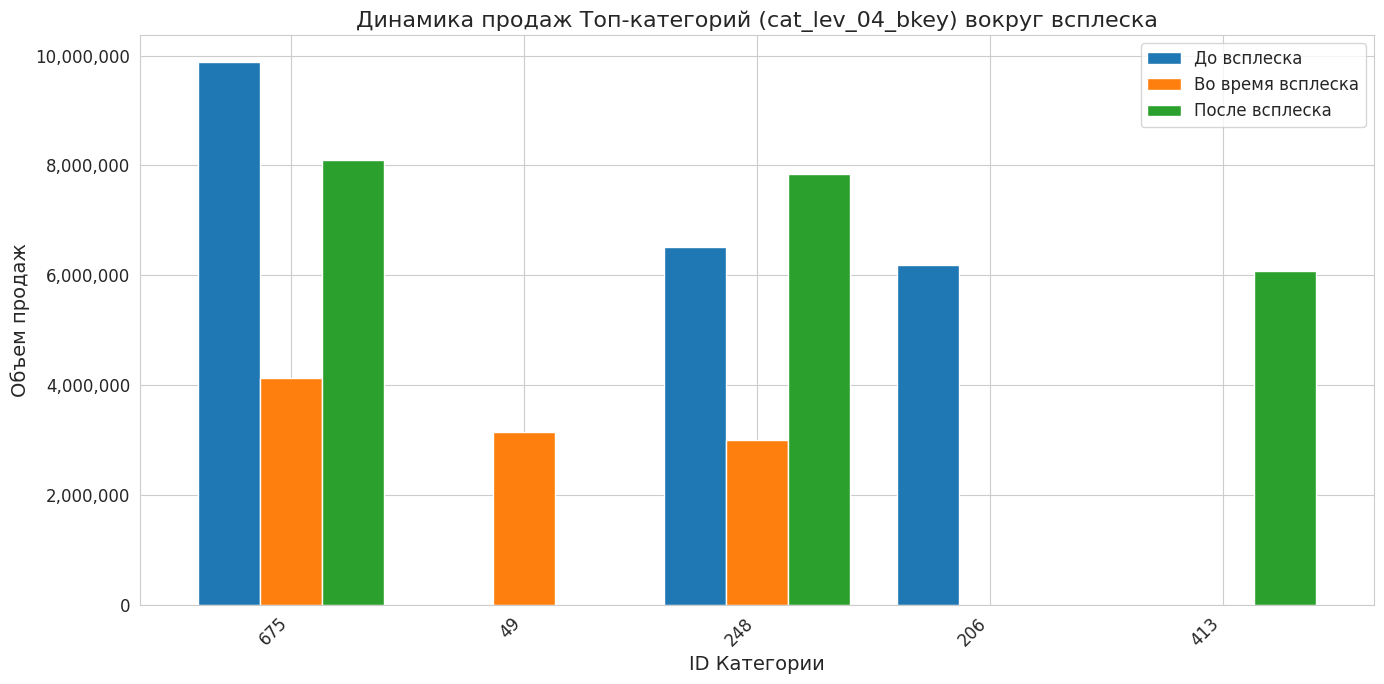

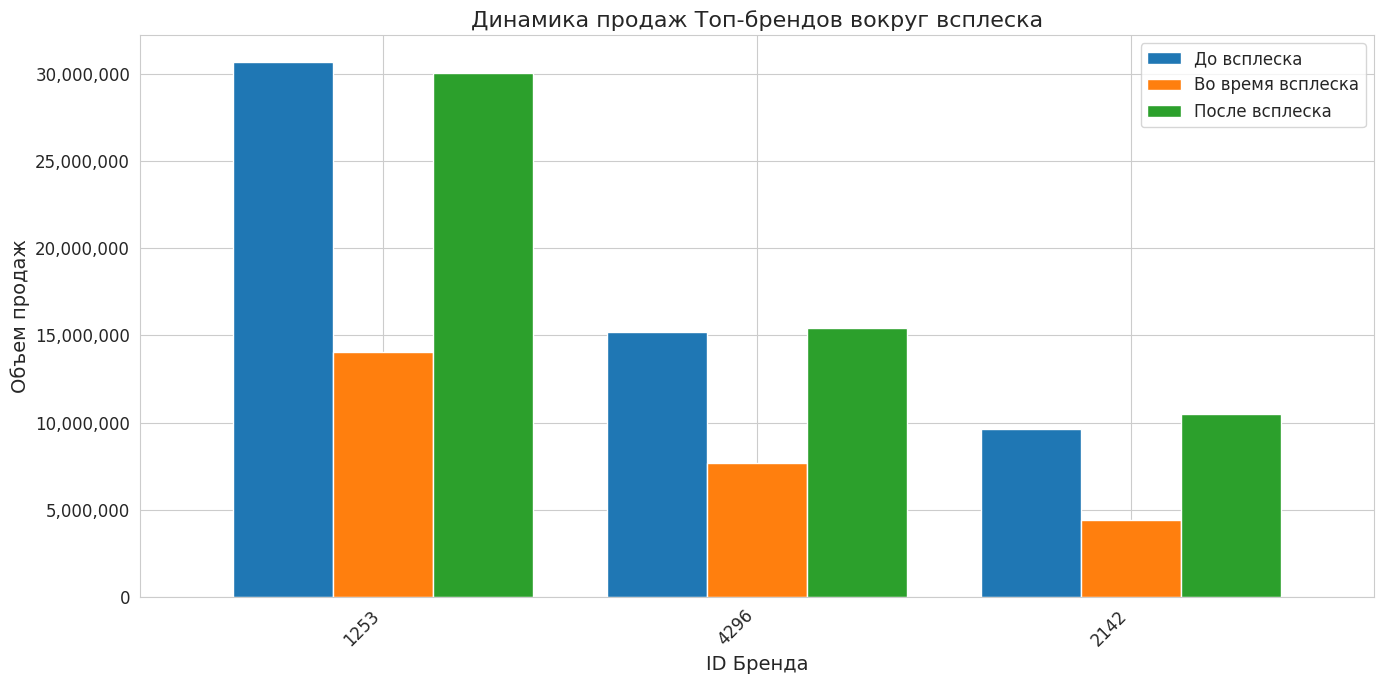


--- Анализ вернувшихся клиентов для всплеска 2018-12-30 ---
  Период для определения 'неактивных': 2018-09-16 - 2018-12-15
  Количество уникальных клиентов, которые были активны в период 'До всплеска': 339159
  Количество уникальных клиентов, которые были активны во время всплеска: 235705
  Количество уникальных клиентов, которые были активны после всплеска: 337694
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: 30502
  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: 53049
  Из вернувшихся во время всплеска, сколько продолжили покупать и после: 20499

--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---
  Средний чек: До: 692.28, Во время: 733.28, После: 658.62
  Среднее количество товаров в чеке: До: 4.18, Во время: 4.29, После: 4.36

--- Анализ популярности товаров (Топ-10) для всплеска

In [10]:
metrics_to_plot = [
    'Общий объем продаж',
    'Средний чек',
    'Количество уникальных клиентов',
    'Количество уникальных покупок',
    'Среднее количество товаров в чеке',
    'Начислено стандартных баллов',
    'Списано стандартных баллов'
]

for spike_info in detected_spikes_info:
    spike_date = spike_info['spike_date']
    metric_name = spike_info['metric_name']
    periods_data = spike_info['periods']

    print(f"\n--- Анализ всплеска по '{metric_name}' на неделе {spike_date.strftime('%Y-%m-%d')} ---")

    # 1. Визуализация общих метрик
    plot_data = []
    for period_label, data in periods_data.items():
        row = {'Период': period_label}
        for metric in metrics_to_plot:
            val = data.get(metric, 0)
            if metric == 'Списано стандартных баллов' and isinstance(val, (int, float)):
                row[metric] = abs(val) # Используем абсолютное значение для визуализации
            else:
                row[metric] = val
        plot_data.append(row)

    df_plot_metrics = pd.DataFrame(plot_data)

    num_metrics_available = len(df_plot_metrics.columns) - 1

    fig, axes = plt.subplots(num_metrics_available, 1, figsize=(12, 5 * num_metrics_available))
    fig.suptitle(f'Влияние всплеска по {metric_name} ({spike_date.strftime("%Y-%m-%d")}) на ключевые метрики', fontsize=16)

    # Если только одна метрика, axes может быть не массивом
    if num_metrics_available == 1:
        axes = [axes] # Оборачиваем в список для единообразной итерации

    for i, metric in enumerate(metrics_to_plot):
        if metric in df_plot_metrics.columns:
            sns.barplot(ax=axes[i],
                        x='Период',
                        y=metric,
                        data=df_plot_metrics,
                        hue='Период',
                        legend=False)
            axes[i].set_title(metric)
            axes[i].set_ylabel('')
            axes[i].set_xlabel('')
            axes[i].ticklabel_format(style='plain', axis='y')

            # Добавление значений на столбцы
            for container in axes[i].containers:
                axes[i].bar_label(container, fmt='%.0f', label_type='edge')
    plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.96))
    plt.show()

    # 2. Анализ и визуализация категорий и брендов
    print(f"\nИзменения в Топ-категориях и Брендах для всплеска {spike_date.strftime('%Y-%m-%d')}:")
    category_levels = ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey']

    for cat_level in category_levels:
        key_name = f'Топ-3 категории ({cat_level}) по продажам'
        if (key_name in periods_data.get('До всплеска (2 недели)', {}) and
            key_name in periods_data.get('Во время всплеска (1 неделя)', {}) and
            key_name in periods_data.get('После всплеска (2 недели)', {})):

            plot_category_brand_dynamics(
                periods_data['До всплеска (2 недели)'][key_name],
                periods_data['Во время всплеска (1 неделя)'][key_name],
                periods_data['После всплеска (2 недели)'][key_name],
                f'Динамика продаж Топ-категорий ({cat_level}) вокруг всплеска',
                'ID Категории'
            )
        else:
            print(f"  Данные по '{key_name}' отсутствуют или неполны в одном из периодов для всплеска.")


    brand_key_name = 'Топ-3 бренда по продажам'
    if (brand_key_name in periods_data.get('До всплеска (2 недели)', {}) and
        brand_key_name in periods_data.get('Во время всплеска (1 неделя)', {}) and
        brand_key_name in periods_data.get('После всплеска (2 недели)', {})):

        plot_category_brand_dynamics(
            periods_data['До всплеска (2 недели)'][brand_key_name],
            periods_data['Во время всплеска (1 неделя)'][brand_key_name],
            periods_data['После всплеска (2 недели)'][brand_key_name],
            'Динамика продаж Топ-брендов вокруг всплеска',
            'ID Бренда'
        )
    else:
        print(f"  Данные по '{brand_key_name}' отсутствуют или неполны в одном из периодов для всплеска.")


    # 3. Анализ вернувшихся клиентов
    print(f"\n--- Анализ вернувшихся клиентов для всплеска {spike_date.strftime('%Y-%m-%d')} ---")

    # Определяем период для поиска "неактивных" клиентов.
    inactive_check_end_date = periods_data['До всплеска (2 недели)']['_period_start_date'] - pd.Timedelta(days=1)
    inactive_check_start_date = inactive_check_end_date - pd.Timedelta(days=90)

    # Получаем всех уникальных клиентов, которые совершали покупки в этом "неактивном" периоде
    customers_active_in_inactive_period = full_df[
        (full_df['Opetation_datetime'] >= inactive_check_start_date) &
        (full_df['Opetation_datetime'] <= inactive_check_end_date)
    ]['Person_BKEY'].unique()

    # Клиенты, которые совершили покупку во время всплеска
    customers_during_spike = full_df[
        (full_df['Opetation_datetime'] >= periods_data['Во время всплеска (1 неделя)']['_period_start_date']) &
        (full_df['Opetation_datetime'] <= periods_data['Во время всплеска (1 неделя)']['_period_end_date'])
    ]['Person_BKEY'].unique()

    # Клиенты, которые совершили покупку после всплеска
    customers_after_spike = full_df[
        (full_df['Opetation_datetime'] >= periods_data['После всплеска (2 недели)']['_period_start_date']) &
        (full_df['Opetation_datetime'] <= periods_data['После всплеска (2 недели)']['_period_end_date'])
    ]['Person_BKEY'].unique()

    # "Вернувшиеся" клиенты: те, кто купил во время/после всплеска, но НЕ покупал в течение 90 дней до периода "До всплеска".
    returned_during_spike_set = set(customers_during_spike) - set(customers_active_in_inactive_period)
    returned_after_spike_set = set(customers_after_spike) - set(customers_active_in_inactive_period)

    # Клиенты, которые вернулись И продолжили покупать после акции (т.е. Вернулись во_время, и купили после)
    retained_returned_customers = len(returned_during_spike_set.intersection(returned_after_spike_set))

    print(f"  Период для определения 'неактивных': {inactive_check_start_date.strftime('%Y-%m-%d')} - {inactive_check_end_date.strftime('%Y-%m-%d')}")
    print(f"  Количество уникальных клиентов, которые были активны в период 'До всплеска': {periods_data['До всплеска (2 недели)'].get('Количество уникальных клиентов', 0)}")
    print(f"  Количество уникальных клиентов, которые были активны во время всплеска: {periods_data['Во время всплеска (1 неделя)'].get('Количество уникальных клиентов', 0)}")
    print(f"  Количество уникальных клиентов, которые были активны после всплеска: {periods_data['После всплеска (2 недели)'].get('Количество уникальных клиентов', 0)}")
    print(f"  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись во время всплеска: {len(returned_during_spike_set)}")
    print(f"  Количество клиентов, которые НЕ совершали покупок в течение 90 дней до начала периода 'До всплеска', но вернулись после всплеска: {len(returned_after_spike_set)}")
    print(f"  Из вернувшихся во время всплеска, сколько продолжили покупать и после: {retained_returned_customers}")

    # 4. Анализ среднего чека и количества товаров в чеке для активных клиентов
    print("\n--- Влияние на средний чек и количество товаров в чеке (сводка из общих метрик) ---")
    print(f"  Средний чек: До: {periods_data['До всплеска (2 недели)'].get('Средний чек', 0):.2f}, Во время: {periods_data['Во время всплеска (1 неделя)'].get('Средний чек', 0):.2f}, После: {periods_data['После всплеска (2 недели)'].get('Средний чек', 0):.2f}")
    print(f"  Среднее количество товаров в чеке: До: {periods_data['До всплеска (2 недели)'].get('Среднее количество товаров в чеке', 0):.2f}, Во время: {periods_data['Во время всплеска (1 неделя)'].get('Среднее количество товаров в чеке', 0):.2f}, После: {periods_data['После всплеска (2 недели)'].get('Среднее количество товаров в чеке', 0):.2f}")

    # 5. Анализ товаров, которые "выстрелили" (популярность)
    print(f"\n--- Анализ популярности товаров (Топ-10) для всплеска {spike_date.strftime('%Y-%m-%d')} ---")


    df_before = full_df[
        (full_df['Opetation_datetime'] >= periods_data['До всплеска (2 недели)']['_period_start_date']) &
        (full_df['Opetation_datetime'] <= periods_data['До всплеска (2 недели)']['_period_end_date'])
    ]
    df_during = full_df[
        (full_df['Opetation_datetime'] >= periods_data['Во время всплеска (1 неделя)']['_period_start_date']) &
        (full_df['Opetation_datetime'] <= periods_data['Во время всплеска (1 неделя)']['_period_end_date'])
    ]
    df_after = full_df[
        (full_df['Opetation_datetime'] >= periods_data['После всплеска (2 недели)']['_period_start_date']) &
        (full_df['Opetation_datetime'] <= periods_data['После всплеска (2 недели)']['_period_end_date'])
    ]

    # Группируем по товарам и суммируем продажи, берем топ-10
    top_products_before = df_before.groupby('Product_BKEY', observed=True)['Amount'].sum().nlargest(10)
    top_products_during = df_during.groupby('Product_BKEY', observed=True)['Amount'].sum().nlargest(10)
    top_products_after = df_after.groupby('Product_BKEY', observed=True)['Amount'].sum().nlargest(10)

    print("\n  Топ-10 товаров до всплеска:")
    print(top_products_before)
    print("\n  Топ-10 товаров во время всплеска:")
    print(top_products_during)
    print("\n  Топ-10 товаров после всплеска:")
    print(top_products_after)

    # Визуализация изменений в продажах конкретных товаров
    all_top_products = pd.concat([top_products_before, top_products_during, top_products_after]).index.unique()

    product_sales_data = []
    for prod_id in all_top_products:
        product_sales_data.append({
            'Product_BKEY': prod_id,
            'До всплеска': top_products_before.get(prod_id, 0),
            'Во время всплеска': top_products_during.get(prod_id, 0),
            'После всплеска': top_products_after.get(prod_id, 0)
        })

    df_product_sales = pd.DataFrame(product_sales_data).set_index('Product_BKEY')

    df_product_sales = df_product_sales.sort_values(by='Во время всплеска', ascending=False)

    ax = df_product_sales.plot(kind='bar', figsize=(15, 8), width=0.8)
    plt.title(f'Динамика продаж Топ-товаров вокруг всплеска {spike_date.strftime("%Y-%m-%d")}')
    plt.xlabel('ID Продукта')
    plt.ylabel('Объем продаж')
    plt.xticks(rotation=45, ha='right')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()


    # 6. Эффективность списания баллов (если это акция с баллами)
    print("\n--- Эффективность списания баллов (как доля от продаж) ---")
    sales_before = periods_data['До всплеска (2 недели)'].get('Общий объем продаж', 0)
    sales_during = periods_data['Во время всплеска (1 неделя)'].get('Общий объем продаж', 0)
    sales_after = periods_data['После всплеска (2 недели)'].get('Общий объем продаж', 0)

    points_before = abs(periods_data['До всплеска (2 недели)'].get('Списано стандартных баллов', 0))
    points_during = abs(periods_data['Во время всплеска (1 неделя)'].get('Списано стандартных баллов', 0))
    points_after = abs(periods_data['После всплеска (2 недели)'].get('Списано стандартных баллов', 0))

    ratio_before = (points_before / sales_before * 100) if sales_before > 0 else 0
    ratio_during = (points_during / sales_during * 100) if sales_during > 0 else 0
    ratio_after = (points_after / sales_after * 100) if sales_after > 0 else 0

    print(f"  Списано баллов (% от продаж): До: {ratio_before:.2f}%, Во время: {ratio_during:.2f}%, После: {ratio_after:.2f}%")
    if ratio_during > ratio_before:
        print(f"  Всплеск показал значительное увеличение доли списанных баллов от продаж, что соответствует акционной кампании.")
    elif ratio_during < ratio_before:
        print(f"  Доля списанных баллов от продаж уменьшилась, что не совсем соответствует акционной кампании на списание.")


print("\n--- Визуализация влияния всплесков завершена. ---")

In [11]:
# 1. RFM-сегментация клиентов для определения "чувствительных"
print("Вычисление RFM-показателей для сегментации клиентов...")
max_date = full_df['Opetation_datetime'].max() + pd.Timedelta(days=1)

rfm_df = full_df.groupby('Person_BKEY', observed=True).agg(
    Recency=('Opetation_datetime', lambda date: (max_date - date.max()).days),
    Frequency=('Purchase_ID', 'nunique'),
    Monetary=('Amount', 'sum')
).reset_index()

# Объединяем RFM с демографией
rfm_df = rfm_df.merge(person_df_original[['Person_BKEY', 'Age', 'Gend']], on='Person_BKEY', how='left')

rfm_thresholds = {
    'Recency_high': rfm_df['Recency'].quantile(0.75), # Топ 25% по давности (наиболее давние)
    'Frequency_low': rfm_df['Frequency'].quantile(0.25), # Нижние 25% по частоте
    'Monetary_low': rfm_df['Monetary'].quantile(0.25), # Нижние 25% по денежным тратам
    'New_customer_days': 90 # Клиенты, зарегистрированные в последние 90 дней
}

# Определяем "чувствительных" как:
# 1. Новые клиенты (для которых RFM еще не устоялся, но они могли быть привлечены акцией)
# 2. Клиенты с низкой частотой покупок (редкие покупатели, которых акция могла стимулировать)
# 3. Клиенты с высокой Recency (спящие, которые вернулись благодаря акции)

new_customers_bkeys = pd.Series([])
if 'Registration_Date' in person_df_original.columns:
    recent_reg_date_threshold = datetime.now() - pd.Timedelta(days=rfm_thresholds['New_customer_days'])
    new_customers_bkeys = person_df_original[person_df_original['Registration_Date'] >= recent_reg_date_threshold]['Person_BKEY']

low_frequency_customers_bkeys = rfm_df[rfm_df['Frequency'] <= rfm_thresholds['Frequency_low']]['Person_BKEY']
high_recency_customers_bkeys = rfm_df[rfm_df['Recency'] >= rfm_thresholds['Recency_high']]['Person_BKEY']

sensitive_customer_bkeys = set(new_customers_bkeys).union(
                             set(low_frequency_customers_bkeys)).union(
                             set(high_recency_customers_bkeys))

sensitive_customers_df = rfm_df[rfm_df['Person_BKEY'].isin(list(sensitive_customer_bkeys))]

print(f"\n  Обнаружено {len(sensitive_customers_df)} 'чувствительных' клиентов (из {len(rfm_df)}):")
print(f"    - Новые клиенты (за последние {rfm_thresholds.get('New_customer_days', 'N/A')} дней): {len(new_customers_bkeys)}")
print(f"    - Клиенты с низкой частотой покупок (ниже {rfm_thresholds.get('Frequency_low', 'N/A')} покупок): {len(low_frequency_customers_bkeys)}")
print(f"    - Клиенты с высокой давностью покупок (более {rfm_thresholds.get('Recency_high', 'N/A')} дней): {len(high_recency_customers_bkeys)}")
print(sensitive_customers_df.head())

Вычисление RFM-показателей для сегментации клиентов...

  Обнаружено 192652 'чувствительных' клиентов (из 498154):
    - Новые клиенты (за последние 90 дней): 0
    - Клиенты с низкой частотой покупок (ниже 7.0 покупок): 125886
    - Клиенты с высокой давностью покупок (более 11.0 дней): 127443
    Person_BKEY  Recency  Frequency  Monetary   Age Gend
0             0        5          4   2282.00 45.00    U
3             3       10          4   1873.00 48.00    U
5             5       15         10   3120.00 67.00    U
9             9       10          7   1635.00 36.00    M
12           12       14          6   1807.00 56.00    F


In [12]:
category_levels_for_sensitive = ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey']

sensitive_customer_bkeys_set = set(sensitive_customer_bkeys)

for spike_info in detected_spikes_info:
    spike_date = spike_info['spike_date']
    metric_name = spike_info['metric_name']
    periods_data = spike_info['periods']

    print(f"\n--- Анализ поведения чувствительных клиентов для всплеска '{metric_name}' на неделе {spike_date.strftime('%Y-%m-%d')} ---")

    customer_period_data = {}

    for period_label, period_info in periods_data.items():
        start_date_p = period_info['_period_start_date']
        end_date_p = period_info['_period_end_date']

        # Предварительная фильтрация full_df для текущего периода и чувствительных клиентов
        period_df_sensitive = full_df.query(
            f"Opetation_datetime >= @start_date_p and "
            f"Opetation_datetime <= @end_date_p and "
            f"Person_BKEY in @sensitive_customer_bkeys_set"
        ).copy()

        if period_df_sensitive.empty:
            print(f"  В периоде '{period_label}' нет транзакций от чувствительных клиентов.")
            customer_period_data[period_label] = pd.DataFrame(columns=['Person_BKEY', 'total_amount', 'num_purchases', 'avg_cheque_amount', 'avg_qnt_per_cheque', 'unique_products'] + [f'unique_{lvl}' for lvl in category_levels_for_sensitive])
            continue

        if 'Qnt' in period_df_sensitive.columns and 'Purchase_ID' in period_df_sensitive.columns:
            qnt_per_cheque = period_df_sensitive.groupby('Purchase_ID', observed=True)['Qnt'].sum()

            avg_qnt_per_customer_cheque = period_df_sensitive.groupby('Person_BKEY', observed=True)['Purchase_ID'].apply(
                lambda p_ids: qnt_per_cheque.loc[p_ids.unique()].mean() if not p_ids.empty and p_ids.nunique() > 0 else 0
            )
        else:
            avg_qnt_per_customer_cheque = pd.Series(0, index=period_df_sensitive['Person_BKEY'].unique())


        customer_summary = period_df_sensitive.groupby('Person_BKEY', observed=True).agg(
            total_amount=('Amount', 'sum'),
            num_purchases=('Purchase_ID', 'nunique'),
            avg_cheque_amount=('Amount_Cheque', 'mean'),
            unique_products=('Goods_BKEY', lambda x: x.unique().tolist() if not x.empty else [])
        ).reset_index()


        # Присоединяем avg_qnt_per_cheque, так как она вычисляется сложнее
        customer_summary = customer_summary.merge(avg_qnt_per_customer_cheque.rename('avg_qnt_per_cheque'),
                                                  left_on='Person_BKEY', right_index=True, how='left')
        customer_summary['avg_qnt_per_cheque'] = customer_summary['avg_qnt_per_cheque'].fillna(0) # Заполняем NaN нулями

        # Добавляем уникальные категории
        for lvl in category_levels_for_sensitive:
            if lvl in period_df_sensitive.columns:
                customer_summary[f'unique_{lvl}'] = period_df_sensitive.groupby('Person_BKEY', observed=True)[lvl].apply(
                    lambda x: x.dropna().unique().tolist() if not x.empty else []
                ).reset_index(drop=True) # Сбросим индекс, чтобы присоединить к customer_summary
            else:
                customer_summary[f'unique_{lvl}'] = [[] for _ in range(len(customer_summary))] # Пустой список для каждого клиента

        customer_period_data[period_label] = customer_summary


    if "До всплеска (2 недели)" in customer_period_data and \
       "Во время всплеска (1 неделя)" in customer_period_data and \
       "После всплеска (2 недели)" in customer_period_data:

        df_before = customer_period_data["До всплеска (2 недели)"]
        df_during = customer_period_data["Во время всплеска (1 неделя)"]
        df_after = customer_period_data["После всплеска (2 недели)"]

        # Определим суффиксы для колонок
        suffixes = {'total_amount': '_amount', 'num_purchases': '_purchases', 'avg_cheque_amount': '_cheque',
                    'avg_qnt_per_cheque': '_qnt', 'unique_products': '_products'}
        for lvl in category_levels_for_sensitive:
            suffixes[f'unique_{lvl}'] = f'_{lvl}'

        cols_to_merge = ['Person_BKEY', 'total_amount', 'num_purchases', 'avg_cheque_amount', 'avg_qnt_per_cheque', 'unique_products'] + [f'unique_{lvl}' for lvl in category_levels_for_sensitive]

        df_before_filtered = df_before[[col for col in cols_to_merge if col in df_before.columns]].copy()
        df_during_filtered = df_during[[col for col in cols_to_merge if col in df_during.columns]].copy()
        df_after_filtered = df_after[[col for col in cols_to_merge if col in df_after.columns]].copy()

        merged_df = df_during_filtered.merge(df_before_filtered, on='Person_BKEY', how='left', suffixes=('_during', '_before'))
        merged_df = merged_df.merge(df_after_filtered, on='Person_BKEY', how='left', suffixes=('_merged', '_after'))

        # Инициализируем счетчики
        new_products_count = 0
        new_categories_counts = {lvl: 0 for lvl in category_levels_for_sensitive}
        retained_new_customers = 0 # Количество клиентов, которые купили во время всплеска (не покупали до) и купили после

        print("\n  Анализ покупки новых товаров и категорий чувствительными клиентами:")

        for index, row in merged_df.iterrows():
            p_bkey = row['Person_BKEY']

            products_during = set(row[f'unique_Goods_BKEY_during']) if f'unique_Goods_BKEY_during' in row.index and isinstance(row[f'unique_Goods_BKEY_during'], list) else set()
            products_before = set(row[f'unique_Goods_BKEY_before']) if f'unique_Goods_BKEY_before' in row.index and isinstance(row[f'unique_Goods_BKEY_before'], list) else set()

            bought_after = False
            if 'total_amount_after' in row.index:
                bought_after = not pd.isna(row['total_amount_after'])

            # Проверка наличия покупок в "до" периоде
            bought_before = False
            if 'total_amount_before' in row.index:
                bought_before = not pd.isna(row['total_amount_before'])

            if not bought_before:
                new_products_count += len(products_during)
                if bought_after:
                    retained_new_customers += 1

                for lvl in category_levels_for_sensitive:
                    categories_during = set(row[f'unique_{lvl}_during']) if f'unique_{lvl}_during' in row.index and isinstance(row[f'unique_{lvl}_during'], list) else set()
                    new_categories_counts[lvl] += len(categories_during)

            else:
                new_products_for_customer = products_during - products_before
                new_products_count += len(new_products_for_customer)

                for lvl in category_levels_for_sensitive:
                    categories_during = set(row[f'unique_{lvl}_during']) if f'unique_{lvl}_during' in row.index and isinstance(row[f'unique_{lvl}_during'], list) else set()
                    categories_before = set(row[f'unique_{lvl}_before']) if f'unique_{lvl}_before' in row.index and isinstance(row[f'unique_{lvl}_before'], list) else set()
                    new_categories_for_customer = categories_during - categories_before
                    new_categories_counts[lvl] += len(new_categories_for_customer)

        print(f"  Общее количество новых товаров, купленных чувствительными клиентами во время всплеска: {new_products_count}")
        for lvl, count in new_categories_counts.items():
            print(f"  Общее количество новых категорий ({lvl}), купленных чувствительными клиентами во время всплеска: {count}")
        print(f"  Количество чувствительных клиентов, которые не покупали до всплеска, но купили во время и продолжили покупать после: {retained_new_customers}")

        # Общие изменения метрик для чувствительных клиентов
        print("\n  Сводка изменений метрик для чувствительных клиентов (средние значения):")
        metrics_to_compare = ['total_amount', 'num_purchases', 'avg_cheque_amount', 'avg_qnt_per_cheque', 'unique_products']

        comparison_df = pd.DataFrame()
        for metric in metrics_to_compare:
            val_before = df_before['total_amount'].mean() if 'total_amount' in df_before.columns else np.nan
            val_during = df_during['total_amount'].mean() if 'total_amount' in df_during.columns else np.nan
            val_after = df_after['total_amount'].mean() if 'total_amount' in df_after.columns else np.nan

            if metric == 'unique_products': # Для unique_products мы хотим количество, а не среднее
                val_before = df_before['unique_products'].apply(len).mean() if 'unique_products' in df_before.columns and not df_before['unique_products'].empty else np.nan
                val_during = df_during['unique_products'].apply(len).mean() if 'unique_products' in df_during.columns and not df_during['unique_products'].empty else np.nan
                val_after = df_after['unique_products'].apply(len).mean() if 'unique_products' in df_after.columns and not df_after['unique_products'].empty else np.nan
            else:
                val_before = df_before[metric].mean() if metric in df_before.columns else np.nan
                val_during = df_during[metric].mean() if metric in df_during.columns else np.nan
                val_after = df_after[metric].mean() if metric in df_after.columns else np.nan


            comparison_df.loc[metric, 'До всплеска (среднее)'] = val_before
            comparison_df.loc[metric, 'Во время всплеска (среднее)'] = val_during
            comparison_df.loc[metric, 'После всплеска (среднее)'] = val_after

        print(comparison_df.T.to_string(float_format="%.2f"))

    else:
        print("  Недостаточно данных во всех трех периодах для детального анализа чувствительных клиентов вокруг этого всплеска.")


--- Анализ поведения чувствительных клиентов для всплеска 'toCard_stand_sum' на неделе 2018-11-25 ---

  Анализ покупки новых товаров и категорий чувствительными клиентами:
  Общее количество новых товаров, купленных чувствительными клиентами во время всплеска: 0
  Общее количество новых категорий (cat_lev_01_bkey), купленных чувствительными клиентами во время всплеска: 72665
  Общее количество новых категорий (cat_lev_02_bkey), купленных чувствительными клиентами во время всплеска: 184198
  Общее количество новых категорий (cat_lev_03_bkey), купленных чувствительными клиентами во время всплеска: 291197
  Общее количество новых категорий (cat_lev_04_bkey), купленных чувствительными клиентами во время всплеска: 327145
  Количество чувствительных клиентов, которые не покупали до всплеска, но купили во время и продолжили покупать после: 0

  Сводка изменений метрик для чувствительных клиентов (средние значения):
                             total_amount  num_purchases  avg_cheque_amount 

In [13]:
action_df = pd.read_csv('/Users/igor/Downloads/data/Actions.csv')
action_df['Action_date'] = pd.to_datetime(action_df['Action_date'])
action_df.head(10)

Person_BKEY  In_Action Action_date  Sum_Purch_in_Action  Qnt_Purch_in_Action  Sum_from_Card
0          162          0  2019-03-21               195.00                    1           0.00
1          359          1  2019-03-21              1298.93                    3         300.00
2          600          1  2019-03-21              1224.17                    1          -0.00
3         1042          1  2019-03-21               313.18                    2         300.00
4         1080          1  2019-03-21                 0.00                    0          -0.00
5         1590          0  2019-03-21              1199.87                    1           0.00
6         1607          1  2019-03-21               429.00                    2          -0.00
7         1730          0  2019-03-21               414.89                    3           0.00
8         1772          0  2019-03-21              1380.20                    2           0.00
9         1812          1  2019-03-21               243.00                    1          -0.00

In [14]:
# Добавляем колонку Is_Sensitive в action_df
action_df['Is_Sensitive'] = action_df['Person_BKEY'].isin(sensitive_customer_bkeys_set)

print("\nAction.csv с меткой чувствительности:")
print(action_df.head())


Action.csv с меткой чувствительности:
   Person_BKEY  In_Action Action_date  Sum_Purch_in_Action  Qnt_Purch_in_Action  Sum_from_Card  Is_Sensitive
0          162          0  2019-03-21               195.00                    1           0.00         False
1          359          1  2019-03-21              1298.93                    3         300.00         False
2          600          1  2019-03-21              1224.17                    1          -0.00         False
3         1042          1  2019-03-21               313.18                    2         300.00         False
4         1080          1  2019-03-21                 0.00                    0          -0.00          True


In [15]:
# --- 2. Анализ поведения клиентов в день акции ---
category_levels = ['cat_lev_01_bkey', 'cat_lev_02_bkey', 'cat_lev_03_bkey', 'cat_lev_04_bkey']

action_analysis_df = action_df.copy()

PRE_ACTION_DAYS_FOR_NEW_CUSTOMER = 30

print(f"\nВыполнение детального анализа для {len(action_analysis_df)} акционных записей...")

# 1. Агрегируем full_df по Person_BKEY и Opetation_datetime для получения ежедневных метрик
daily_full_df_agg = full_df.groupby(['Person_BKEY', 'Opetation_datetime'], observed=True).agg(
    Total_Amount_Action_Day_Full_DF=('Amount', 'sum'),
    Num_Purchases_Action_Day_Full_DF=('Purchase_ID', 'nunique'),
    Unique_Products_Action_Day_Full_DF=('Goods_BKEY', 'nunique'),
    Unique_cat_lev_01_Action_Day_Full_DF=('cat_lev_01_bkey', 'nunique'),
    Unique_cat_lev_02_Action_Day_Full_DF=('cat_lev_02_bkey', 'nunique'),
    Unique_cat_lev_03_Action_Day_Full_DF=('cat_lev_03_bkey', 'nunique'),
    Unique_cat_lev_04_Action_Day_Full_DF=('cat_lev_04_bkey', 'nunique')
).reset_index()

daily_full_df_agg.rename(columns={'Opetation_datetime': 'Action_date'}, inplace=True)

# 2. Объединяем action_analysis_df с агрегированными данными по Person_BKEY и Action_date
action_analysis_df = pd.merge(
    action_analysis_df,
    daily_full_df_agg,
    on=['Person_BKEY', 'Action_date'],
    how='left'
)

metrics_to_fill_na = [
    'Total_Amount_Action_Day_Full_DF',
    'Num_Purchases_Action_Day_Full_DF',
    'Unique_Products_Action_Day_Full_DF'
] + [f'Unique_{lvl}_Action_Day_Full_DF' for lvl in category_levels]

for col in metrics_to_fill_na:
    if col not in action_analysis_df.columns:
        action_analysis_df[col] = 0
    action_analysis_df[col] = action_analysis_df[col].fillna(0)

unique_action_days = action_analysis_df[['Person_BKEY', 'Action_date']].drop_duplicates().copy()
unique_action_days['Period_Before_Start'] = unique_action_days['Action_date'] - pd.Timedelta(days=PRE_ACTION_DAYS_FOR_NEW_CUSTOMER)
unique_action_days['Period_Before_End'] = unique_action_days['Action_date'] - pd.Timedelta(days=1)

customer_purchase_dates = full_df.groupby('Person_BKEY')['Opetation_datetime'].apply(list).to_dict()

# Функция для проверки покупки в окне
def check_purchase_in_window(person_bkey, window_start, window_end, purchase_dates_dict):
    dates = purchase_dates_dict.get(person_bkey)
    if not dates:
        return False
    for date in dates:
        if window_start <= date <= window_end:
            return True
    return False

print(f"Проверка покупок до акции для {len(action_analysis_df)} записей...")

unique_action_days['Bought_Before_Action_Window'] = unique_action_days.apply(
    lambda row: check_purchase_in_window(
        row['Person_BKEY'],
        row['Period_Before_Start'],
        row['Period_Before_End'],
        customer_purchase_dates
    ),
    axis=1
)

action_analysis_df = pd.merge(
    action_analysis_df,
    unique_action_days[['Person_BKEY', 'Action_date', 'Bought_Before_Action_Window']],
    on=['Person_BKEY', 'Action_date'],
    how='left'
)

if 'Bought_After_Action_Window' in action_analysis_df.columns:
    action_analysis_df = action_analysis_df.drop(columns=['Bought_After_Action_Window'])


Выполнение детального анализа для 500000 акционных записей...
Проверка покупок до акции для 500000 записей...


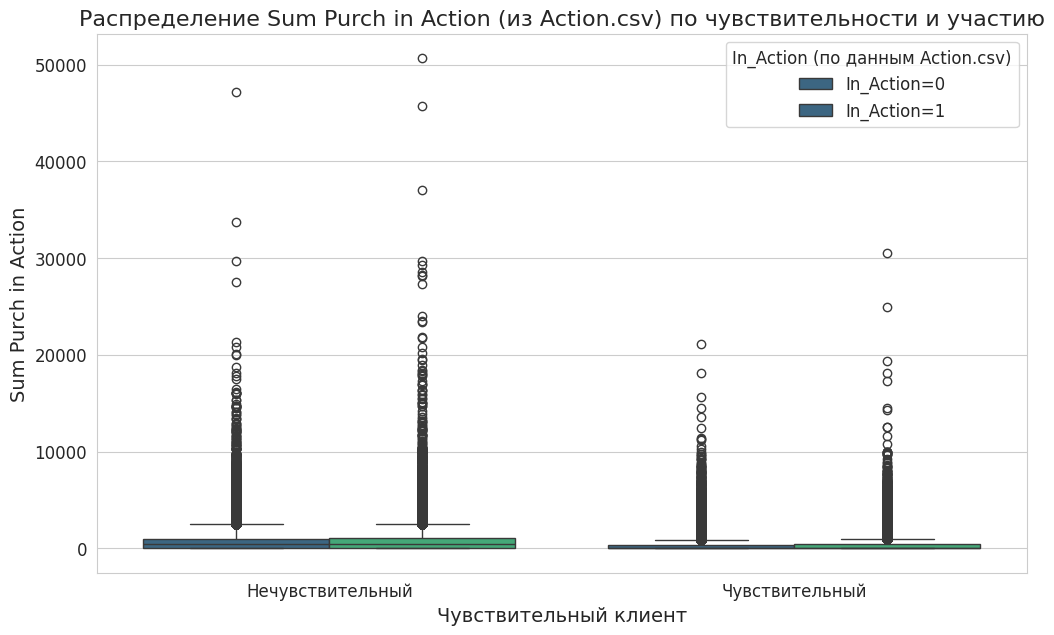


Среднее Sum Purch in Action (из Action.csv) по участию и чувствительности:
Is_Sensitive  False  True 
In_Action                 
0            718.88 286.07
1            754.61 315.64


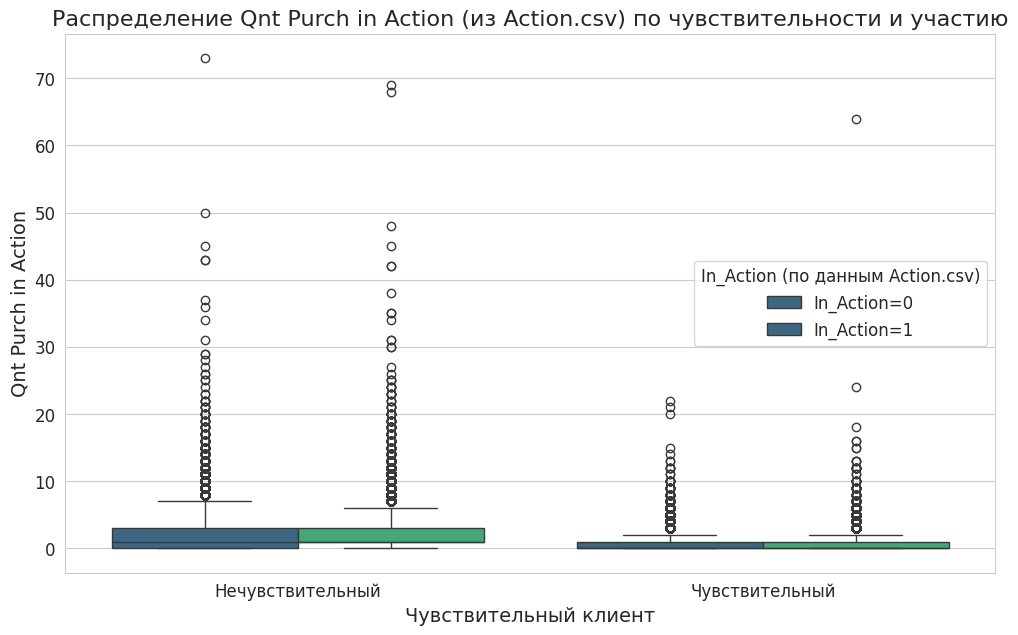


Среднее Qnt Purch in Action (из Action.csv) по участию и чувствительности:
Is_Sensitive  False  True 
In_Action                 
0              1.80   0.59
1              1.92   0.68


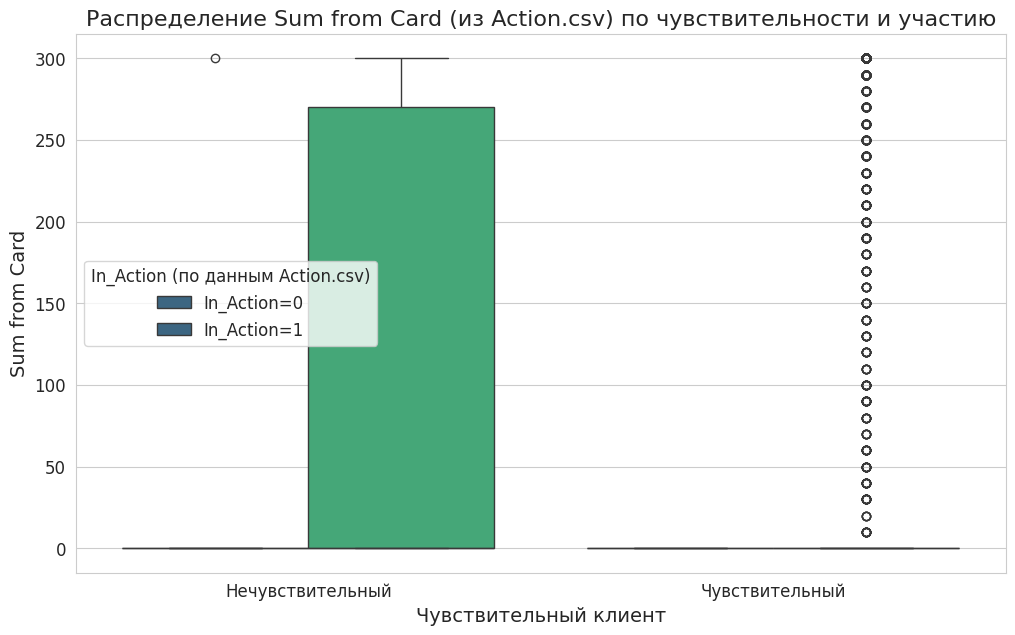


Среднее Sum from Card (из Action.csv) по участию и чувствительности:
Is_Sensitive  False  True 
In_Action                 
0              0.00   0.00
1             76.14  38.92


In [16]:
#  3.1. Распределение метрик ИЗ Action.csv, сгруппированное по In_Action и Is_Sensitive
metrics_from_action_csv = ['Sum_Purch_in_Action', 'Qnt_Purch_in_Action', 'Sum_from_Card']

for metric in metrics_from_action_csv:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=action_analysis_df, x='Is_Sensitive', y=metric, hue='In_Action', palette='viridis')
    plt.title(f'Распределение {metric.replace("_", " ")} (из Action.csv) по чувствительности и участию')
    plt.xlabel('Чувствительный клиент')
    plt.ylabel(metric.replace("_", " "))
    plt.xticks(ticks=[0, 1], labels=['Нечувствительный', 'Чувствительный'])
    plt.legend(title='In_Action (по данным Action.csv)', labels=['In_Action=0', 'In_Action=1'])
    plt.show()

    print(f"\nСреднее {metric.replace('_', ' ')} (из Action.csv) по участию и чувствительности:")
    print(action_analysis_df.groupby(['In_Action', 'Is_Sensitive'])[metric].mean().unstack())

In [17]:
# 3.2. Анализ привлеченных клиентов (без оценки удержания после акции)

action_analysis_df['Made_Any_Purchase_Action_Day_Flag'] = action_analysis_df['Total_Amount_Action_Day_Full_DF'] > 0
action_analysis_df['Attracted_New_Clients_Flag'] = (
    (action_analysis_df['Total_Amount_Action_Day_Full_DF'] > 0) &
    (action_analysis_df['Bought_Before_Action_Window'] == False)
)

funnel_summary = action_analysis_df.groupby(['In_Action', 'Is_Sensitive'], observed=True).agg(
    Total_Campaign_Records=('Person_BKEY', 'size'),
    Unique_Clients_in_Campaign=('Person_BKEY', 'nunique'),
    Clients_Made_Any_Purchase_Action_Day=('Made_Any_Purchase_Action_Day_Flag', 'sum'), # Просто сумма флагов
    Attracted_New_Clients_Any_Purchase=('Attracted_New_Clients_Flag', 'sum') # Просто сумма флагов
).reset_index()


funnel_summary['Participation_Group'] = funnel_summary['In_Action'].map({0: 'In_Action = 0', 1: 'In_Action = 1'})
funnel_summary['Sensitive_Group'] = funnel_summary['Is_Sensitive'].map({False: 'Нечувствительный', True: 'Чувствительный'})

print(funnel_summary[['Participation_Group', 'Sensitive_Group', 'Total_Campaign_Records', 'Unique_Clients_in_Campaign']].to_string())


  Participation_Group   Sensitive_Group  Total_Campaign_Records  Unique_Clients_in_Campaign
0       In_Action = 0  Нечувствительный                  153602                      153602
1       In_Action = 0    Чувствительный                   96416                       96416
2       In_Action = 1  Нечувствительный                  153746                      153746
3       In_Action = 1    Чувствительный                   96236                       96236
